In [1]:
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim

import sys
spath = '../scripts'
sys.path.insert(0, spath)

import kaldi_utils
from models import *
from notebook import *

### Loading data from drive

In [2]:
data_folder = '/export/b03/carlosc/data/2020/augmented'
embedding_dim = 128

dev_rttm     = data_folder + '/callhome/callhome1/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/ref.rttm'
dev_segments = data_folder + '/callhome/callhome1/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/segments'
dev_ivectors = data_folder + '/callhome/callhome1/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/exp/make_ivectors/ivector.txt'
dev_xvectors = data_folder + '/callhome/callhome1/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/exp/make_xvectors/xvector.txt'
dev_files_segments = get_rttm_segments_features(dev_rttm, dev_segments, dev_ivectors, dev_xvectors)

eval_rttm     = data_folder + '/callhome/callhome2/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/ref.rttm'
eval_segments = data_folder + '/callhome/callhome2/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/segments'
eval_ivectors = data_folder + '/callhome/callhome2/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/exp/make_ivectors/ivector.txt'
eval_xvectors = data_folder + '/callhome/callhome2/augmented_0/1.0_0.5_0.5/' + str(embedding_dim) + '/exp/make_xvectors/xvector.txt'
eval_files_segments = get_rttm_segments_features(eval_rttm, eval_segments, eval_ivectors, eval_xvectors)

### Filtering data

In [3]:
dev_files_segments_lim = limit_segments_speakers_length(dev_files_segments, 10, log = True)
eval_files_segments_lim = limit_segments_speakers_length(eval_files_segments, 10, log = True)

Kept 70546 of 70546: 1.0
Kept 66651 of 66651: 1.0


In [4]:
def invert_speaker_weights(speakers_weights):
    weight_sum = sum(speakers_weights.values())
    weight_count = len(speakers_weights.values())
    speakers_weights_inverse = {}
    for speaker_name, weight in speakers_weights.items():
        speakers_weights_inverse[speaker_name] = (weight_sum - speakers_weights[speaker_name]) / ((weight_count - 1) * weight_sum)
    return speakers_weights_inverse

class Files_dataset(Dataset):
    def __init__(self,
                 embedding_dim,
                 files_segments,
                 files_speakers = {},
                 models_generation_lengths = [3],
                 models_container_length = 2,
                 include_zeros = True,
                 include_overlaps = False,
                 feature = 'ivectors',
                 zeros_multiplier = 1.0):
        self.embedding_dim = embedding_dim
        self.files_segments = files_segments
        self.files_speakers = {}
        for file_id in self.files_segments:
            self.files_speakers[file_id] = files_speakers[file_id] if file_id in files_speakers \
            else get_first_speakers(self.files_segments[file_id])
        self.models_generation_lengths = models_generation_lengths
        self.models_container_length = models_container_length
        self.include_zeros = include_zeros
        self.include_overlaps = include_overlaps
        self.feature = feature
        self.zeros_multiplier = zeros_multiplier
        
        
        self.speakers_segments_indexes = {}
        self.speakers_models = {}
        self.speakers_models_combinations_length = {}
        self.files_turns = {}
        files_turns_count = {}
        self.files_lengths = {}
        self.files_speakers_permutations = {}
        self.files_speakers_weights = {}
        self.lookup = []
        self.length = 0
        for file_id, segments in self.files_segments.items():
            self.speakers_segments_indexes[file_id] = get_speakers_segments_indexes(enumerate(segments))
            self.speakers_models[file_id] = get_speakers_models(segments,
                                                                self.speakers_segments_indexes[file_id],
                                                                self.models_generation_lengths,
                                                                self.files_speakers[file_id])
            self.speakers_models_combinations_length[file_id] = len(self.models_generation_lengths) ** len(self.speakers_models[file_id].keys())
            self.files_turns[file_id] = 8
            files_turns_count[file_id] = 0
            self.files_lengths[file_id] = self.files_turns[file_id] * self.speakers_models_combinations_length[file_id] * len(segments)
            self.files_speakers_permutations[file_id] = Permutations(self.speakers_models[file_id].keys(),
                                                                     self.files_lengths[file_id],
                                                                     self.models_container_length,
                                                                     self.include_zeros)
            speakers_weights = self.files_speakers_permutations[file_id].get_speakers_names_counts()
            if self.include_zeros and '0' in speakers_weights:
                speakers_weights['0'] *= (1 / self.zeros_multiplier)
            self.files_speakers_weights[file_id] = invert_speaker_weights(speakers_weights)
            self.lookup.append([file_id for _ in range(self.files_turns[file_id] * self.speakers_models_combinations_length[file_id])])
            
        self.lookup = list(itertools.chain(*self.lookup))
        random.shuffle(self.lookup)
        for index, file_id in enumerate(self.lookup):
            segments = self.files_segments[file_id]
            self.lookup[index] = { 'onset': self.length, 'end': self.length + len(segments) - 1,
                                  'file_id': file_id, 'turn': files_turns_count[file_id] }
            files_turns_count[file_id] += 1
            self.length += len(segments)

    def __len__(self):
        return self.length

    def __getitem__(self, key):
        lookup = [value for value in self.lookup if value['onset'] <= key and key <= value['end']][0]
        file_id = lookup['file_id']
        turn = lookup['turn']
        segment_index = key - lookup['onset']

        segments = self.files_segments[file_id]
        file_index = turn * len(segments) + segment_index
        
        _, model_index = divmod(file_index, self.speakers_models_combinations_length[file_id] * len(segments))
        model_index, _ = divmod(model_index, len(segments))
        
        models = {}
        models_speakers_names = list(self.speakers_models[file_id].keys())
        remainder = model_index
        for speaker_name_index, speaker_name in enumerate(models_speakers_names):
            models_lengths = [len(self.speakers_models[file_id][speaker_name].keys()) for speaker_name in models_speakers_names[speaker_name_index + 1:]]
            if speaker_name_index != len(models_speakers_names) - 1:
                model_index, remainder = divmod(remainder, int(np.prod(models_lengths)))
            else:
                model_index = remainder
            models[speaker_name] = self.speakers_models[file_id][speaker_name][list(self.speakers_models[file_id][speaker_name].keys())[model_index]]

        permutation = self.files_speakers_permutations[file_id][file_index]
        models_container = [models[speaker_name] if speaker_name != '0' else { 'ivectors': [Ivector(np.random.uniform(-0.1, 0.1, self.embedding_dim).astype(np.float32))], 'xvectors': [Ivector(np.random.uniform(-0.1, 0.1, self.embedding_dim).astype(np.float32))] } for speaker_name in permutation]
        
        segment = segments[segment_index]
        segment_speakers_names = [speaker.get_name() for speaker in segment.get_speakers()]
        
        x = [embeddings[self.feature][0].get_value() for embeddings in models_container + [{ 'ivectors': segment.get_ivectors(), 'xvectors': segment.get_xvectors() }]]
        y = np.asarray([speaker_name in segment_speakers_names for speaker_name in permutation], dtype = np.float32)
        w =  np.asarray([self.files_speakers_weights[file_id][speaker_name] for speaker_name in permutation], dtype = np.float32)
        return x, y, w

In [5]:
class Model(nn.Module):
    def __init__(self, b, M):
        super(Model, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d((M + 1), M ** 3, 3),
            nn.ReLU(),
            nn.Conv1d(M ** 3, M ** 2, 3),
            nn.ReLU(),
            nn.Conv1d(M ** 2, M, 3),
            nn.ReLU(),
        )
        self.lstm1 = nn.Sequential(
            nn.LSTM(b - 6, 8, bidirectional = True),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(M * 2 * 8, M * 4),
            nn.ReLU(),
            nn.Linear(M * 4, M * 2),
            nn.ReLU(),
            nn.Linear(M * 2, M),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = torch.stack(x, 1)
        x = self.cnn1(x)
        x, _ = self.lstm1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt

class Train_graph:
    def __init__(self, training_loss, validation_loss = None):
        self.step = 0
        self.training_losses_x = [self.step - 1, self.step]
        self.training_losses_y = [training_loss, training_loss]
        self.validation_losses_x = None if validation_loss is None else [self.step - 1, self.step]
        self.validation_losses_y = None if validation_loss is None else [validation_loss, validation_loss]
        
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot()
        
        self.training_line, = self.ax.plot(self.training_losses_x, self.training_losses_y, '--', label = 'Training')
        self.validation_line = None if validation_loss is None else self.ax.plot(self.validation_losses_x, self.validation_losses_y, label = 'Validation')[0]
            
        self.ax.set_ylim(0, training_loss if validation_loss is None else (training_loss if training_loss > validation_loss else validation_loss))
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.legend()
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
    def draw(self, training_loss, validation_loss = None):
        self.step += 1
        self.training_losses_x.append(self.step)
        self.training_losses_y.append(training_loss)
        self.training_line.set_xdata(self.training_losses_x)
        self.training_line.set_ydata(self.training_losses_y)
        
        if validation_loss is not None:
            if self.validation_line is None:
                self.validation_losses_x = [self.step - 1]
                self.validation_losses_y = [validation_loss]
                self.validation_line = self.ax.plot(self.validation_losses_x, self.validation_losses_y, label = 'Validation')[0]
                self.ax.legend()
            self.validation_losses_x.append(self.step)
            self.validation_losses_y.append(validation_loss)
            self.validation_line.set_xdata(self.validation_losses_x)
            self.validation_line.set_ydata(self.validation_losses_y)
        self.ax.set_xlim(0, self.step + 1)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-46xylie9 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<IPython.core.display.Javascript object>


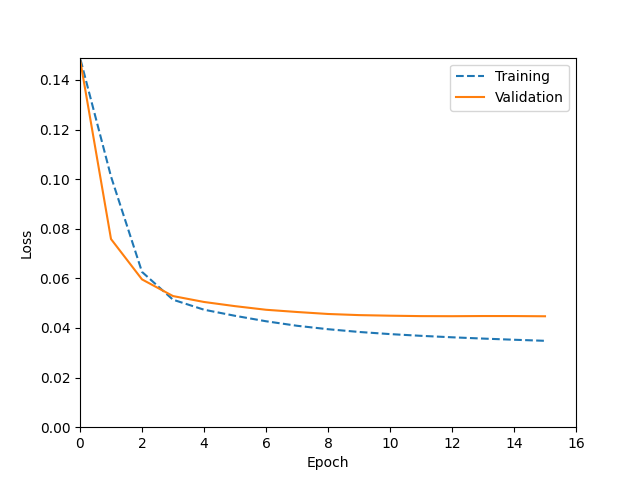

In [8]:
seed = 19970917 #25005233 19970917
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

models_container_length = 6

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

dev_files_ids = list(dev_files_segments_lim.keys())
dev_validation_files_ids = random.sample(dev_files_ids, int(len(dev_files_ids) * 0.3))
dev_train_files_ids = [file_id for file_id in dev_files_ids if file_id not in dev_validation_files_ids]

dev_train_files_segments = {}
for file_id in dev_train_files_ids:
    dev_train_files_segments[file_id] = dev_files_segments_lim[file_id]
dev_validation_files_segments = {}
for file_id in dev_validation_files_ids:
    dev_validation_files_segments[file_id] = dev_files_segments_lim[file_id]

dev_train_dataset = Files_dataset(embedding_dim,
                                  dev_train_files_segments,
                                  models_generation_lengths = [10],
                                  models_container_length = models_container_length,
                                  feature = 'ivectors')
dev_validation_dataset = Files_dataset(embedding_dim,
                                       dev_validation_files_segments,
                                       models_generation_lengths = [10],
                                       models_container_length = models_container_length,
                                       feature = 'ivectors')

dev_train_dataloader = DataLoader(dev_train_dataset, batch_size = 32, num_workers = 8)
dev_validation_dataloader = DataLoader(dev_validation_dataset, batch_size = 32, num_workers = 8)

net = Model(embedding_dim, models_container_length).to(device, non_blocking = True)
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

losses = []
with torch.no_grad():
    for dataloader in [dev_train_dataloader]:
        for x, y, w in dataloader:
            x = [tensor.to(device, non_blocking = True).float() for tensor in x]
            y = y.to(device, non_blocking = True).float()
            w = w.to(device, non_blocking = True).float()
            criterion = nn.BCELoss(w)
            y_ = net(x)
            loss = criterion(y_, y)
            losses.append(loss.data)
train_loss = (np.sum(losses) / len(losses)).cpu()

validation_losses = []
with torch.no_grad():
    for dataloader in [dev_validation_dataloader]:
        for x, y, w in dataloader:
            x = [tensor.to(device, non_blocking = True).float() for tensor in x]
            y = y.to(device, non_blocking = True).float()
            w = w.to(device, non_blocking = True).float()
            criterion = nn.BCELoss(w)
            y_ = net(x)
            loss = criterion(y_, y)
            validation_losses.append(loss.data)
validation_loss = (np.sum(validation_losses) / len(validation_losses)).cpu()


train_graph = Train_graph(train_loss, validation_loss)

for train_dataloader, validation_dataloader in [(dev_train_dataloader, dev_validation_dataloader)]:
    for epoch in range(15):
        losses = []
        for x, y, w in train_dataloader:
            x = [tensor.to(device, non_blocking = True).float() for tensor in x]
            y = y.to(device, non_blocking = True).float()
            w = w.to(device, non_blocking = True).float()

            criterion = nn.BCELoss(w)
            net.zero_grad()
            y_ = net(x)
            loss = criterion(y_, y)
            loss.backward()
            optimizer.step()

            losses.append(loss.data)
        train_loss = np.sum(losses) / len(losses)
        
        validation_losses = []
        with torch.no_grad():
            for x, y, w in validation_dataloader:
                x = [tensor.to(device, non_blocking = True).float() for tensor in x]
                y = y.to(device, non_blocking = True).float()
                w = w.to(device, non_blocking = True).float()
                criterion = nn.BCELoss(w)
                y_ = net(x)
                loss = criterion(y_, y)
                
                validation_losses.append(loss)
        validation_loss = np.sum(validation_losses) / len(validation_losses)
        
        train_graph.draw(train_loss, validation_loss)
        print(train_loss, validation_loss, end = '\r')

In [35]:
class File_dataset(Dataset):
    def __init__(self,
                 embedding_dim,
                 segments,
                 speakers = [],
                 models_generation_length = 10,
                 models_container_length = 2,
                 feature = 'ivectors'):
        self.embedding_dim = embedding_dim
        self.segments = segments
        self.speakers = speakers[:models_container_length]
        if len(self.speakers) < models_container_length:
            speakers = [speaker for speaker in get_first_speakers(segments) if speaker not in self.speakers]
            self.speakers += speakers[:models_container_length - len(self.speakers)]
            self.speakers += ['0' for i in range(models_container_length - len(self.speakers))]                
        self.models_generation_length = models_generation_length
        self.models_container_length = models_container_length
        self.feature = feature
        self.length = len(segments)
        
        self.speakers_segments_indexes = get_speakers_segments_indexes(enumerate(segments))
        self.speakers_models = get_speakers_models(segments,
                                                   self.speakers_segments_indexes,
                                                   [self.models_generation_length],
                                                   self.speakers)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, key):
        segment = self.segments[key]
        models_container = [self.speakers_models[speaker][self.models_generation_length] if speaker != '0' and speaker in self.speakers_models else { 'ivectors': [Ivector(np.random.uniform(-0.1, 0.1, self.embedding_dim).astype(np.float32))], 'xvectors': [Xvector(np.random.uniform(-0.1, 0.1, self.embedding_dim).astype(np.float32))] } for speaker in self.speakers]
        x = [embeddings[self.feature][0].get_value() for embeddings in models_container + [{ 'ivectors': segment.get_ivectors(), 'xvectors': segment.get_xvectors() }]]
        return x, key, self.speakers
    
def net_scoring(x, net, device):
    with torch.no_grad():
        x = [tensor.to(device) for tensor in x]
        y_ = net(x)
        return y_.cpu().numpy()[0]
    
def get_custom_rttm(segment, speaker_name):
    return segment.get_type() + ' ' + \
        segment.get_file_id() + ' ' + \
        segment.get_speakers()[0].get_channel_id() + ' ' + \
        str(round(segment.get_turn_onset(), 3)) + ' ' + \
        str(round(segment.get_turn_duration(), 3)) + ' ' + \
        segment.get_orthography_field() + ' ' + \
        segment.get_speakers()[0].get_type() + ' ' + \
        speaker_name + ' ' + \
        segment.get_confidence_score() + ' ' + \
        segment.get_signal_lookahead_time() + '\n'

eval_files_speakers = get_first_speakers(eval_files_segments, models_container_length)

groundtruth_rttm = ''
result_rttm = ''
post_rttm = ''
for file_id, segments in eval_files_segments_lim.items():
    groundtruth_segments = []
    result_segments = []
    file_dataset = File_dataset(embedding_dim,
                                segments,
                                models_container_length = models_container_length,
                                feature = 'ivectors')
    file_dataloader = DataLoader(file_dataset)
    for x, segment_index, speakers in file_dataloader:
        segment = segments[segment_index]
        if len(groundtruth_segments) > 0 \
        and groundtruth_segments[-1].has_overlap(segment) \
        and groundtruth_segments[-1].has_same_speakers(segment):
            groundtruth_segments[-1].set_turn_end(segment.get_turn_end())
        else:
            groundtruth_segments.append(segment)

        y_ = net_scoring(x, net, device)
        if sum(y_) > 1.7:
            print(speakers)
            print([speaker.get_name() for speaker in segment.get_speakers()])
            print(y_)
        index = np.argmax(y_)
        result_segment = Segment(segment)
        result_speaker = result_segment.get_speakers()[0]
        result_speaker.set_name(str(index))
        result_segment.set_speakers([result_speaker])
        if len(result_segments) > 0 \
        and result_segments[-1].has_overlap(result_segment) \
        and result_segments[-1].has_same_speakers(result_segment):
            result_segments[-1].set_turn_end(result_segment.get_turn_end())
        else:
            result_segments.append(result_segment)

    post_segments = [Segment(result_segments[0])]
    for index, t_segment in enumerate(result_segments):
        if index > 1:
            t_1_segment = result_segments[index - 1]
            t_2_segment = post_segments[-1]
            if t_segment.has_overlap(t_2_segment) and t_segment.has_overlap(t_1_segment) \
            and t_segment.has_same_speakers(t_2_segment):
                post_segments[-1].set_turn_end(t_1_segment.get_turn_end())
            else:
                post_segments.append(Segment(t_1_segment))
    if post_segments[-1].has_overlap(result_segments[-1]) \
    and post_segments[-1].has_same_speakers(result_segments[-1]):
        post_segments[-1].set_turn_end(result_segments[-1].get_turn_end())
    else:
        post_segments.append(Segment(result_segments[-1]))            
        
    groundtruth_rttm += ''.join([segment.get_rttm() for segment in groundtruth_segments])
    result_rttm += ''.join([segment.get_rttm() for segment in result_segments])
    post_rttm += ''.join([segment.get_rttm() for segment in post_segments])
    
        
tmp_folder = 'batch/20200831'
!mkdir -p $tmp_folder

file = open(tmp_folder + '/groundtruth.rttm', 'w')
file.write(groundtruth_rttm)
file.close()
        
file = open(tmp_folder + '/result.rttm', 'w')
file.write(result_rttm)
file.close()

file = open(tmp_folder + '/post.rttm', 'w')
file.write(post_rttm)
file.close()
    
kaldi_utils.md_eval(tmp_folder + '/groundtruth.rttm', tmp_folder + '/result.rttm', tmp_folder)
!cat $tmp_folder/der.log

kaldi_utils.md_eval(tmp_folder + '/groundtruth.rttm', tmp_folder + '/post.rttm', tmp_folder)
!cat $tmp_folder/der.log
    

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.81728727 0.05958774 0.9170394  0.01083078 0.00284388 0.00138281]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9320447e-01 4.9613255e-01 3.0526721e-01 2.1814664e-03 4.1489810e-04
 1.4537125e-03]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.9154989e-01 8.2670152e-01 1.2394700e-01 3.3803356e-03 2.1902483e-04
 2.0381373e-03]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9118659  0.675766   0.49282598 0.01397572 0.00463276 0.03897937]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.959764   0.56980306 0.5142156  0.02005856 0.00257156 0.0288876 ]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[0.94970053 0.18886365 0.92593795 0.00630597 0.00308932 0.00153633]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.8412919e-01 1.1046120e-01 7.4584180e-01 2.4436493e-03 7.1394973e-04
 9.3467487e-04]
[('B',), ('A',), ('B1',), ('0',), ('0

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.30679387 0.5925673  0.9894852  0.00222873 0.01825587 0.00268486]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[9.5483083e-01 3.5578832e-02 7.3981810e-01 7.7168911e-04 8.0930197e-04
 2.4247362e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[0.8366913  0.63628924 0.80251336 0.00154013 0.00176764 0.00401556]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[5.3661221e-01 1.6556229e-01 9.8753440e-01 4.0027527e-03 1.4383992e-02
 7.2522991e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9311974  0.32885748 0.9228243  0.00322968 0.00616169 0.00376652]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9436649  0.57494944 0.8296346  0.00625327 0.00768086 0.0166291 ]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.51096404 0.6836079  0.9315882  0.00289791 0.00559612 0.01120026]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['

[9.8272842e-01 8.1458789e-01 5.4903573e-01 6.0268203e-03 9.4033987e-04
 4.4203401e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6457726e-01 8.9684439e-01 2.5831750e-01 5.2282438e-03 5.7832187e-04
 5.2621951e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.90499973 0.98368615 0.17999566 0.00463831 0.00261536 0.00953997]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.5424642  0.9804007  0.3774499  0.00199636 0.00269428 0.01530076]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.975233   0.91217434 0.21763435 0.00671843 0.00180213 0.01173108]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9613736  0.88334185 0.31579688 0.01083244 0.00186149 0.02613367]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9189399  0.82214695 0.45360303 0.02021809 0.00387536 0.02776311]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.90533334 0.8767837  0.550666   0.00597429 0.00445924 0.0

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B']
[0.7429089  0.9459723  0.23207073 0.00330736 0.0018776  0.00555172]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B']
[0.7165794  0.9905876  0.14392985 0.008842   0.00153642 0.00663188]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[2.6625389e-01 9.7403222e-01 5.6132621e-01 1.4577952e-03 1.1965825e-03
 7.6306541e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.5918617  0.99371237 0.46256086 0.00832251 0.0018346  0.00425997]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.5728057  0.99090683 0.2111691  0.00211925 0.00129917 0.00289604]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9771081  0.91512036 0.14483552 0.00386892 0.00294183 0.00616747]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9808071  0.91187745 0.11912622 0.00998882 0.00434268 0.00566101]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.8246562  0.9681875  0.34

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.34392267 0.9521958  0.90766627 0.01687237 0.00990868 0.06428016]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.41122425 0.74349195 0.9682873  0.01387562 0.01591507 0.06230784]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.4073121  0.9391526  0.9696147  0.00633869 0.01008572 0.02109263]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.23333749 0.79642457 0.9659164  0.00209654 0.00672036 0.02873087]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[1.3442488e-01 8.5572970e-01 8.4234768e-01 8.5161545e-04 4.2994735e-03
 9.2089437e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.36704442 0.9576972  0.8751619  0.00254571 0.01499799 0.02531142]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.1173938  0.8612662  0.9634995  0.00525939 0.01373142 0.01328406]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.102022

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B']
[9.8984283e-01 1.2513925e-01 6.1712408e-01 4.3978132e-04 5.6082138e-04
 3.5700854e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[0.5218404  0.9914288  0.29476842 0.00152556 0.00218985 0.00518606]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[0.7826415  0.7504926  0.536039   0.00094425 0.00127905 0.00114539]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[0.54275304 0.49703082 0.7402229  0.00153283 0.00238566 0.00104662]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4505095e-01 9.0879965e-01 1.3260294e-01 1.8499665e-04 1.3703274e-03
 7.6344801e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.95891386 0.5559138  0.77286875 0.00205873 0.0018201  0.00256463]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9426183  0.898528   0.44908586 0.00215445 0.00180142 0.00599122]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.

[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.8197011e-01 2.3394737e-03 8.7385356e-01 3.4126767e-03 5.8292290e-03
 5.6192582e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9371688  0.00400323 0.9072224  0.00280682 0.00631436 0.00149584]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6521819e-01 1.0853012e-03 8.4812433e-01 1.8213816e-03 2.6117172e-03
 5.1547104e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.8872474e-01 3.6438417e-03 9.4682389e-01 2.8128645e-03 5.3871064e-03
 2.9898147e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.9371943e-01 3.3744609e-03 9.3100619e-01 3.8645342e-03 5.0916211e-03
 1.5469815e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.1542033e-01 3.8885893e-03 9.5986658e-01 2.2490334e-03 1.6422616e-02
 2.4890102e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.7451397  0.00523798 0.9680871  0.00637921 0.01809863 0.00097322]
[(

[8.2272488e-01 9.8733991e-01 9.2714407e-02 1.3682812e-03 9.2016504e-04
 4.0947692e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[6.1066300e-01 9.7549993e-01 2.5782150e-01 1.2426291e-03 3.9391828e-04
 3.8653391e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[7.2563887e-01 9.4077134e-01 6.4465880e-02 1.4509235e-03 5.9064175e-04
 1.1612147e-03]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[7.2591519e-01 9.2107809e-01 1.1220634e-01 7.2948838e-04 1.3651014e-03
 6.1003707e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[0.6000422  0.9560368  0.23429164 0.00332276 0.00238579 0.00123679]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[0.64365375 0.9770179  0.35919335 0.01046373 0.00639983 0.00232608]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.92196244 0.986579   0.28367582 0.00554659 0.00661803 0.00148022]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.0481514e-01 9.9805969e-01 6.2358093e-0

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9092686e-01 9.3949950e-01 8.5711181e-03 4.6634823e-03 2.5139909e-04
 1.6068682e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8382992e-01 9.6069419e-01 5.2816770e-03 2.6872708e-03 1.8466936e-04
 1.3021991e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7551244e-01 8.7268186e-01 2.0322730e-03 1.3287819e-03 4.5593235e-05
 8.9069852e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6632248e-01 8.9739192e-01 2.0745415e-02 9.0286331e-03 4.7643279e-04
 7.9132561e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8418182e-01 9.2983514e-01 7.9806754e-03 5.3861253e-03 2.3734476e-04
 3.9600614e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8082995e-01 9.4707125e-01 4.9019367e-03 3.3418362e-03 1.7995918e-04
 2.8624700e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.60727453e-01 9.25259113e-01 1.03539685e-02 1.94665429e-

[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7564620e-01 3.3440083e-01 9.1026014e-01 3.5070861e-03 2.4957305e-02
 7.5365335e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9248827e-01 5.2801853e-01 8.3499384e-01 2.4622737e-03 4.2221588e-03
 8.5967768e-05]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9725026e-01 3.1782207e-01 6.8387043e-01 9.4117428e-04 1.3525563e-03
 3.8016653e-05]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9771535e-01 3.0601642e-01 6.5553629e-01 1.5955543e-03 4.3289671e-03
 2.2037237e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9818987e-01 2.7572322e-01 7.8445721e-01 3.7049516e-03 1.0704438e-02
 2.4498496e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8763996e-01 1.3609439e-01 6.8887943e-01 1.4526313e-02 1.2273674e-02
 3.1781252e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5942360e-01 1.4685966e-01 6.3354188e-01 1.239140

[9.3003118e-01 9.7098875e-01 9.5468834e-03 4.5555318e-03 2.5462621e-04
 2.2052682e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4442183e-01 9.2776388e-01 2.0859763e-03 5.6928274e-04 2.6182128e-05
 5.0335622e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.2253772e-01 9.8096734e-01 4.0296987e-02 4.4113449e-03 5.1774055e-04
 3.2237775e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.6070297e-01 9.7352183e-01 2.3697985e-03 4.3355883e-03 7.4035706e-05
 1.0505940e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4003719e-01 8.5766268e-01 5.2390252e-03 1.5550044e-03 5.9861944e-05
 1.5093338e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.8697187e-01 9.7052032e-01 2.0246559e-03 8.0411515e-04 2.2350061e-05
 3.8316118e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[8.3986825e-01 9.8942822e-01 7.7903862e-03 7.6808184e-03 2.6304062e-04
 4.6681417e-03]
[('A',), ('B',), ('0',), ('0',)

[('A',), ('B',), ('A1',), ('0',), ('0',), ('0',)]
['A', 'A1']
[0.53687835 0.30022278 0.9820063  0.03454686 0.02152416 0.00111891]
[('A',), ('B',), ('A1',), ('0',), ('0',), ('0',)]
['A', 'A1']
[0.81057084 0.19426742 0.9133417  0.06633544 0.03133425 0.01095587]
[('A',), ('B',), ('A1',), ('0',), ('0',), ('0',)]
['A', 'A1']
[0.64858913 0.10943086 0.9483368  0.05369899 0.0279006  0.00632148]
[('A',), ('B',), ('A1',), ('0',), ('0',), ('0',)]
['A', 'A1']
[0.86250275 0.17522807 0.95339644 0.00935416 0.01096552 0.00303897]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['B']
[9.6527261e-01 7.9123861e-01 1.2797961e-03 2.0558356e-04 9.6088224e-06
 1.6105517e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['B']
[8.5490495e-01 8.5759854e-01 4.3965070e-04 1.8144352e-04 8.8164143e-06
 1.4220293e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.9215958e-01 9.2296571e-01 1.5460096e-03 3.1004686e-04 1.4226230e-05
 3.4052119e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]


[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B']
[9.4614267e-01 2.9166963e-02 7.0896691e-01 2.7099816e-02 3.3059272e-03
 2.5455945e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'A']
[0.60311216 0.63372254 0.728931   0.11468453 0.00284941 0.00536744]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'A']
[0.23857196 0.77464736 0.8577656  0.02030693 0.00768428 0.00100875]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.21092002 0.832622   0.79531866 0.15100273 0.00592814 0.00453949]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.54957485 0.11409441 0.79853815 0.22779255 0.00995876 0.0070977 ]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.21749297 0.70101446 0.7521634  0.05984615 0.00436744 0.00127132]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.07476933 0.9549669  0.602326   0.0697784  0.00924646 0.00144717]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.214717

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[0.8726675  0.05437276 0.6428584  0.15960193 0.00797944 0.0037373 ]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[0.8554941  0.12010781 0.62428516 0.1467283  0.00745346 0.00598916]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[0.8306904  0.05869698 0.66524404 0.25004014 0.00506272 0.00128415]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[7.0529753e-01 8.6559631e-02 8.4746522e-01 3.8130918e-01 3.4475881e-03
 8.0468919e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[0.71787506 0.08209544 0.86342347 0.2619938  0.00745233 0.00378168]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[0.79952663 0.03981677 0.9103949  0.19072351 0.01506131 0.00106351]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[7.7431691e-01 2.9410109e-02 8.7789601e-01 2.3663653e-01 3.8871008e-03
 4.3315763e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[0.63299316 0.01938385 0.66862667 0.4223661  0.00448824 0.0007859 ]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[0.676504   0.0439733  0.60475373 0.49460578 0.00450285 0.00194413]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[8.8152945e-01 1.6378433e-02 2.9139405e-01 6.3896275e-01 1.2618894e-03
 3.4677851e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[7.0112437e-01 2.2636414e-02 5.7664865e-01 7.3779023e-01 4.1857306e-03
 4.9053511e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[8.9960855e-01 4.1388795e-02 6.1086756e-01 1.3992128e-01 1.5625928e-02
 8.0231717e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[0.5548047  0.0213829  0.77494097 0.5198205  0.0034987  0.00297628]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[0.5335281  0.04081799 0.7480072  0.87702066 0.01360238 0.01035487]
[('B',), ('A',), ('B1',), 

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8776931e-01 9.5324492e-01 1.4430929e-02 9.3712164e-03 3.9645820e-04
 2.5750434e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9346006e-01 9.3724656e-01 2.0670811e-02 7.7701914e-03 5.0403556e-04
 3.1904641e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8986065e-01 8.3086759e-01 9.0066884e-03 5.5167796e-03 3.2653011e-04
 1.3320042e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8649663e-01 8.5890996e-01 3.9389324e-03 1.1328976e-03 9.9169745e-05
 2.8813659e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7621608e-01 8.8949174e-01 3.5260145e-03 1.7701995e-03 3.5504729e-04
 1.5762562e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9902642e-01 7.1097189e-01 2.5239619e-03 1.0002341e-02 1.3690339e-04
 8.7562914e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A']
[9.0956956e-01 9.4097441e-01 6.4273230e-03 1.7172218e-03 7.0668

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[1.1152281e-01 7.5068772e-01 8.5929984e-01 2.1859755e-04 1.7524642e-03
 3.8741153e-05]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[2.3726107e-01 5.1203489e-01 9.8363435e-01 1.8508356e-03 1.5641989e-02
 2.6544687e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[1.2509263e-01 6.5872258e-01 9.2218757e-01 2.5973312e-04 2.0649796e-03
 8.1107202e-05]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[2.0088053e-01 7.9288715e-01 8.7006176e-01 1.2986379e-04 2.3519346e-03
 1.1102343e-05]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[2.37651810e-01 7.59444773e-01 7.04945803e-01 1.06057465e-04
 5.01789735e-04 3.13666860e-05]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[2.6619956e-01 7.2859091e-01 8.5584354e-01 1.4424903e-03 2.3592969e-03
 4.7010710e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[2.1275103e-01 9.9303222e-01 5.2025026e-01 2.6570665e-04 1.3286682e-

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B']
[9.6883851e-01 8.5042280e-01 1.6490967e-03 5.3044909e-04 1.2625780e-04
 2.6147661e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B']
[9.3397349e-01 8.1354773e-01 5.5479831e-03 9.4101246e-04 6.5657514e-05
 2.5969473e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A']
[9.4876903e-01 9.8355776e-01 1.0812531e-02 3.3893902e-03 1.4738538e-04
 2.2683181e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A']
[9.02860403e-01 9.66132522e-01 8.43130983e-04 1.93051863e-04
 8.73520821e-06 1.21503064e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[0.96427906 0.9967873  0.05289648 0.01496621 0.00203763 0.00878498]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9083090e-01 9.8524851e-01 5.0257402e-03 1.5959555e-03 3.6990983e-04
 6.0275669e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9749453  0.9847274  0.04542541 0.00905621 0.00140748 0.00148098]
[('A',), ('B',), ('0',)

[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9656063e-01 9.6971297e-01 6.4713242e-03 7.7070028e-04 2.9946328e-04
 3.9228293e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9410373e-01 8.9873034e-01 2.5947306e-03 3.3807562e-04 6.4969972e-05
 1.5120911e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.3227202e-01 8.2443684e-01 5.8551010e-04 7.8169534e-05 3.1328840e-05
 1.3247658e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6405691e-01 9.6523243e-01 3.1449059e-03 6.2108051e-04 1.0100696e-04
 1.3133553e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9151695e-01 7.1163839e-01 2.8470555e-02 4.1206386e-03 3.0722478e-04
 3.2355234e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.0643734e-01 9.6448618e-01 3.5769813e-04 6.9278030e-05 1.4712595e-05
 2.7792019e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7083259e-01 9.0203434e-01 1.8449550e-03 2.4975039e-04 2

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8740458e-01 8.1364876e-01 1.5059912e-02 5.6705801e-03 1.9190574e-04
 1.9554566e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7237396e-01 8.1077194e-01 2.1599991e-02 1.0588448e-02 5.1770802e-04
 3.7117151e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2768073e-01 8.7813568e-01 3.3342525e-02 1.4378206e-02 5.6329154e-04
 2.6053158e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2027032e-01 8.7181318e-01 3.2719266e-02 1.3026748e-02 5.5949995e-04
 4.1099591e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9365968e-01 8.4318382e-01 1.7123453e-02 2.5443016e-03 3.9407003e-04
 1.4926071e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9139702e-01 7.1652842e-01 2.7584720e-02 1.2986891e-02 3.8458768e-04
 1.1009575e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9105012e-01 6.7824793e-01 3.7149686e-02 1.2940192e-02 3

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.3055993e-01 9.2464644e-01 4.0958854e-03 5.2844314e-04 7.0920396e-05
 1.3145818e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7250009e-01 9.7051358e-01 1.4879148e-03 2.1855983e-04 4.0281178e-05
 7.7696505e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9120951e-01 8.9578247e-01 2.0494880e-03 4.0360834e-04 3.8270697e-05
 6.6928571e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.3604743e-01 9.7932374e-01 2.5433286e-03 1.5213511e-04 7.4333038e-05
 6.5748533e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.6055688e-01 9.8953456e-01 1.3718008e-03 4.6379332e-04 2.9724517e-05
 1.1323420e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6983272e-01 9.2374808e-01 6.0583833e-03 1.6874197e-03 6.6073633e-05
 1.6229486e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.90374625e-01 8.23405504e-01 5.35034621e-03 2.57428153e-

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[2.5788930e-01 7.6705229e-01 9.1822743e-01 6.9585508e-03 2.5794094e-03
 5.5578421e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.13899054 0.98629063 0.7353395  0.00777818 0.00101968 0.00103806]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.5164644e-02 9.3783396e-01 7.8380817e-01 4.9696323e-03 1.6735934e-04
 5.5087829e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[5.2942550e-01 8.3037543e-01 7.0878923e-01 1.1035915e-03 4.3783875e-04
 4.4589286e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.8644162e-01 9.1933507e-01 5.5980861e-01 2.7772328e-03 4.1036081e-04
 3.7511412e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.2929621e-01 9.5163399e-01 5.4617375e-01 4.6795122e-03 5.2046048e-04
 6.5142714e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[6.4593410e-01 9.1177660e-01 4.7118223e-01 2.6832791e-03 1.7164

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[7.7161843e-01 5.2959543e-01 8.1543040e-01 2.3248908e-03 4.2693759e-04
 4.0043942e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.6471059e-01 1.0456437e-01 8.5634089e-01 7.3713867e-04 8.9959177e-04
 7.1193128e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.5377982e-01 7.5996399e-02 8.9049488e-01 9.2851807e-04 1.7495664e-03
 6.5075750e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.6224606e-01 4.6295937e-02 9.3441200e-01 1.2167797e-03 1.8988712e-03
 1.3227096e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[6.99353278e-01 1.08219236e-01 9.58978713e-01 1.29012926e-03
 2.09880411e-03 4.28947642e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.3703532e-01 1.3909085e-01 7.6583254e-01 1.8421770e-03 9.6144556e-04
 7.3874908e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.8526800e-01 4.6773237e-01 4.5011947e-01 

[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A']
[0.29499128 0.08224691 0.28201884 0.6103654  0.24480678 0.2034383 ]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'A1']
[0.35462233 0.03205048 0.06716746 0.7878007  0.4636951  0.09862987]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'A1']
[0.5643686  0.03766071 0.11359907 0.8412237  0.21042311 0.17577094]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'A1']
[0.56169397 0.02288389 0.07901116 0.8885467  0.10724822 0.24518965]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'A1']
[0.62751263 0.04900282 0.07261861 0.90941447 0.12596963 0.13472675]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'A1']
[0.5517446  0.02204967 0.1371945  0.85025454 0.25637046 0.10584208]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'A1']
[0.49072075 0.02191705 0.09087363 0.8937803  0.22128654 0.12359358]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'A1']
[0.7134203

[0.58770365 0.07583931 0.22450928 0.56263    0.24487896 0.02392835]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'A']
[0.6444221  0.01916721 0.09621249 0.9097357  0.24064167 0.05024572]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'A2']
[0.57610023 0.08471102 0.1064668  0.69173217 0.33273974 0.34361553]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'A2']
[0.3080071  0.05738109 0.11153924 0.77258605 0.37381843 0.30495578]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A']
[0.8398843  0.00820607 0.24290217 0.51567036 0.16912816 0.04410096]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['B', 'B2']
[0.01383373 0.70095533 0.56319547 0.03376333 0.3720059  0.02340736]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['B', 'B2']
[0.01141322 0.5283848  0.79266614 0.05182017 0.4605802  0.01288417]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['B', 'B2']
[0.0128336  0.9114982  0.5304831  0.01312265 0.30034947 0.0309538 ]
[('A',)

[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'B1']
[0.36148146 0.15336333 0.5071653  0.1647425  0.7026122  0.0268245 ]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'B1']
[0.09521758 0.05302029 0.71797913 0.37390485 0.64699066 0.04263497]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'B1']
[0.25527707 0.10713196 0.71142596 0.32500404 0.61927676 0.06212919]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A']
[0.90339035 0.01654719 0.0591752  0.6241158  0.03182158 0.17416094]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A']
[0.8898832  0.02107536 0.05420518 0.71657604 0.04420085 0.18487106]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A']
[0.8770077  0.03023994 0.0643541  0.7891436  0.0255862  0.05448573]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A']
[0.93908536 0.03185132 0.1460715  0.55906826 0.08479656 0.03154676]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'B1']
[0.2096171  0.05343587 0.241

[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A', 'B1']
[0.32491073 0.05322298 0.44183078 0.61437935 0.40451676 0.02406518]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A2']
[0.5322709  0.0267014  0.20091912 0.10582488 0.2616117  0.5844452 ]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A2']
[0.62591094 0.02164908 0.04551452 0.3033072  0.17660178 0.6437476 ]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A2', 'B1']
[0.07134268 0.24769048 0.67884856 0.33867127 0.45602247 0.16205552]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A2', 'B1']
[0.04818221 0.13406083 0.6050301  0.35868225 0.6389482  0.14559111]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A2', 'B1']
[0.13774964 0.07158857 0.47831902 0.46820426 0.60808975 0.21924944]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A2', 'B1']
[0.04395811 0.10459389 0.54267365 0.44581294 0.84711754 0.07131463]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A2', 'B1']
[0.099748

[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['B', 'B1']
[0.00996118 0.58513695 0.31363106 0.04987429 0.85905844 0.02770799]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A']
[0.76105404 0.0098374  0.24985953 0.57474715 0.12770759 0.03674646]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B']
[0.25069055 0.03785801 0.177846   0.87864375 0.55266386 0.06543193]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B']
[0.1632635  0.03169604 0.23582217 0.9294223  0.39836797 0.11859635]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B']
[0.09654816 0.3181105  0.3186266  0.6390812  0.48511368 0.03132102]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B']
[0.02937016 0.53075665 0.56115377 0.3351288  0.5219845  0.0200636 ]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B']
[0.02109928 0.38341314 0.551351   0.60506696 0.56436163 0.01059466]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B']
[0.0255813

[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['B1']
[0.03014641 0.11916091 0.50164807 0.17911653 0.9620395  0.03975231]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B1']
[0.08371178 0.05291793 0.24590316 0.51691073 0.9331465  0.06594251]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B1']
[0.15553239 0.05331079 0.33405727 0.73947704 0.71738344 0.13787913]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B1']
[0.15045382 0.15491658 0.54832715 0.43276268 0.6120574  0.06656159]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B1']
[0.32059902 0.17038545 0.3948     0.5384813  0.64136606 0.03747752]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B1']
[0.10356133 0.1616891  0.4777732  0.44211915 0.79589033 0.04752317]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B1']
[0.05209432 0.09766401 0.75647676 0.32764432 0.8405372  0.03714612]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B1']
[0

[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['B1', 'A']
[0.07857476 0.4645788  0.2523102  0.37840965 0.4936538  0.0357266 ]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['B1', 'A']
[0.04836887 0.07346518 0.3840406  0.6095159  0.81060237 0.02500425]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A']
[0.89587766 0.01138001 0.08198474 0.5752239  0.14942424 0.0561216 ]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['B1']
[0.00338853 0.0835093  0.65452325 0.02527725 0.9505673  0.00163203]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['B1']
[0.00591455 0.08011542 0.79725647 0.04035097 0.93085116 0.00195282]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['B1', 'A']
[0.06660955 0.09727892 0.6583427  0.14453799 0.7951241  0.02679989]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B1']
[0.02628865 0.18073967 0.7379847  0.48349148 0.93708974 0.0097019 ]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['A1', 'B1']
[0.08707187 0.0498

[0.02010028 0.2523851  0.48702782 0.69081354 0.23409252 0.02153267]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['B2']
[0.00370999 0.3678641  0.69742215 0.00787735 0.81769985 0.00198551]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['B2']
[0.00302198 0.11408547 0.73190457 0.02774017 0.907193   0.00223976]
[('A',), ('B',), ('B2',), ('A1',), ('B1',), ('A2',)]
['B2']
[0.01956361 0.13411334 0.7828534  0.10504958 0.8683852  0.01244226]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5165610e-01 9.9460804e-01 5.6813876e-03 1.0511841e-03 6.5833126e-05
 6.0666841e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7741359e-01 9.9332893e-01 2.2424774e-03 3.1926326e-04 1.7656510e-05
 1.0666196e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8867178e-01 9.4798332e-01 5.5217943e-03 7.7710871e-04 5.6560737e-05
 6.1082019e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8840839e-01 9.6865314e-01 7.5378469e-03 1.53

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.5416451e-01 9.6254617e-01 4.4599012e-03 2.1980744e-04 2.9966322e-04
 9.8913210e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[8.9494818e-01 9.6623749e-01 2.8686572e-03 1.2848966e-04 2.4831909e-04
 4.7679534e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9919277e-01 7.7664459e-01 2.8272858e-03 1.7468375e-03 1.6843404e-04
 2.1210729e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9595535e-01 9.1932178e-01 2.1743381e-03 1.9407434e-03 7.8456294e-05
 5.1864004e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.6158124e-01 9.8974645e-01 1.4631532e-03 3.8478404e-04 2.8252472e-05
 2.6923441e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6682245e-01 9.9277788e-01 2.1532595e-03 6.1412650e-04 3.3469933e-05
 1.6596312e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9623185e-01 9.6636027e-01 7.5113601e-03 1.1141665e-03 1

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4073856e-01 7.8929573e-01 7.4476638e-04 2.3646340e-04 6.4899855e-06
 1.4692443e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8513424e-01 9.5521766e-01 3.0879593e-03 1.5652471e-03 4.5390854e-05
 8.2861900e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.1815597e-01 9.0935785e-01 1.6378772e-02 9.1825463e-03 8.9910970e-04
 3.9460403e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5951325e-01 8.4984100e-01 1.1869458e-03 3.3612087e-04 2.1501919e-05
 4.2676099e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.90199506e-01 7.28650153e-01 5.20619145e-03 2.17157137e-03
 1.17620926e-04 5.57262509e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6311152e-01 8.8102102e-01 3.2744168e-03 2.4778764e-03 3.0228261e-05
 4.5755599e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4498670e-01 9.4961280e-01 1.0345948e-02 4.8349411

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8154497e-01 9.5005029e-01 2.4593234e-02 1.0888356e-02 2.7468006e-04
 2.5954735e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8079175e-01 9.7871768e-01 1.9557664e-02 1.5936574e-02 4.0182890e-04
 3.8014953e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2662454e-01 9.7917640e-01 6.8881172e-03 3.2505423e-03 6.7735622e-05
 2.9041809e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8614514e-01 9.7658312e-01 4.6770633e-03 1.4618350e-03 4.0404750e-05
 1.0753184e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9819285e-01 7.1146017e-01 3.3226288e-03 9.2017732e-04 7.5727483e-05
 2.7117375e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9562258e-01 8.9068675e-01 1.1841973e-02 4.4458336e-03 5.9416919e-04
 1.9527449e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7745842e-01 7.7330512e-01 2.4652235e-02 4.1423449e-03 2

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9604791e-01 9.4035649e-01 3.7320377e-03 3.0270591e-03 6.8935486e-05
 1.0311469e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9589741e-01 9.5896494e-01 3.9218604e-03 1.3843126e-03 4.3665357e-05
 4.1460746e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9670285e-01 9.1606569e-01 7.2416542e-03 3.2660069e-03 1.5900476e-05
 1.4541473e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.8914754e-01 9.7028089e-01 7.9486435e-03 9.5871147e-03 7.2387236e-05
 2.9755756e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.1467333e-01 9.3104094e-01 4.5771146e-04 1.0387261e-03 5.6587323e-06
 2.0763627e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.8778613e-01 9.8463237e-01 1.9297270e-03 9.9472562e-04 1.4967100e-05
 3.1647002e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9556488e-01 8.5828120e-01 4.2442465e-03 1.4290579e-03 6

[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8863089e-01 9.1644502e-01 8.5399533e-03 7.6371647e-04 5.5698125e-05
 3.1959396e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8271251e-01 9.4802511e-01 5.7070870e-03 1.1682633e-03 3.5460220e-05
 3.5452607e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5798004e-01 9.4189930e-01 2.3906014e-03 3.7127608e-04 5.9425245e-05
 2.0805362e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.3088115e-01 9.9424088e-01 3.8848806e-03 1.4113366e-03 1.3423507e-04
 4.5054528e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2086571e-01 8.9475346e-01 1.0686141e-03 2.4676754e-04 5.9306331e-06
 5.4793269e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7438365e-01 7.8803074e-01 2.2377709e-03 5.4059020e-04 2.0382497e-05
 1.0880661e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8853952e-01 7.0095152e-01 1.5310545e-02 1.3805855e-03 3

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[9.6403271e-01 7.6469457e-01 5.3166587e-02 6.6259112e-03 3.5713197e-04
 7.8905921e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[9.1191584e-01 6.7838842e-01 5.0072944e-01 4.7475961e-03 8.9626183e-04
 4.6362708e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.3229748e-01 9.8745871e-01 8.9792907e-02 2.5376012e-03 4.7497966e-04
 5.8123848e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[6.3224465e-01 9.9569678e-01 8.2791694e-02 1.4947683e-03 2.6942932e-04
 2.0025448e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[4.7796756e-01 9.9105877e-01 3.4465763e-01 2.0039466e-03 1.1268883e-03
 3.5549267e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[4.6561679e-01 8.4467173e-01 8.4397930e-01 7.9685515e-03 2.7194512e-03
 5.9413892e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.7371204  0.93821526 0.23757441 0.01696698 0.0

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.04749637 0.8871837  0.85137093 0.00323205 0.0435282  0.00483052]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.0851213e-01 7.7288222e-01 5.1471943e-01 5.1362300e-04 3.2342367e-03
 2.2366259e-03]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.08460731 0.9095682  0.9226883  0.00249429 0.04456548 0.00702099]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.22402838 0.99302036 0.63061035 0.00922142 0.02681242 0.00739286]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.20192339 0.6075787  0.88799816 0.00361362 0.01978111 0.00196834]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.17868693 0.98303336 0.6661631  0.01703708 0.05839609 0.10798609]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.13756052 0.87712973 0.9292975  0.00108979 0.02264458 0.00299465]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9933873

[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5118922e-01 9.2105836e-01 4.6235258e-03 7.2577572e-03 2.0854321e-04
 2.2408778e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7395194e-01 9.9329764e-01 1.6319050e-02 1.1154633e-02 7.4301998e-04
 3.5540184e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.98271793 0.875508   0.0251794  0.07242998 0.00306937 0.01015992]
[('B1',), ('A',), ('B',), ('0',), ('0',), ('0',)]
['B1', 'A']
[8.7859792e-01 9.6406454e-01 4.2726994e-02 1.6363030e-03 3.5238804e-04
 4.9597081e-03]
[('B1',), ('A',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.6980995e-01 7.5556856e-01 6.6125065e-02 1.1091291e-03 1.4143265e-04
 2.0909272e-04]
[('B1',), ('A',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.8458189e-01 9.4431072e-01 1.0309603e-01 6.4513050e-03 3.1814419e-04
 7.7613845e-04]
[('B1',), ('A',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.995054   0.9153648  0.3507482  0.00907374 0.00357136 0.00256733]
[

[0.91539985 0.60789317 0.24928601 0.72153986 0.00208224 0.00384363]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B1']
[0.68273616 0.669251   0.40498817 0.8431783  0.00490896 0.01394867]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B1']
[0.6129704  0.78314066 0.4961506  0.37136468 0.01148705 0.00915927]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B1']
[0.84463453 0.64011145 0.3729581  0.21870644 0.01705011 0.00709693]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B1']
[0.5306825  0.8973255  0.3392148  0.07889488 0.00561133 0.00277457]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B1']
[0.9565836  0.40375572 0.5507474  0.22801131 0.00234093 0.0037459 ]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B1']
[0.899066   0.48533377 0.5395571  0.45535842 0.01363082 0.01621147]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B1']
[0.90090173 0.67127264 0.36833292 0.28499982 0.05267625 0.01899282]
[('A',), ('B1',

[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B1']
[0.13140684 0.505339   0.92381555 0.17385651 0.0049598  0.00097392]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.27866903 0.83855194 0.7654927  0.40440655 0.00514454 0.00247542]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.901848   0.61735    0.8947903  0.14336836 0.01451705 0.01051153]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.8877343  0.7878969  0.9329311  0.2192245  0.01957664 0.01994177]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.8534697  0.83555186 0.92924833 0.18868412 0.00765963 0.00529075]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.5511962  0.7498668  0.8015464  0.09719595 0.00177602 0.00123634]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.6807511  0.8988772  0.6279022  0.12602586 0.00124594 0.00118313]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.2887694  0.9911747  0.

[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.6214823  0.17114462 0.9166816  0.16919148 0.00921157 0.00280482]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B']
[0.96180075 0.11191893 0.56801176 0.14053516 0.02596798 0.03866298]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.05530564 0.60458034 0.9250783  0.35155314 0.00396439 0.00983699]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.14118356 0.7371281  0.94543827 0.4702745  0.01223049 0.00787706]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.65297484 0.8261545  0.86252755 0.3336871  0.04636963 0.00949204]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[3.0825341e-01 5.9737575e-01 7.6771992e-01 1.1914816e-01 1.8243360e-03
 5.9052918e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.13975768 0.537253   0.895463   0.13265349 0.00498627 0.00659517]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.29044

[0.78550684 0.43999794 0.9325381  0.48296508 0.01644512 0.00339079]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.72651875 0.38956565 0.9672319  0.19012113 0.05191611 0.01846599]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.91553205 0.4022445  0.8496947  0.21772915 0.04373513 0.02335395]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B']
[0.7013838  0.17060743 0.8537505  0.5711971  0.01438847 0.00203979]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B']
[0.75545484 0.11760068 0.80219656 0.24423958 0.00558242 0.00120489]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.91365856 0.40862846 0.82078254 0.4517947  0.03710657 0.00782011]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.6415226  0.18882951 0.70814085 0.20119518 0.00788486 0.00071356]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[3.8336053e-01 2.1267965e-01 9.0468144e-01 3.4177712e-01 5.8481945e-03
 1.7247432e-04]
[('A',),

[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.9337982  0.15747179 0.70360225 0.27043477 0.00677011 0.00716413]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[8.34860504e-01 1.61597133e-01 7.21680045e-01 1.04173556e-01
 1.76314742e-03 9.51086913e-05]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[8.9284402e-01 2.7399635e-01 8.1623554e-01 6.7798235e-02 5.8587193e-03
 3.1962077e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.99235404 0.09717349 0.64005375 0.12349667 0.01257306 0.00290673]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.97895205 0.11698182 0.6198581  0.6151981  0.02259666 0.0124301 ]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.6904338  0.392627   0.8769559  0.20256339 0.00951007 0.00622037]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.7952404  0.30052015 0.8408088  0.18237941 0.00420669 0.00393837]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0

[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1']
[0.49882665 0.02657397 0.2493214  0.9439015  0.00764968 0.00249107]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1']
[0.6883545  0.02843161 0.38436192 0.9003368  0.02102859 0.0189393 ]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1']
[0.7826188  0.04043789 0.11261927 0.94712913 0.00213672 0.00135127]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'A1']
[0.609549   0.6104131  0.07897745 0.859127   0.00338129 0.00246171]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'A1']
[0.8510573  0.5975789  0.23427258 0.9233413  0.01101266 0.01346189]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'A1']
[0.84297335 0.5028594  0.2789105  0.89779174 0.00772638 0.00576895]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'A1']
[0.74927324 0.06909106 0.05706648 0.96104676 0.01359316 0.00127552]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'A1']
[8.6407769e-01 2.1914367e-02 3.0367

[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A1', 'B']
[8.2923692e-01 9.7062027e-01 1.7848624e-01 1.7586881e-03 9.1800804e-04
 1.7890910e-03]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A1', 'B']
[0.96781117 0.94050926 0.35448596 0.00512428 0.00232415 0.00300947]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A1', 'B']
[9.5708841e-01 6.2172002e-01 6.5496111e-01 4.0023061e-03 9.2130457e-04
 1.7350254e-03]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A1', 'B']
[5.7752103e-01 9.6551323e-01 4.5178679e-01 3.5732961e-03 7.0143910e-04
 1.1839099e-03]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['B', 'A']
[0.95781535 0.27073053 0.9248288  0.00386339 0.00221009 0.00109462]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.96419483 0.16869901 0.840272   0.00210766 0.00200389 0.00144672]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A1', 'B']
[0.84125453 0.63721293 0.5213472  0.00201267 0.00145275 0.00244431]
[('A1',), ('B',), ('A',), ('0',), (

[8.9907306e-01 3.4649447e-02 9.8981702e-01 9.0282615e-03 2.3333158e-02
 6.3127297e-04]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'A1']
[9.6225476e-01 3.0576164e-02 9.5885003e-01 2.9389856e-03 5.7309256e-03
 6.2482455e-04]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'A1']
[0.988735   0.0845569  0.8673842  0.00321744 0.00374807 0.00103272]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'A1']
[0.9806261  0.06830585 0.9225698  0.0131419  0.00756061 0.00229295]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'A1']
[0.9590632  0.08463943 0.9698668  0.0156942  0.00611767 0.00240659]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'A1']
[8.1374419e-01 3.7468847e-02 9.5300138e-01 1.1535523e-03 4.9230945e-03
 4.3418986e-04]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'A1']
[9.4905424e-01 8.8881165e-02 8.8246655e-01 1.0977341e-03 2.5035883e-03
 3.3990690e-04]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'A1']
[9.8578668e-01

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.0233115e-01 9.7958994e-01 6.3645351e-04 2.9037174e-04 4.5943587e-05
 8.2575549e-05]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.6972276e-01 9.8471385e-01 1.5443910e-03 2.8066791e-04 3.6200814e-05
 3.4122638e-04]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B2', 'B3']
[0.23850423 0.75625193 0.8515035  0.12539813 0.5354203  0.00683251]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B2', 'B3']
[0.27599663 0.6559753  0.9248746  0.05358349 0.33843407 0.02183148]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B2', 'B3']
[0.12472972 0.82740235 0.68634975 0.05347155 0.05106023 0.00444696]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['A', 'B1']
[0.7298396  0.04648459 0.13994423 0.36513948 0.90385824 0.05268509]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['A', 'B1']
[0.7550193  0.04661461 0.24077752 0.12484243 0.9159541  0.0143498 ]
[('A',), ('B2',), ('B3',), ('B',), ('B1',),

[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['A', 'B']
[0.96162504 0.0633927  0.01569011 0.9284268  0.04433617 0.00570411]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['A', 'B']
[0.9611885  0.0559011  0.00658849 0.92591196 0.14965679 0.00655914]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['A', 'B']
[0.36133105 0.01726884 0.01333358 0.9866288  0.5622212  0.00568613]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['A', 'B']
[0.66713125 0.02402431 0.02094739 0.95494604 0.544278   0.02617962]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['A', 'B']
[0.8109941  0.05364332 0.0149633  0.94272846 0.36279675 0.01218204]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['A', 'B']
[0.7370064  0.03944486 0.00929672 0.97133183 0.30107206 0.01736009]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['A', 'B']
[0.39737558 0.01792678 0.01224967 0.9885711  0.29302767 0.00813738]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['A', 'B']
[0.8715629  0.077329

[0.36232615 0.15417163 0.26425153 0.794499   0.8540167  0.03177047]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B1']
[0.32374    0.0092908  0.07268874 0.5882608  0.73028356 0.00777033]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B1']
[0.3389611  0.02265115 0.02883912 0.8831283  0.8184354  0.02441998]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B', 'B1']
[0.595752   0.09910499 0.05248097 0.9059604  0.7107595  0.03385724]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B', 'B1']
[0.67700344 0.04390302 0.05564468 0.86896944 0.7559489  0.01292517]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B', 'B1']
[0.8480949  0.0738268  0.06420944 0.6702868  0.843559   0.01723129]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B', 'B1']
[0.59903306 0.12089515 0.1471238  0.5713705  0.94398886 0.03008083]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B', 'B1']
[0.61903393 0.07745454 0.10788006 0.5731714  0.9511441  0.05598402]
[('A',), ('B2',), 

[0.6379086  0.66352826 0.04601154 0.4065215  0.05490457 0.00201938]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[0.46388897 0.86156124 0.3285799  0.4145377  0.13774517 0.00811286]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[0.73386645 0.7002147  0.0754806  0.5299482  0.45453545 0.01725883]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[0.6361248  0.23601894 0.01349633 0.84456736 0.4164912  0.00398745]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[0.5371571  0.19851634 0.01380533 0.860093   0.5651213  0.00481316]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[0.5306887  0.5599072  0.01966714 0.67709315 0.5365472  0.02751128]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[0.09042759 0.9792849  0.15962818 0.21144687 0.39513642 0.05769709]
[('A',), ('B2',), ('B3',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[0.28265247 0.82647103 0.07048496 0.5399463  0.32149294 0.00539703]
[('A',),

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.50431705e-01 1.09357074e-01 9.54664588e-01 2.19068816e-03
 4.37979912e-03 8.10925849e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.9099064e-01 2.3087692e-01 9.2950821e-01 5.7783118e-03 4.8455386e-03
 3.6870647e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.8838645e-01 7.6600671e-02 9.0846896e-01 3.2143693e-03 2.6694336e-03
 2.3024358e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.7358930e-01 2.0145347e-02 9.3341988e-01 5.8975240e-04 3.3316240e-03
 4.1734300e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.4861960e-01 9.3999766e-03 9.5534813e-01 2.5161344e-04 4.9713273e-03
 2.3349154e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.9276042e-01 7.4467763e-02 9.2356783e-01 6.4283074e-04 3.4980939e-03
 8.7761888e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.8884624e-01 8.0994464e-02 9.1592228e-01 7.

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.9453163e-01 6.6150405e-02 9.4640177e-01 1.0681591e-03 3.5674416e-03
 8.6112501e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.9189341e-01 1.9479832e-02 9.7377926e-01 8.7692164e-04 4.9341656e-03
 5.5504326e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.9671221e-01 4.9871042e-02 8.8262236e-01 2.3514168e-04 1.4977141e-03
 1.8604262e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.9665427e-01 4.7047175e-02 9.0910125e-01 5.5999291e-04 2.4137190e-03
 4.5819888e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.74669814e-01 1.02164345e-02 9.24646854e-01 3.98475881e-04
 2.68982025e-03 4.36964765e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.3817478e-01 5.8490871e-03 9.6448749e-01 2.6602347e-04 4.4304323e-03
 1.8248293e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.3120223e-01 1.7903212e-02 8.9017463

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A']
[9.9516499e-01 9.3073094e-01 5.5150562e-03 1.2528819e-03 3.1027163e-04
 1.1232563e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A']
[0.9863768  0.9905325  0.03259503 0.00447609 0.00235632 0.00316998]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.4813249e-01 9.5878780e-01 3.1881616e-02 4.3475968e-03 4.7358044e-04
 5.5844146e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.1506208e-01 9.8631465e-01 1.2972193e-02 1.2297467e-03 6.6531543e-04
 2.2794043e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.8142103e-01 9.7492629e-01 1.2989194e-02 1.2746875e-03 6.9274299e-04
 1.3377838e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.8865745e-01 9.3781942e-01 5.1544835e-03 2.9191982e-03 3.9123275e-04
 1.7038288e-02]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7270095e-01 7.8141129e-01 1.3773030e-03 1.8182714e-04 1.2867995e-04
 1.8432160e-04]


[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7215933e-01 6.8996227e-01 6.3904934e-02 1.7219765e-02 5.3297810e-04
 1.5067589e-02]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.1146451e-01 7.7620161e-01 5.7513967e-02 5.5060089e-03 3.1099186e-04
 9.4170626e-03]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6072483e-01 9.3222904e-01 5.9437793e-02 8.9831827e-03 6.4730726e-04
 1.2100683e-02]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6034622e-01 9.4571275e-01 6.0634516e-02 1.7148798e-02 3.9802864e-04
 1.1916380e-02]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[6.5155590e-01 3.1094101e-01 8.0701983e-01 4.0857042e-03 2.4070115e-04
 2.9232947e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[8.7929106e-01 4.0592691e-01 6.6453558e-01 2.6518030e-03 2.8870470e-04
 7.0796744e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9752574  0.9398476  0.02465752 0.0099301  0.00

[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9546993e-01 7.5662130e-01 2.6327504e-03 3.4437564e-03 7.7314246e-05
 1.7958636e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9622887e-01 8.0326039e-01 1.6248062e-03 2.1625257e-03 5.8179972e-05
 1.4367342e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9516726e-01 9.8751068e-01 1.0363677e-02 9.7592194e-03 1.8116122e-04
 1.6352985e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8036170e-01 9.9329042e-01 7.3557119e-03 5.5765188e-03 2.7301512e-04
 9.2678430e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.8243445e-01 7.4381387e-01 5.0439881e-03 2.3045354e-03 5.2797677e-05
 6.0593680e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.9626622e-01 9.9342346e-01 4.6821805e-03 1.9031233e-03 1.4778139e-04
 4.4865441e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6846157e-01 9.6123272e-01 6.4038304e-03 1.5002305e-03 1

[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['A', 'B1']
[0.13644451 0.55175185 0.44897676 0.995053   0.00920004 0.00222091]
[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['A', 'B1']
[1.3201088e-01 2.3701940e-01 7.2198462e-01 7.4536306e-01 1.8474286e-03
 7.2054262e-04]
[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['A', 'B1']
[0.39491394 0.36159402 0.7848395  0.57265973 0.00341923 0.00210556]
[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['A', 'B1']
[6.3320524e-01 1.8335992e-01 6.7228359e-01 6.3438785e-01 4.2882408e-03
 4.8224835e-04]
[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['A', 'B1']
[1.8465069e-01 5.9203649e-01 5.9811014e-01 5.1911384e-01 1.1325664e-03
 3.5040083e-04]
[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['A', 'B1']
[3.0337909e-01 8.9652187e-01 3.8298225e-01 8.0914539e-01 5.0439266e-04
 5.3104555e-04]
[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['A', 'B1']
[0.26925987 0.6082418  0.7901624  0.677898   0.00681358 0.00126421]
[('A',)

[0.6126224  0.60059303 0.3052121  0.3433738  0.00064738 0.00183723]
[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['A', 'B']
[2.1770814e-01 8.3368766e-01 2.7232653e-01 6.5341014e-01 2.4455192e-03
 6.2445959e-04]
[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['A', 'B']
[0.14134769 0.6046425  0.25772703 0.77774215 0.00408515 0.00156842]
[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['A', 'B']
[0.33825585 0.75526655 0.4557972  0.5433898  0.00778503 0.0013991 ]
[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['A', 'B']
[3.9014173e-01 9.0704364e-01 5.4739046e-01 2.1097948e-01 1.0890751e-03
 3.5119613e-04]
[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['A', 'B']
[2.3427989e-01 9.6291685e-01 4.6669945e-01 2.9880461e-01 6.4945954e-04
 3.8987267e-04]
[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['B1']
[2.1525260e-02 6.2680578e-01 6.6862136e-01 9.4875008e-01 3.8398831e-04
 6.4056767e-05]
[('A',), ('B',), ('A1',), ('B1',), ('0',), ('0',)]
['B1']
[1.9571172e-02 5.57825

[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9605286e-01 7.8506398e-01 1.6499486e-02 8.4462781e-03 4.4644385e-04
 9.7878359e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9113655e-01 7.8327984e-01 2.2929835e-03 3.6654377e-04 5.1196541e-05
 1.7285580e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2061764e-01 8.6302286e-01 5.5669690e-04 1.3675504e-04 2.2327116e-05
 1.5261969e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7015119e-01 9.5049483e-01 3.6190436e-03 7.0510176e-04 7.2275914e-05
 2.8181393e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9896712  0.83519953 0.03612443 0.00882565 0.00102031 0.00147167]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8993886e-01 9.2354935e-01 9.8844049e-03 3.9219591e-03 3.5738366e-04
 9.4687042e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9316061e-01 9.4827580e-01 1.0864486e-02 6.7908582e-03 5.9784058e-04
 1.008

[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B']
[8.6053544e-01 8.7193705e-02 5.1876372e-01 6.9067687e-01 5.3853147e-02
 7.1221107e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B']
[4.4595310e-01 5.1079732e-03 4.9236283e-01 7.7875727e-01 5.8062945e-02
 5.1672739e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B']
[1.1586123e-01 5.9058284e-03 5.5351621e-01 9.0768874e-01 1.9513379e-01
 4.6600951e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B']
[1.3175534e-01 1.5436512e-02 5.7141167e-01 9.2428201e-01 1.5757181e-01
 3.2360767e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'A']
[0.28804272 0.12165279 0.9182387  0.9107787  0.05737567 0.0013118 ]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'A']
[1.8825160e-01 7.2780162e-02 9.1082478e-01 8.8999152e-01 7.9119846e-02
 6.8600243e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[4.6604818e-01 3.4961057e-01 9.7489965e-01 3.0657962e-01 3.0174056e-01
 6.5569259

[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[3.4340584e-01 1.3978393e-01 9.8413390e-01 3.6368841e-01 4.2203203e-02
 4.9635186e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[5.3437507e-01 2.7353081e-01 9.8015690e-01 2.7353221e-01 1.6235267e-01
 8.0054230e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B1']
[0.7464015  0.58342093 0.8272329  0.245839   0.8903459  0.00097917]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B1']
[0.8006338  0.7018945  0.730465   0.22094811 0.80228895 0.00624709]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B1']
[0.553248   0.57352567 0.8503563  0.30301076 0.5899292  0.00377712]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B1']
[0.5969953  0.7256107  0.3506556  0.19183241 0.71934897 0.00108077]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B1']
[0.54654557 0.71884537 0.78626907 0.1232611  0.6699777  0.00151395]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)

[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[0.7222223  0.15639299 0.8378522  0.76802677 0.03809982 0.001257  ]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[8.9401138e-01 2.3401073e-01 7.3885304e-01 7.4623448e-01 2.9035710e-02
 4.9625494e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[0.7970685  0.30525523 0.65657735 0.8855895  0.08495099 0.00153935]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[0.46563342 0.38476828 0.9083413  0.87602395 0.17471994 0.00103975]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[0.7841132  0.34580973 0.64065033 0.75816625 0.19211635 0.0009141 ]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[5.9502625e-01 9.2917241e-02 6.6390383e-01 7.2922349e-01 3.4059176e-01
 5.8828382e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[0.46748996 0.14629748 0.93567586 0.84043103 0.42005938 0.00180157]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), (

[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2']
[0.7138901  0.31390712 0.5479824  0.08270872 0.06142468 0.0018732 ]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B1', 'B3']
[0.5989457  0.8960034  0.11107325 0.03702474 0.91319597 0.00604635]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B1', 'B3']
[0.64650846 0.9650192  0.18287924 0.01881148 0.7700748  0.00180529]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B1', 'B3']
[0.44579786 0.945609   0.23260164 0.03635738 0.6720565  0.00136396]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B1', 'B3']
[0.40975028 0.7846637  0.22017728 0.3470751  0.48866573 0.00265937]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B1', 'B3']
[0.64176404 0.29865602 0.28010696 0.47508425 0.5259932  0.00450764]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[5.4166478e-01 3.6361724e-02 9.3669820e-01 4.4378525e-01 2.0956933e-01
 3.4065984e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[6.85

[6.4008820e-01 2.0595030e-01 9.5019203e-01 4.6493137e-01 3.5937667e-02
 7.8848487e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[0.6420025  0.2544668  0.9431531  0.5744447  0.03348774 0.00132762]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[0.36991048 0.22811382 0.9685288  0.48074433 0.03828481 0.00449926]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[0.93121064 0.2681217  0.32145402 0.28362483 0.08963183 0.00416999]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[0.854578   0.44273135 0.28438285 0.8358474  0.0935119  0.00138522]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[0.71782666 0.24223886 0.36964855 0.9551299  0.16295016 0.00107546]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[6.2253326e-01 2.6323399e-01 3.2327402e-01 8.3777505e-01 1.7647116e-01
 7.6753815e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[0.78709793 0.41110253 0.42490092 0.7301709  0.221

[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2']
[8.6744499e-01 6.6477948e-01 3.6772367e-01 2.7325648e-01 1.0593943e-02
 3.6245456e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2']
[9.8434281e-01 1.5309569e-01 3.2080647e-01 2.4417418e-01 9.2506818e-03
 5.6967244e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2']
[5.3128779e-01 1.9347702e-01 5.9421873e-01 4.1557470e-01 4.7124535e-02
 2.4032255e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2']
[4.0470907e-01 9.0338737e-02 7.4876523e-01 4.2046136e-01 5.2140664e-02
 9.3437011e-05]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2']
[0.87193656 0.1342824  0.6594361  0.57151765 0.07798451 0.00103308]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2']
[8.6200160e-01 2.0605150e-01 5.3878069e-01 5.6944674e-01 2.3132637e-02
 5.0899538e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B2']
[0.89543605 0.49109697 0.6836377  0.510673   0.17246069 0.00275021]
[('B2',), (

[5.9184563e-01 2.3034269e-01 5.9232992e-01 7.2907066e-01 4.8281003e-02
 2.2049973e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B2']
[4.7883856e-01 3.3835399e-01 5.9934312e-01 5.3420722e-01 1.2435361e-01
 8.7001703e-05]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B2']
[7.3878479e-01 4.9647039e-01 6.3753116e-01 7.3496336e-01 1.5157963e-01
 9.4224029e-05]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B2']
[8.047667e-01 4.612983e-01 7.568454e-01 6.683348e-01 6.278276e-02
 2.602750e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2']
[9.5057857e-01 6.6874224e-01 1.1986019e-01 5.3376377e-02 1.7722340e-02
 5.3324492e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2']
[0.9886352  0.39231902 0.22506508 0.1282585  0.14412256 0.00130366]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2']
[0.9603557  0.4302297  0.10183837 0.155628   0.25014916 0.00128397]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B2']
[0

[0.806063   0.4537906  0.88974833 0.5762377  0.0344159  0.00090466]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[0.34124675 0.09721188 0.9474865  0.56451523 0.02924719 0.00162878]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[0.17063726 0.0434492  0.95295227 0.5088974  0.04993085 0.0013997 ]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[0.6181     0.22704776 0.94849044 0.49903733 0.04640282 0.00108938]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[4.2374137e-01 1.2700680e-01 9.8379725e-01 3.1945759e-01 1.5733826e-01
 8.6129771e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[3.1055009e-01 1.5669905e-01 9.8355401e-01 3.4464085e-01 1.2745599e-01
 4.2548182e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[3.9294147e-01 1.7935619e-01 9.8226154e-01 4.8302382e-01 8.8821262e-02
 2.3538775e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[7.1627343e-01 4.3373945e-01 8.9882618e-01 3.9903295e-01 4.11

[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[4.3826434e-01 9.6422619e-01 4.2662677e-01 5.6116921e-01 3.1368434e-04
 1.2908070e-04]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[6.68052554e-01 9.40382421e-01 1.23646475e-01 8.01185250e-01
 2.52521888e-04 9.26735302e-05]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[6.2897837e-01 5.3000528e-01 3.0327354e-02 7.3390305e-01 5.5203785e-04
 2.5918195e-04]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[5.9982383e-01 2.4476479e-01 2.3998283e-02 8.5816664e-01 1.4017806e-03
 7.8391191e-04]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['B']
[6.2844563e-01 9.5165795e-01 2.3916548e-01 2.2137502e-02 1.1180022e-04
 4.4574466e-05]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['B']
[8.0580652e-01 8.7891048e-01 1.7286400e-01 1.6726390e-02 9.6104712e-05
 2.1035028e-05]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[6.6607434e-01 9.2687172e-01 2.7584967e-01 

[0.51119566 0.94630396 0.78315455 0.2278769  0.00304693 0.00194839]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.15218459 0.3667155  0.7877827  0.8319084  0.00154553 0.00163902]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.16425581 0.4852024  0.61245894 0.90387887 0.00252059 0.00094664]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.32969046 0.8928851  0.28397    0.24828915 0.00173835 0.00135661]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[3.0408415e-01 9.2935866e-01 4.9340653e-01 1.8886572e-01 3.3130767e-04
 1.6058471e-04]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[2.7619481e-01 6.0812223e-01 6.8573415e-01 4.7095197e-01 3.4372474e-04
 1.3704956e-04]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[4.6390393e-01 8.3814794e-01 6.3557446e-01 3.1175900e-01 8.3731971e-04
 2.0243188e-03]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[3.3563495e-01 9.8213392e-

[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['B']
[1.7199910e-01 9.0488786e-01 8.6196995e-01 2.0404859e-02 1.5444446e-03
 5.1257994e-05]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A', 'B']
[9.1440225e-01 9.5501322e-01 4.2937323e-01 3.3122411e-01 6.5867417e-04
 2.7744661e-03]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A', 'B']
[9.2561316e-01 6.1099720e-01 4.2914310e-01 3.6379671e-01 4.4392628e-04
 7.5740443e-04]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A', 'B']
[7.8023994e-01 8.8558030e-01 5.4956126e-01 1.6281134e-01 5.1380566e-04
 1.0623443e-03]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A', 'B']
[5.5385089e-01 9.8676598e-01 4.2701566e-01 1.2541272e-01 3.3108320e-04
 2.7481627e-04]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A', 'B']
[7.6506615e-01 1.6377805e-01 2.2504866e-01 5.9395730e-01 5.3476269e-04
 1.5823919e-03]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[3.4780312e-01 7.5326222e-01 8.0543011e-01 5.661

[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.972909   0.2590075  0.5176011  0.01261191 0.00175349 0.00614   ]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B']
[8.1825191e-01 5.4221921e-02 9.7650516e-01 1.2300932e-02 1.4180124e-02
 8.9510978e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.93394345 0.06846108 0.967907   0.01895605 0.013297   0.00401287]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.2025880e-01 4.9995329e-02 9.8861969e-01 1.6659016e-02 3.8576163e-02
 8.7343098e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A']
[9.9717075e-01 5.3018951e-01 1.8074529e-01 7.6277531e-04 1.1747666e-04
 3.4015313e-05]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.96093214 0.39835313 0.85755014 0.00295913 0.00291878 0.00107445]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.7980986e-01 3.2349515e-01 9.1655797e-01 5.9395628e-03 3.0928471e-03
 5.3879077e-04]
[('A',), ('B1',), ('B',), ('

[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8325574e-01 5.1713639e-01 2.8509519e-01 2.3686555e-03 9.5961703e-04
 7.1561418e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.99278414 0.36838362 0.6526546  0.01091645 0.00155514 0.00256957]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.9504757e-01 8.2388061e-01 3.1733692e-01 1.6912555e-03 5.1510218e-04
 2.8718245e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.8851109e-01 8.3252537e-01 3.2366103e-01 3.0206835e-03 6.5426994e-04
 3.5102342e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[4.5164207e-01 3.5881960e-01 9.9260747e-01 8.2543772e-03 1.4389368e-02
 3.0447482e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.5615252  0.4596773  0.979083   0.00642495 0.00472808 0.00275034]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.5708433  0.7294359  0.98546773 0.00962324 0.00694089 0.00140759]
[('A',), ('B1',

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9659562  0.95637697 0.01071315 0.00111323 0.00101071 0.00129909]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9562496e-01 9.4253886e-01 9.5693776e-03 1.2901477e-03 4.7097367e-04
 4.0616695e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8315614e-01 9.8483062e-01 1.5570975e-02 1.4971800e-03 3.6158937e-04
 1.4034958e-03]
[('B',), ('A',), ('A1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7179848e-01 7.3350936e-01 6.8859041e-01 1.2276821e-03 1.1454766e-02
 2.8754081e-04]
[('B',), ('A',), ('A1',), ('0',), ('0',), ('0',)]
['A1', 'B']
[8.6769366e-01 1.7078617e-01 8.2837570e-01 4.6700696e-03 1.7098855e-02
 8.3207031e-04]
[('B',), ('A',), ('A1',), ('0',), ('0',), ('0',)]
['A1', 'B']
[9.2692393e-01 1.6877533e-01 8.0271041e-01 2.7549854e-03 5.6503685e-03
 1.8539802e-04]
[('B',), ('A',), ('A1',), ('0',), ('0',), ('0',)]
['A1', 'B']
[9.45149899e-01 1.16755158e-01 9.29365873e-01 1.25428080e-03
 4.922984

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[0.20946029 0.9633616  0.848012   0.00644389 0.0014266  0.00176938]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[1.8234307e-01 6.0876042e-01 9.5123810e-01 4.8426804e-04 6.1759627e-03
 1.6238840e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.7912187e-02 8.2356012e-01 9.8229754e-01 3.7655928e-03 7.3814369e-03
 7.4712181e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[1.1769304e-01 8.3752310e-01 9.8692906e-01 3.5223891e-03 5.4257954e-03
 4.6936737e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[4.9611041e-01 9.7358578e-01 5.1463467e-01 8.8878977e-04 8.0196786e-04
 7.4453848e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[4.5929989e-01 9.6657169e-01 7.7203083e-01 9.7856496e-04 1.7704066e-03
 3.6132456e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[4.5222995e-01 6.1984861e-01 9.8767287e-01 3.8921838e-03 8.4644156e-0

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[6.5206814e-01 2.0302217e-01 9.8855317e-01 1.2310101e-03 6.5784627e-03
 8.9808236e-06]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[0.05111909 0.96596396 0.7138864  0.00237245 0.00828583 0.00758824]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9677018  0.7517434  0.5237345  0.00159112 0.00142185 0.00182856]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9428511  0.8540181  0.7393294  0.00229909 0.002438   0.00094989]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8970008e-01 5.4249030e-01 2.6653525e-01 2.0151734e-03 8.4701023e-04
 3.9625494e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8468125e-01 8.9516085e-01 1.9769759e-01 3.3164391e-04 7.9089298e-04
 1.6254053e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[0.23993364 0.7626328  0.95141685 0.01407484 0.01198048 0.00438664]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A'

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9240792e-01 9.0246415e-01 6.0362653e-03 1.4254012e-03 2.3632118e-04
 6.7053834e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9732167e-01 7.6263118e-01 8.5902596e-03 2.8465413e-03 2.5244991e-04
 6.2426913e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9097437e-01 9.6381110e-01 5.9136725e-03 4.7536273e-03 4.5630592e-04
 3.9020700e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4566667e-01 9.7436166e-01 4.9462277e-03 2.0349710e-03 3.6423953e-04
 4.4014356e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5275265e-01 9.5983690e-01 8.6768474e-03 2.4889235e-03 4.5669082e-04
 3.3351791e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.97835654 0.94613105 0.01729236 0.00265252 0.00145302 0.00345338]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7165346e-01 9.4608516e-01 6.8397797e-03 2.3108271e-03 7.3529285e-04
 3.759

[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.86246085 0.05528825 0.914294   0.02542729 0.10920978 0.08619966]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B']
[0.08575337 0.84801716 0.35986623 0.02087379 0.33465186 0.5303317 ]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B']
[0.08738182 0.69469976 0.65774155 0.03239481 0.55492264 0.30608395]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A', 'B']
[0.34882867 0.7991508  0.48578155 0.04029708 0.40762588 0.15937923]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A', 'B']
[0.41972655 0.58977467 0.4079494  0.10892648 0.59106225 0.40339485]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B']
[0.27553168 0.7337503  0.48765057 0.03355513 0.4699378  0.61056304]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B']
[0.11438008 0.51226556 0.74318725 0.02303531 0.42279714 0.52008635]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A', 'B']
[0.5656627  0.54814285 0.47115794 0.0

[0.49923787 0.08828799 0.8227854  0.5147086  0.1849777  0.08365361]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B1']
[0.49453977 0.341399   0.6008633  0.6703429  0.20932044 0.13598534]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B1']
[0.47353607 0.22530068 0.689748   0.53152746 0.2712963  0.11040483]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.9276342  0.0856047  0.42640918 0.04972341 0.15988779 0.2579435 ]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.9355615  0.04590235 0.28580996 0.05052761 0.2595121  0.2321841 ]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.9377218  0.08759443 0.5337534  0.02611851 0.21802765 0.19275105]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.87087095 0.09713635 0.5372371  0.01901045 0.3767433  0.41957405]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.8528872  0.02938028 0.54968274 0.01177929 0.24617991 0.35931513]
[('A',), ('B',), ('B2',), ('B1',), ('A1',

[0.31897125 0.61359257 0.904214   0.02564285 0.1729498  0.16091807]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B1', 'B2']
[0.63007545 0.48099032 0.8053808  0.05226631 0.38569692 0.16108513]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.9400452  0.07312661 0.45189485 0.02476024 0.09196722 0.27012032]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.88350576 0.05376263 0.67041415 0.03709032 0.14054698 0.18048246]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B1', 'B2']
[0.4874434  0.30558455 0.85512066 0.05195724 0.6556025  0.13182044]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B1', 'B2']
[0.5598001  0.17232051 0.9193261  0.02378813 0.36531064 0.07293794]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B1', 'B2']
[0.5345749  0.18770474 0.89641637 0.01269792 0.3251407  0.0462236 ]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B1', 'B2']
[0.49160206 0.21899813 0.8735977  0.02616781 0.34770206 0.04547004]
[('A',),

[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.9625149  0.06246384 0.49517053 0.01370012 0.06128937 0.1731725 ]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.9472732  0.03877065 0.4756425  0.01585565 0.06229206 0.1995913 ]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.9002138  0.10514966 0.7728932  0.06529048 0.15592933 0.15884279]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B1', 'A']
[0.7406913  0.0864369  0.9008888  0.02788197 0.12951581 0.03775728]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.9677206  0.15377359 0.6656839  0.00959011 0.10186675 0.09406175]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.92733467 0.21799628 0.71095055 0.01618619 0.10556682 0.07889768]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A', 'B1']
[0.567069   0.21980615 0.77098626 0.09115428 0.3312461  0.19536844]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A', 'B1']
[0.7922566  0.14944586 0.80478984 

[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.8214093  0.22301179 0.51494896 0.01393531 0.5652177  0.24870074]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B2']
[0.4994086  0.5361657  0.92861086 0.02051139 0.26390564 0.13529323]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B2']
[0.5670831  0.44956058 0.9115069  0.02055828 0.07982175 0.09261743]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B2']
[0.7146819  0.63432235 0.8927241  0.01977403 0.17201838 0.07954121]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B2']
[0.6911286  0.50210536 0.7742295  0.01773582 0.5286356  0.18872505]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B2']
[0.62328625 0.15069711 0.8481354  0.04389974 0.4919109  0.07456726]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B2']
[0.52122205 0.08637464 0.9500331  0.03259732 0.23702691 0.03925281]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B2']
[0.6323494  0.1285941  0.8932925  0.01721989 

[0.92636913 0.15037316 0.6666339  0.07387208 0.2285382  0.1030964 ]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A', 'B1']
[0.9115596  0.19888139 0.6508926  0.0253616  0.1471774  0.09696387]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A', 'B1']
[0.9391047  0.20638306 0.72233236 0.01474477 0.18982422 0.11202014]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A', 'B1']
[0.90480214 0.12177712 0.8065454  0.03351811 0.22851883 0.14884867]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A', 'B1']
[0.504193   0.5774875  0.79687375 0.05766477 0.5094934  0.15310268]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A', 'B1']
[0.40213528 0.72005033 0.6176816  0.0892776  0.5665147  0.15636668]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A', 'B1']
[0.85836494 0.5011391  0.6065909  0.1891301  0.39936057 0.08899308]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A', 'B1']
[0.8347761  0.54514223 0.7062756  0.07916099 0.57361335 0.1874467 ]
[

[0.6492708  0.41286534 0.7802562  0.02393399 0.553362   0.17146748]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B', 'B1']
[0.4279959  0.6406785  0.5837449  0.04355201 0.7350155  0.3599309 ]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B', 'B1']
[0.8087153  0.5474629  0.4226339  0.03016885 0.6951962  0.27051654]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B', 'B1']
[0.37090594 0.8544994  0.43693578 0.02028125 0.39455175 0.48170447]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B', 'B1']
[0.268358   0.9395362  0.23508124 0.01727003 0.1477604  0.14229864]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B', 'B1']
[0.39554957 0.8472467  0.51966333 0.05455435 0.47634646 0.4259838 ]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B2']
[0.42724183 0.12846635 0.78901976 0.02845365 0.61190724 0.43770218]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A1', 'B2']
[0.64806    0.22859475 0.77465177 0.14368461 0.58377284 0.37184462]
[('A'

[0.9387692  0.10354103 0.35560903 0.00869587 0.2549898  0.1695042 ]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.9396557  0.14451438 0.5314253  0.01060301 0.18994465 0.12474749]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A']
[0.8703143  0.08488602 0.5311691  0.01377654 0.26606277 0.35368535]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B2', 'A']
[0.78108966 0.10482726 0.94951576 0.06890218 0.11008643 0.03019899]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['B2', 'A']
[0.8354159  0.21081312 0.8734946  0.04856896 0.13350917 0.04469746]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A1', 'B1']
[0.48594883 0.18807004 0.41991422 0.05864354 0.8599884  0.7818949 ]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A1', 'B1']
[0.56506515 0.3062023  0.53069705 0.05046677 0.87988305 0.55139875]
[('A',), ('B',), ('B2',), ('B1',), ('A1',), ('A2',)]
['A1', 'B1']
[0.4433368  0.3522952  0.726628   0.04478464 0.7493187  0.39269415]
[('A',), (

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9845648e-01 9.2460036e-01 1.9790430e-02 5.4848772e-03 1.2916281e-04
 1.1020908e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8695797e-01 9.7076851e-01 1.8779010e-02 1.1840120e-03 5.0020212e-04
 4.4749561e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8371685e-01 9.6792442e-01 7.0476532e-03 3.9884486e-04 3.8004646e-04
 1.1300973e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2342389e-01 9.5326388e-01 6.2907563e-04 1.3478544e-04 1.9397434e-05
 6.6737423e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.9905244e-01 9.3707615e-01 8.1651320e-04 1.2523848e-04 1.5243213e-05
 5.2950147e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8124480e-01 7.6061875e-01 2.0078128e-02 3.0556039e-03 8.5570861e-04
 2.9821580e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9791163e-01 7.0394319e-01 5.5802721e-03 1.7113660e-03 2

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.95245224 0.56612456 0.38402537 0.45994088 0.08896271 0.00299581]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.9724549  0.51079    0.3103315  0.19486876 0.09478853 0.0030209 ]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.9589173  0.23013432 0.2097949  0.3007099  0.04220269 0.00286294]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.8167947  0.6512324  0.42013723 0.11902703 0.023324   0.00247221]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.6444954  0.89937335 0.1146423  0.07129394 0.09621195 0.03266835]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.5122755  0.8533685  0.19801366 0.0386549  0.22542897 0.03105862]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.80761516 0.5275428  0.3308829  0.20523144 0.21372585 0.02015887]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.9102418  0.83026373 0.233

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B']
[0.9673808  0.04324812 0.7024136  0.03613631 0.01683807 0.00098458]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B']
[9.4468188e-01 3.9529283e-02 7.9704595e-01 1.2518504e-02 1.9060152e-02
 7.5867365e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[9.8256552e-01 9.9422365e-02 6.4525497e-01 5.2876160e-02 1.2315500e-02
 7.6154637e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[9.7667629e-01 1.0366253e-01 7.0141584e-01 7.5583860e-02 6.3613266e-02
 6.4556987e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[9.0074706e-01 5.4885894e-02 9.3539059e-01 1.2554306e-01 1.3747427e-01
 7.0680794e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B']
[0.95492876 0.07009822 0.76222503 0.04723845 0.02090841 0.00214952]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B']
[0.8525187  0.07549846 0.65395004 0.1100084  0.10074942 0.00477725]
[('B',), ('A',), ('B1',), ('B2'

[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.77833354 0.84346807 0.7379986  0.2804417  0.01502539 0.00345818]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.5098323  0.74435693 0.6716881  0.26429337 0.01133888 0.00267982]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[9.7481120e-01 4.0032902e-01 5.6368333e-01 2.9372495e-02 3.8917642e-03
 9.4199076e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.97102207 0.5597089  0.41367063 0.3301651  0.01355129 0.00644901]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.8697587  0.81730884 0.6362648  0.3191752  0.03143488 0.01406257]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.95304245 0.33879197 0.53431976 0.06413364 0.01504146 0.01378048]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.8143702  0.6000373  0.5134215  0.02235105 0.0056045  0.00132661]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[

[5.0592963e-02 7.6154029e-01 9.7342730e-01 8.5170865e-01 5.0892564e-03
 6.7103060e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[1.4409324e-02 3.5911551e-01 9.3794388e-01 5.4711020e-01 3.3427482e-03
 1.2775858e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[9.4654553e-02 5.5019426e-01 9.2176223e-01 8.4802419e-01 3.0378411e-03
 6.1992847e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[3.4009811e-02 6.0059822e-01 7.6190192e-01 9.6664733e-01 2.1768876e-03
 6.6468987e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[8.2125373e-02 4.7293350e-01 8.0938071e-01 9.3929952e-01 3.2909219e-03
 3.1637627e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[0.19752127 0.796074   0.8974296  0.8925168  0.00315791 0.00201673]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.67624956 0.73706716 0.24944414 0.07338277 0.00153614 0.00215077]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0

[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.8067162  0.18020184 0.11032471 0.6667719  0.00374645 0.0040934 ]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[7.1444042e-02 3.3846775e-01 7.9134238e-01 5.5234420e-01 5.5430317e-03
 2.4928266e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.8488222  0.20791273 0.30648065 0.9561197  0.00332759 0.00632955]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.619211   0.09133122 0.2271593  0.8993131  0.00353279 0.00159937]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.4540607  0.47980997 0.60436475 0.7618382  0.0011893  0.00079839]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[4.9216482e-01 5.0405049e-01 6.2370551e-01 8.4748393e-01 9.5498783e-04
 7.1555626e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.89734757 0.23617996 0.10691028 0.613382   0.00322187 0.00441254]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('

[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B2', 'A']
[0.49332634 0.21403946 0.5768413  0.52378947 0.00167139 0.00086294]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B2', 'A']
[0.9472662  0.18674743 0.5779204  0.32287005 0.00746649 0.00484633]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[1.0470136e-01 4.6575060e-01 7.2948796e-01 8.9278197e-01 1.6716039e-03
 3.9667520e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.7278791  0.4026454  0.55971974 0.6366312  0.00349797 0.00134435]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[8.8478887e-01 5.5683720e-01 5.1891613e-01 3.0331311e-01 2.7862287e-03
 7.7675475e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[1.4376378e-01 5.5677128e-01 7.0759165e-01 9.4185036e-01 2.1937275e-03
 6.5682962e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[2.9381966e-02 5.4538262e-01 7.6557750e-01 8.6824793e-01 9.0882555e-04
 9.0798494e-05]
[('A',)

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.8677117e-01 9.4212973e-01 2.8312409e-03 3.4648916e-03 1.3699663e-04
 2.2042969e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.0076361e-01 8.8771552e-01 6.8154763e-03 5.2964306e-03 4.3388910e-04
 5.6148209e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.8592046e-01 9.5413846e-01 1.0897244e-03 1.6115829e-03 9.2294751e-05
 1.2199815e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.5631263e-01 9.4149452e-01 3.8001286e-03 3.8452791e-03 5.4053817e-04
 5.5238344e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.98927593 0.92054135 0.01624333 0.01915713 0.00198797 0.00887011]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9967321  0.7810627  0.01696223 0.00604687 0.00194065 0.00565354]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9726538  0.67433023 0.03675041 0.00621977 0.00359368 0.02094206]
[('A',), ('B',), ('0',), ('0

[8.8512093e-01 4.2174816e-01 4.2865270e-01 8.2820132e-03 3.7538097e-04
 3.3771273e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.9673904e-01 4.6092920e-02 9.2845255e-01 1.7559596e-03 1.4493502e-03
 1.3815895e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[5.6271619e-01 1.7228827e-01 9.8212278e-01 3.6098578e-03 2.6399775e-03
 9.9737539e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.4838048e-01 1.1309101e-01 9.4250816e-01 3.3150369e-03 1.3222868e-03
 2.2254766e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[6.7854184e-01 8.3461779e-01 9.2168915e-01 7.2244310e-04 4.2205793e-03
 7.8432211e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.6201940e-01 1.1969385e-02 9.5950270e-01 1.7736001e-03 4.5920084e-03
 1.0998851e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.1215003e-01 4.5039245e-01 7.1186852e-01 4.6534757e-03 1.3564249e-03
 4.0114229e-04]
[('B',), ('A',), ('

[0.36966166 0.69168556 0.62158185 0.45109758 0.21384557 0.00364665]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2', 'B3']
[0.40725985 0.46588293 0.6621603  0.4823818  0.21443202 0.00134763]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2', 'B3']
[0.55653036 0.19149812 0.8371612  0.6076682  0.5054265  0.0013617 ]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2', 'B3']
[0.38143814 0.37611362 0.82609713 0.6668852  0.2527944  0.00158619]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2', 'B3']
[5.8445817e-01 4.2218941e-01 8.3709943e-01 3.5180968e-01 1.1923778e-01
 6.7053898e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2', 'B3']
[0.48641613 0.6211443  0.6149005  0.247415   0.11871027 0.00260862]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2', 'B3']
[0.36948422 0.7406787  0.7523083  0.22186512 0.09656315 0.00201596]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[1.5517794e-01 1.5198988e-01 9.7975600e-01 2.0326471

[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B3']
[0.41314262 0.56428725 0.77677107 0.7676705  0.10857875 0.00441603]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B3']
[0.47057286 0.66296774 0.6410671  0.73471975 0.06773298 0.00092122]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B3']
[2.2618027e-01 7.9122794e-01 7.1199882e-01 6.2340808e-01 5.7921417e-02
 4.6879193e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B3']
[0.3802295  0.28928548 0.62111825 0.69621915 0.14189643 0.00074833]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B3']
[0.379832   0.635921   0.47634268 0.6446906  0.04669491 0.00086897]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B3']
[8.7089054e-02 8.0402082e-01 7.1982503e-01 5.8851403e-01 4.1537307e-02
 4.2292092e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B']
[2.4813792e-01 1.2252014e-01 8.7672371e-01 5.5266702e-01 8.8465735e-02
 1.1020763e-04]
[('B2',), ('B3',), ('A',)

[4.3291801e-01 1.6706371e-01 9.4012487e-01 5.4631674e-01 1.4509915e-01
 3.6887667e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[3.2201681e-01 1.7433129e-01 9.4808662e-01 5.8442855e-01 7.6952569e-02
 3.6962077e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[2.7331835e-01 2.6985013e-01 9.4566923e-01 2.4359091e-01 1.4618981e-01
 8.1042753e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[1.6256407e-01 3.7170136e-01 9.7892314e-01 1.1813780e-01 1.9126135e-01
 3.1010099e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[1.5670656e-01 2.1675672e-01 9.8709005e-01 1.0095650e-01 2.6527894e-01
 2.3998643e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[1.4868863e-01 1.6350569e-01 9.9090439e-01 4.8314705e-01 8.5987769e-02
 3.1112030e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[1.43058985e-01 1.65724725e-01 9.86737669e-01 2.88641721e-01
 1.15762115e-01 1.21986479e-04]
[('B2',

[4.6286327e-01 3.5608009e-01 8.3873081e-01 5.4208100e-01 3.8696092e-02
 3.1109745e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B1', 'A']
[6.6604346e-01 1.2169734e-01 8.8546824e-01 9.4978310e-02 2.9044861e-01
 2.3074530e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B1', 'A']
[7.3989916e-01 1.5138964e-01 6.1250854e-01 5.7457352e-01 2.3027994e-01
 2.7196345e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B1', 'A']
[4.9208093e-01 4.1671085e-01 8.7108123e-01 5.4447323e-01 1.0560545e-01
 2.9895265e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A']
[0.07923499 0.75953    0.9233922  0.3229101  0.07274693 0.00699824]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B2']
[3.9505956e-01 6.5811113e-02 8.6367399e-01 5.5051929e-01 9.5287375e-02
 1.7820892e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2']
[8.69721115e-01 1.10316075e-01 4.70102787e-01 4.83986437e-01
 4.23877425e-02 8.31739526e-05]
[('B2',), ('B3',), ('A',), ('B'

[8.4705758e-01 2.0823722e-01 5.8896869e-01 3.8863501e-01 1.4885752e-01
 3.9516852e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2']
[7.2422844e-01 9.7467296e-02 6.9007176e-01 4.2839047e-01 1.0327692e-01
 2.1337198e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B1', 'B3']
[0.39720646 0.6070677  0.60411096 0.49398813 0.24209704 0.00214318]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2', 'A']
[5.6734329e-01 1.6799241e-01 8.5023886e-01 5.9029841e-01 3.4072295e-01
 3.3888538e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B2', 'A']
[5.8510977e-01 1.8433422e-01 8.4106874e-01 3.9479136e-01 2.5980186e-01
 3.0110136e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B1', 'B2']
[0.50080067 0.21304461 0.65559715 0.3052805  0.7719462  0.00843599]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B1', 'B2']
[0.76065254 0.3678495  0.4904532  0.5037088  0.26482946 0.0018307 ]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B1', 'B2']
[

[0.703071   0.11562632 0.8764731  0.34400058 0.27397594 0.00174104]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[0.61588424 0.11160693 0.75452405 0.57186353 0.55579036 0.00095395]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[0.6715451  0.3320803  0.65519834 0.5733073  0.50607026 0.00792951]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B2']
[5.5239993e-01 2.6626369e-01 8.4529638e-01 5.5677634e-01 1.5947728e-01
 2.3622793e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B']
[1.8187892e-01 2.8397080e-01 9.8939741e-01 1.4554393e-01 1.5179336e-01
 6.5595246e-05]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[4.5048517e-01 2.4720638e-01 8.2025212e-01 8.1488484e-01 9.6055843e-02
 5.6876970e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[2.2453457e-01 2.7845800e-01 8.9834940e-01 7.4032831e-01 7.2443835e-02
 4.8151572e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B', 'B2']
[

[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B3', 'A']
[2.6785523e-01 5.8139390e-01 9.8067778e-01 3.6905849e-01 7.6308742e-02
 2.5230073e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B3', 'A']
[2.825672e-01 6.753605e-01 8.332487e-01 6.308682e-01 7.575238e-02
 2.119977e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B3']
[0.13709524 0.9702755  0.46752164 0.6145556  0.02566132 0.00122281]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['B3']
[0.17321603 0.9457368  0.53383785 0.24033499 0.04121135 0.00116068]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B3']
[2.7281916e-01 2.0159221e-01 9.8817575e-01 2.2033666e-01 7.6613881e-02
 5.4835542e-05]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B2']
[2.8167847e-01 3.7735215e-01 9.7949469e-01 1.4445706e-01 2.5996974e-01
 2.2248508e-04]
[('B2',), ('B3',), ('A',), ('B',), ('B1',), ('0',)]
['A', 'B2']
[1.8337829e-01 2.6452556e-01 9.4255507e-01 3.2886413e-01 1.6207738e-01
 2.8256213e-0

[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['A']
[0.17872232 0.9305932  0.69030523 0.02270824 0.0034781  0.00134877]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['A']
[0.19494763 0.89179116 0.60350364 0.057073   0.00686973 0.00434774]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['A']
[0.19989732 0.95447266 0.48728853 0.08635984 0.00129604 0.00962809]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[8.1107956e-01 2.1762206e-01 9.4079012e-01 1.1565027e-01 1.4754113e-02
 7.0496200e-04]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.7891693  0.3337778  0.9624165  0.0710387  0.00765142 0.00135613]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.5739178  0.1677846  0.9804668  0.08346651 0.01462044 0.00154906]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.41913462 0.24824807 0.9218376  0.24362226 0.00504467 0.00094212]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.8054786  0.36904

[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'A1']
[6.4308739e-01 1.1806847e-01 4.0960568e-01 5.5357456e-01 3.6499486e-04
 2.3580148e-04]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'A1']
[8.8169736e-01 7.5619020e-02 7.0702285e-01 5.0461215e-01 5.2076316e-04
 2.9076429e-04]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[5.15557885e-01 1.16747364e-01 7.98538506e-01 4.84650731e-01
 1.02961168e-03 4.70032275e-04]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[8.0720347e-01 8.7001927e-02 4.5755789e-01 4.7619024e-01 7.4702140e-04
 2.5565431e-03]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[7.3624313e-01 6.3392229e-02 7.0530123e-01 4.9827048e-01 1.0244026e-03
 5.9917854e-04]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[7.3505706e-01 1.4252602e-01 7.5926602e-01 5.3494102e-01 9.4870717e-04
 7.2116440e-04]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[7.4211669e-01 7.6997496e-02 5.

[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'A1']
[8.44502926e-01 1.08541206e-01 5.10428905e-01 6.32608056e-01
 4.60656651e-04 2.77936761e-03]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'A1']
[5.8680809e-01 7.4995264e-02 6.8961978e-01 5.2175730e-01 5.8469479e-04
 6.6722860e-04]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[8.5154712e-01 2.3543163e-01 6.2509036e-01 1.5837786e-01 7.9321989e-04
 1.8740444e-03]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.83172625 0.33599946 0.6545038  0.40757284 0.00096015 0.00115823]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.7699321  0.47732636 0.748385   0.288465   0.00164029 0.00126822]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.790148   0.4232985  0.68423116 0.3801877  0.00106319 0.00088479]
[('B',), ('A',), ('B1',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.8528369  0.37745383 0.66651374 0.20713459 0.00235086 0.00189428]
[('B',), ('A',), ('B

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7614962e-01 8.0431134e-01 5.5762036e-03 2.9089940e-03 1.7512130e-04
 1.5650608e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.3962234e-01 9.9147582e-01 2.5125070e-02 7.3679383e-03 4.8188047e-04
 8.1928521e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.97116256 0.9701807  0.0542448  0.00455489 0.00124395 0.00478399]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.9130169e-01 9.8187190e-01 4.7318195e-03 4.5666671e-03 2.8017146e-04
 5.0917780e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.7667159e-01 9.9885750e-01 2.2440390e-03 1.8753061e-03 1.2743189e-04
 1.2720342e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.3598515e-01 9.9872774e-01 1.5163229e-02 8.5514924e-03 5.3979392e-04
 5.2793855e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.84019643 0.996965   0.02812676 0.0147275  0.0022231  0.00934507]
[('A',), 

[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B1']
[4.3391347e-01 6.8370932e-01 7.1286392e-01 1.1720047e-02 5.5673080e-03
 3.8614642e-04]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B1']
[6.3174736e-01 4.9805555e-01 6.7077345e-01 8.2310634e-03 6.7564161e-03
 4.0348942e-04]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['A', 'B1']
[0.5553663  0.1252752  0.19480506 0.31682327 0.7239824  0.00414005]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['A', 'B1']
[0.4030318  0.05748254 0.09296889 0.31514528 0.85385126 0.00121984]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['A', 'B1']
[0.35922056 0.3239101  0.4291892  0.3765716  0.5654002  0.00340477]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['A', 'B1']
[0.83078617 0.2513307  0.30429015 0.5155159  0.310461   0.00275405]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['A', 'B1']
[0.7946295  0.32178447 0.20405115 0.2788044  0.34218162 0.00128435]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0'

[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B1']
[8.7360233e-01 5.7448769e-01 2.3720726e-01 4.3561794e-02 3.8134977e-02
 3.3546489e-04]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B1']
[6.1639655e-01 7.1021295e-01 7.1208686e-01 2.3897281e-02 2.9603289e-02
 5.8811170e-04]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B1']
[0.38682693 0.8176612  0.73474365 0.01915888 0.01831405 0.00122911]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B1']
[3.3289540e-01 9.1829073e-01 6.0680276e-01 6.4520881e-02 1.3700884e-02
 2.8293763e-04]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B1']
[6.8375343e-01 7.4387360e-01 2.7467528e-01 2.4669303e-03 1.0363915e-02
 8.4878920e-05]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B1']
[4.9407029e-01 8.9275575e-01 2.4700861e-01 8.9271273e-03 5.7233300e-02
 4.1945197e-04]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B', 'B1']
[0.8868563  0.7811994  0.3908514  0.03641696 0.0220876  0.00121336]
[('B',), ('

[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['A1', 'B']
[0.92240995 0.08451834 0.06998786 0.56024563 0.10707321 0.00238675]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B1']
[7.2564453e-01 6.9458598e-01 3.6183003e-01 1.6626287e-02 1.4280592e-02
 1.7931925e-04]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['A1', 'B2']
[6.6245788e-01 6.2367618e-01 6.9070405e-01 1.4652774e-01 1.0460678e-01
 3.8786975e-04]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['A1', 'B2']
[1.8655351e-01 4.9039662e-01 9.2911452e-01 7.1966581e-02 4.0433649e-02
 1.5996637e-04]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['A1', 'B2']
[0.05934122 0.5221755  0.94457203 0.13480492 0.06722455 0.0026126 ]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['A1', 'B2']
[0.1788237  0.8069133  0.92552847 0.07132846 0.04413021 0.00168206]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['A1', 'B2']
[1.87765151e-01 5.30879676e-01 9.38851714e-01 1.10524975e-01
 3.69119123e-02 4.16659896

['A', 'B2']
[0.06112114 0.2212977  0.31677225 0.43997687 0.7458292  0.00289258]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['A']
[0.06949176 0.03754823 0.08492561 0.6579555  0.9735407  0.00147334]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B2']
[2.3401311e-01 8.0748612e-01 8.3479184e-01 9.4787151e-02 3.3677939e-02
 4.1979711e-04]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B2']
[2.1742000e-01 8.1956112e-01 8.3457357e-01 1.1871746e-01 3.4314971e-02
 5.9024838e-04]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B2', 'A']
[6.7983180e-02 6.6577010e-02 6.9866371e-01 2.8347400e-01 6.4946824e-01
 4.2174369e-04]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B2', 'A']
[0.09912071 0.59931517 0.9092297  0.12579465 0.55354273 0.00361543]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B2', 'A']
[0.19013639 0.8152491  0.91916746 0.07637452 0.24867135 0.00092322]
[('B',), ('B1',), ('B2',), ('A1',), ('A',), ('0',)]
['B2', 'A']
[1.08006895e-01 7.69454

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[1.5183559e-01 6.5641922e-01 9.4207323e-01 2.7647926e-03 1.8814960e-02
 5.4498564e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[2.0247811e-01 5.4767686e-01 9.6141398e-01 1.1142816e-03 5.8644847e-03
 6.0262711e-05]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.8806489  0.47725597 0.58855313 0.00211117 0.00418862 0.00153714]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9504909  0.42405462 0.65801024 0.00921556 0.0220904  0.01152299]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.97617733 0.6033098  0.4124948  0.00565012 0.02387187 0.01420815]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9905026  0.70502394 0.08836495 0.0078918  0.00229997 0.00925174]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.6355352e-01 2.9083869e-01 6.8771255e-01 6.3364697e-04 3.1539206e-03
 7.6230953e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), (

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9708411  0.5920884  0.38524026 0.0051806  0.00187859 0.00523918]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.93951195 0.50132793 0.7301969  0.00258173 0.00638979 0.00162402]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9836436  0.45428896 0.46407312 0.00199951 0.0051121  0.00196046]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.96167344 0.45037538 0.46193823 0.00205443 0.0040299  0.00159858]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[3.9871937e-01 8.0754548e-01 8.9229441e-01 7.6618325e-04 1.2570028e-03
 1.1734344e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[0.74361134 0.73767036 0.3142304  0.00200715 0.00109726 0.00201486]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[0.5327719  0.70471954 0.7050612  0.00206132 0.00167581 0.00087101]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[1.0260823e-01 9.1408294e-01 

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.7735373  0.2530614  0.8593067  0.00143624 0.00205679 0.00092147]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.8626757  0.15526144 0.8507094  0.00348537 0.00177322 0.0009804 ]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.63926566 0.27016386 0.84116435 0.00208446 0.00219873 0.00161033]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.0229064e-01 6.1271495e-01 5.1925623e-01 1.5439279e-03 6.5780251e-04
 2.5010353e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.2550105e-01 7.2192097e-01 3.1087092e-01 7.6894078e-04 4.3494257e-04
 4.5455288e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.7889502  0.11361234 0.9169326  0.00209461 0.00329569 0.00338052]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[6.2542260e-01 3.4252912e-01 8.3776551e-01 7.6456188e-04 1.1780356e-03
 7.7036949e-04]
[('B',), ('A',), ('B1',), ('0',),

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.8365295e-01 2.9478077e-02 8.6597866e-01 1.6877039e-03 1.8717500e-03
 7.7598022e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.9568164e-01 1.2757994e-01 6.5729088e-01 4.1864645e-03 9.3211100e-04
 1.0091008e-03]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.7793329e-01 2.5319725e-01 8.6892599e-01 3.2449006e-03 2.0031275e-03
 5.0115067e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.2165744e-01 6.4650573e-02 8.8781744e-01 3.6214446e-03 1.7009119e-03
 3.2695496e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[8.5141414e-01 2.3891224e-02 9.5690542e-01 2.4388838e-03 3.6552798e-03
 2.2234977e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[8.3388931e-01 2.5766321e-02 9.4123644e-01 4.1988469e-03 4.2195595e-03
 7.8271539e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[8.2231140e-01 4.9041118e-03 9.5414793e-01 2

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.8203508e-01 9.8146939e-01 1.5515309e-03 5.3024385e-04 3.8975129e-05
 4.3677185e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9498173  0.9938791  0.01550935 0.00457831 0.00418166 0.00781595]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.6771202  0.99787545 0.03896817 0.02052939 0.00830786 0.02191675]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.6703792  0.9990814  0.03338811 0.01112142 0.01089833 0.03785497]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.899381   0.99897194 0.0158318  0.00434418 0.00118866 0.00554678]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.6141628e-01 9.9960417e-01 1.1067598e-02 1.0174258e-02 5.6445837e-04
 3.3229680e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.8732483  0.9923024  0.02297615 0.00403613 0.00227311 0.0071047 ]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.983

[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.7185320e-01 9.7695267e-01 1.2146758e-02 1.2964520e-03 9.0817903e-04
 1.5799092e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.69306934 0.9782402  0.0678812  0.00232023 0.00222837 0.00280602]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.84678185 0.98129797 0.03436184 0.00903646 0.00640971 0.00704638]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.94172883 0.9119553  0.05267572 0.01816829 0.00209448 0.00676603]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8262978e-01 9.9658799e-01 1.0098849e-02 7.9399958e-04 3.8446815e-04
 1.0486418e-02]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9050188e-01 9.9755764e-01 7.7421037e-03 1.3935606e-03 6.9911628e-05
 4.0491386e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7854722e-01 9.9227965e-01 7.3167356e-03 4.8540306e-04 1.5352227e-04
 4.9829935e-03]
[('A',), ('B',), ('0',), ('0

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.5038805e-01 9.1851585e-02 9.7395420e-01 4.9328920e-03 5.2567711e-03
 6.4620888e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.3268239e-01 1.7112294e-01 9.1252232e-01 1.6050495e-03 3.0097521e-03
 3.2951159e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.9201492e-01 1.1174856e-01 9.8741639e-01 4.4722040e-03 1.3770314e-02
 1.2040118e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[6.07355893e-01 2.35546693e-01 9.36715126e-01 3.99644068e-03
 2.99826614e-03 1.21639634e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.7199923e-01 8.1266291e-02 8.1145585e-01 1.5726704e-03 1.7060206e-03
 3.0695516e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.6719791e-01 1.6526354e-02 9.8006618e-01 2.4205488e-03 7.3276851e-03
 1.5372121e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.2531444e-01 1.7947627e-02 9.7298163

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[8.9086145e-01 1.5531377e-01 9.3594968e-01 1.9678299e-03 2.6571227e-03
 1.0557554e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.1314101e-01 5.2454013e-01 3.4131524e-01 7.3340558e-03 4.0256773e-04
 3.1658737e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.8735393  0.684743   0.66081536 0.00789049 0.00231257 0.00547425]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.6782047  0.7808116  0.5915879  0.00404562 0.00134193 0.00474441]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9815801e-02 9.9310338e-01 6.2285995e-01 2.9776969e-03 8.8339928e-04
 2.5981858e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[1.6544501e-01 9.8285735e-01 7.0023298e-01 5.9118140e-03 1.0014814e-03
 9.1395073e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[2.5925010e-01 9.7522891e-01 5.9181809e-01 2.9017737e-03 7.7330833e-04
 8.6738321e-04]
[('A',

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[7.1707714e-01 2.6049438e-01 9.5605224e-01 5.2102306e-03 3.2268281e-03
 1.6561676e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.81439215 0.8100546  0.94629073 0.00633432 0.00900213 0.00095037]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[8.3509076e-01 6.9768095e-01 9.3583930e-01 4.4244821e-03 8.2025602e-03
 6.8074273e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.32140368 0.88560534 0.7403916  0.00569516 0.00089405 0.00119269]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[8.3911128e-02 9.7324783e-01 6.7717081e-01 1.6129501e-03 5.6026044e-04
 3.3592400e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.6483751  0.85100794 0.9503882  0.00338985 0.00245032 0.00153739]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.7351034  0.90528697 0.8911271  0.00424271 0.00338261 0.00121962]
[('A',), ('B',), ('B1',), ('0',),

[9.9778581e-01 7.4713004e-01 6.0593281e-03 9.6124678e-04 1.5472058e-04
 4.8373541e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.87800479e-01 9.14618254e-01 4.86882869e-03 1.92696019e-03
 1.17952266e-04 3.65735381e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.7488288e-01 9.8969448e-01 2.5434182e-03 8.3253783e-04 2.0502899e-04
 3.1362292e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9796909e-01 9.1962111e-01 6.6598998e-03 4.9439496e-03 3.5982940e-04
 1.3452811e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9829227e-01 8.7814790e-01 4.4684797e-03 3.3914237e-03 1.6346190e-04
 6.4219168e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9668604e-01 8.2309854e-01 3.7436043e-03 1.0076637e-03 7.6341836e-05
 6.7091675e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9439996e-01 9.7163391e-01 2.3851842e-03 3.0958080e-03 1.0382600e-04
 1.3423068e-03]
[('A',), ('B',), ('0',), 

[0.13958369 0.6119168  0.2225024  0.94875824 0.0276422  0.06140907]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A', 'B']
[0.2008562  0.73787296 0.46349853 0.5986494  0.13634422 0.20703782]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A', 'B']
[0.09986367 0.7093787  0.27468413 0.78251296 0.21587256 0.13100404]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1', 'B3']
[0.37598225 0.6550548  0.79168177 0.45546973 0.42157283 0.062911  ]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1', 'B3']
[0.16936359 0.5627657  0.5574802  0.938075   0.06016841 0.06399201]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1', 'B3']
[0.04044522 0.49282992 0.36018828 0.9256364  0.08308957 0.05403335]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1', 'B3']
[0.05058867 0.4405168  0.347473   0.8925328  0.2641502  0.0877445 ]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1', 'B3']
[0.1260921  0.54206437 0.65823805 0.84785366 0.12542693 0.09910429

[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1', 'B1']
[0.06792016 0.39875492 0.44564226 0.6720473  0.0837464  0.19103193]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A', 'B']
[0.88871145 0.7413118  0.08039696 0.17966214 0.11564755 0.10995542]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1', 'B1']
[0.3836     0.3479212  0.23058169 0.446121   0.395428   0.41488263]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1', 'B1']
[0.38215005 0.36941862 0.30262837 0.7528639  0.34024796 0.24219075]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1', 'B1']
[0.3331256  0.45695704 0.4497888  0.89408284 0.09218068 0.09407882]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B']
[0.39094484 0.9040815  0.11563222 0.17295122 0.14038745 0.03848621]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1', 'B1']
[0.56498843 0.10116448 0.12822497 0.13565558 0.81723714 0.30240664]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1', 'B1']
[0.39

[0.22704539 0.53660536 0.40254918 0.86662775 0.22755995 0.07728659]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A', 'B3']
[0.16471657 0.5275373  0.381218   0.9608653  0.0576554  0.04680651]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A', 'B3']
[0.20020822 0.65452385 0.14349796 0.92151314 0.01082836 0.02983108]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A', 'B3']
[0.09385298 0.61170447 0.15834215 0.8441237  0.03018738 0.0534681 ]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A', 'B']
[0.43958595 0.7927157  0.25548822 0.2593267  0.05557389 0.1406753 ]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A', 'B3']
[0.06760523 0.3624225  0.4238929  0.95936424 0.02187029 0.07104958]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B', 'A']
[0.8848189  0.80090564 0.15221183 0.08043437 0.1014884  0.06015036]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B', 'A']
[0.6086906  0.8120026  0.25470552 0.1471428  0.07391411 0.03623951]
[('A

[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B1', 'A1']
[0.27456602 0.05895885 0.2911523  0.08020136 0.9676011  0.1616762 ]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1']
[0.60889846 0.04060834 0.09839721 0.01744787 0.977936   0.03605491]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1']
[0.62516326 0.06285337 0.05117583 0.02501658 0.97089213 0.07937251]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B1', 'B3']
[0.07117594 0.6136236  0.34238005 0.6238921  0.0769709  0.24516635]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B1', 'B3']
[0.04292963 0.55615795 0.42047518 0.91568106 0.0194413  0.05541572]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B1', 'B3']
[0.18384624 0.17472863 0.38534933 0.7528996  0.02632274 0.36549687]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B1', 'B3']
[0.10987801 0.47422245 0.81056905 0.82448256 0.02641329 0.19767863]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B1', 'B3']
[0.12440

[0.17903905 0.32923263 0.9651207  0.4133255  0.03885457 0.01822007]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B3']
[0.04941462 0.27642715 0.50629157 0.9643016  0.01894902 0.04519628]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B3']
[0.10311545 0.44124582 0.6742473  0.9619744  0.01659475 0.04422927]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B3']
[0.11470249 0.565923   0.44782415 0.95148546 0.01361778 0.02463078]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A', 'B2']
[0.13971825 0.10059159 0.9341585  0.32331294 0.3174689  0.01914124]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A', 'B2']
[0.64479035 0.1252894  0.5977112  0.06100958 0.29699135 0.02545971]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A', 'B2']
[0.44682807 0.19612227 0.96091104 0.4063959  0.14641449 0.04062389]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A', 'B2']
[0.31439477 0.12679137 0.9593107  0.60340697 0.20047599 0.02138761]
[('A',), ('B',),

[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B2']
[0.14499623 0.16950926 0.8089302  0.25112858 0.26207164 0.18582322]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B2']
[0.13312133 0.1140317  0.9253398  0.24901305 0.36588886 0.05984105]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B2']
[0.13833919 0.07903936 0.9066513  0.20066099 0.49696988 0.06145729]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B2']
[0.18140246 0.1689678  0.9180634  0.19821347 0.45163348 0.12220377]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B2']
[0.21613505 0.40177578 0.90473074 0.2371027  0.45053875 0.13993077]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B2']
[0.12176266 0.18337227 0.784963   0.22252876 0.36932403 0.12211852]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B2']
[0.13903095 0.17308122 0.92097914 0.31486067 0.3938281  0.09769175]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B2']
[0.0702723  0.23401378 0.9305478  0.41629636

[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B', 'B3']
[0.07400021 0.5090934  0.5020493  0.9528882  0.02443454 0.07020474]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B2', 'A1']
[0.08781731 0.22441031 0.9517044  0.43924895 0.15603237 0.10238449]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B2', 'A1']
[0.07609122 0.23814164 0.87941325 0.4722079  0.22326806 0.10390676]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['B', 'B3']
[0.24130754 0.75072056 0.22037801 0.8959339  0.01757636 0.09435407]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1']
[0.75463617 0.10613423 0.2284329  0.06878217 0.6966746  0.15609089]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1']
[0.51276827 0.09095945 0.43492848 0.18405338 0.7789891  0.23655169]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A1']
[0.6146141  0.09087043 0.2780771  0.15323856 0.8379132  0.24332817]
[('A',), ('B',), ('B2',), ('B3',), ('A1',), ('B1',)]
['A', 'B']
[0.39796844 0.9631

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[8.9120483e-01 9.9639279e-01 2.8934565e-03 2.9956158e-03 9.6882286e-04
 5.9893280e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9120853  0.98027015 0.02172695 0.00773735 0.00106086 0.01335535]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5719534e-01 9.7986174e-01 1.5002701e-02 7.7244234e-03 9.3024300e-04
 5.1133893e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.9229423e-01 9.7446173e-01 2.3420446e-02 7.9592392e-03 9.3407388e-04
 1.0100646e-02]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.8628471  0.94931054 0.03946146 0.0117809  0.00311118 0.0327278 ]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.8814584e-01 9.8700523e-01 7.1485271e-03 1.7176494e-03 3.1780408e-04
 5.7053501e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9623487  0.8608114  0.01753344 0.00205513 0.00164215 0.00698388]
[('A',), ('B',), ('0',), ('0

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.7666489  0.8386814  0.6014064  0.17288636 0.0200345  0.00308278]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.7806663  0.86080045 0.4073434  0.28331175 0.00444492 0.00303   ]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.7033671  0.6845161  0.6291315  0.38431323 0.00266255 0.00235868]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.730981   0.75444746 0.29706144 0.4735612  0.01171834 0.0099456 ]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.5582252  0.58059853 0.5362315  0.1453201  0.01275643 0.00114457]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.78448784 0.8727969  0.16613863 0.61500293 0.0023083  0.00118675]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[8.6674035e-01 6.7962724e-01 4.8501253e-01 5.9942734e-01 1.8826394e-03
 7.3692517e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[

[0.5003734  0.54340553 0.74025905 0.3380325  0.0104028  0.00163649]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.31835258 0.73155403 0.6395661  0.6290013  0.01838748 0.00133479]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.6924421  0.41844517 0.74378765 0.5073808  0.01689953 0.00156459]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.9080936  0.6970163  0.6762165  0.36261195 0.00528003 0.00126576]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.52714735 0.8403179  0.65966845 0.17186746 0.02175411 0.00220972]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[3.2911581e-01 5.7772106e-01 7.7590925e-01 5.0089514e-01 9.2136441e-03
 6.7466643e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[3.2607666e-01 5.7886553e-01 6.3677967e-01 7.5727016e-01 3.4349114e-03
 2.7116470e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[2.2994962e-01 7.1861172e-01 4.2991117e-01 8.0047780

[9.4927418e-01 6.8513012e-01 7.6479472e-02 5.5793184e-01 3.0023741e-04
 5.6046556e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.6822386  0.8720419  0.19517224 0.59408516 0.00113711 0.00231129]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[6.9935197e-01 8.6267811e-01 6.1635649e-01 3.2509828e-01 2.6754872e-03
 3.8729038e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[7.7575326e-01 7.3704934e-01 7.4016112e-01 1.3456231e-01 3.1758603e-03
 3.0880052e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[9.1911626e-01 4.0849128e-01 6.9013482e-01 3.3099663e-01 5.8058752e-03
 4.2906735e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.93371725 0.8640923  0.5893905  0.63626826 0.00184873 0.00098823]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.7386032  0.9743949  0.1956802  0.21807511 0.00145766 0.00184886]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.51143634 0.

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[7.1989560e-01 1.9934422e-01 9.1337663e-01 3.2925683e-01 9.4884913e-03
 3.5749646e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[5.4467803e-01 2.7736199e-01 9.3716323e-01 4.8560849e-01 2.1764617e-02
 4.9934105e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[4.9209362e-01 2.5319433e-01 7.1368718e-01 5.5884659e-01 3.9776973e-03
 7.1616596e-05]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[5.7979816e-01 3.9537439e-01 4.6344241e-01 7.9164040e-01 1.7576437e-03
 6.9623761e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[0.62909603 0.4585556  0.47639582 0.4668406  0.00382023 0.0006347 ]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[7.1255261e-01 4.5084083e-01 2.9313254e-01 2.8721252e-01 1.9209608e-03
 3.8351532e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[7.8577900e-01 4.7766808e-01 6.9417226e-01 2.8878063e-01

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[8.5215598e-01 3.6405021e-01 3.4757441e-01 5.2145326e-01 1.2877445e-03
 5.6900829e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[9.10797715e-01 1.02199525e-01 7.59703517e-01 4.22915310e-01
 2.80526956e-03 2.09920909e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[8.7743568e-01 1.5315944e-01 7.2561342e-01 3.2056156e-01 1.2421214e-03
 2.0219228e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[9.5346415e-01 1.8012840e-01 4.4925442e-01 3.5394976e-01 7.4927357e-04
 3.6012556e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[0.98951435 0.54209185 0.45080236 0.33220217 0.00109113 0.00260077]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[4.7151497e-01 1.1868353e-01 8.7891036e-01 2.2804217e-01 3.7918934e-03
 2.5947627e-05]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[8.3909869e-01 1.9612816e-01 3.2287145e-01 4.1015503e-0

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[0.57417315 0.36999902 0.3456939  0.40819302 0.00200842 0.00102025]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[6.4165986e-01 7.9649580e-01 7.3989022e-01 3.1080306e-01 1.8049689e-02
 5.4436887e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[6.1976004e-01 7.5053900e-01 7.5629491e-01 6.3602090e-02 2.5813699e-02
 1.8939732e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[7.2590452e-01 5.8127636e-01 5.7564473e-01 7.2126019e-01 5.0020858e-04
 2.3215478e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[6.9344181e-01 7.0229220e-01 4.3868589e-01 7.7486700e-01 2.2737365e-03
 2.0495179e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[4.2135867e-01 3.3696342e-01 4.4094378e-01 7.4357599e-01 2.1686505e-03
 2.0656089e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[5.6956506e-01 2.0726851e-01 5.4487169e-01 8.9661694e-01 

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[9.1338903e-01 7.4790305e-01 2.3103762e-01 5.3342897e-01 3.9884183e-04
 2.1422390e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[0.82770425 0.8352703  0.49726832 0.7330236  0.00101677 0.00093861]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[6.6516370e-01 2.0214291e-01 5.6959063e-01 2.8343955e-01 7.7777536e-04
 5.8213940e-05]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[7.7053684e-01 3.7029704e-01 5.7680500e-01 9.7637147e-02 1.8845274e-03
 7.3268326e-05]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[7.9999512e-01 3.9809090e-01 5.6369907e-01 5.5292475e-01 1.4133313e-03
 1.3592250e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[8.7533551e-01 5.7066196e-01 3.8361496e-01 6.4410752e-01 2.8590614e-03
 1.9120857e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[6.8167067e-01 4.5070344e-01 4.2848462e-01 6.3641018e-01 2.6216654

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.29628542 0.9760098  0.52025527 0.2194564  0.00555838 0.00098717]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B2']
[2.1855427e-01 9.6659732e-01 1.4552923e-01 6.7925239e-01 1.1228498e-03
 7.2976825e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B2']
[2.8232148e-01 9.2790592e-01 4.4690777e-02 7.6692635e-01 2.9949954e-04
 2.0370726e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B2']
[4.2218381e-01 8.5026801e-01 1.8675895e-01 8.9678639e-01 7.7032327e-04
 4.4649345e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B2']
[5.9538001e-01 4.4542381e-01 1.5636824e-01 7.5693721e-01 3.1016281e-04
 5.3329815e-05]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B2']
[9.1023469e-01 5.9291553e-01 5.2636616e-02 6.0016394e-01 1.2413727e-04
 2.4039317e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B2']
[2.6798308e-01 8.8486612e-01 6.6266067e-02 7.7896953e-01 4.2990825e-04
 1.7782040e-04]

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.8361138e-01 2.6515657e-01 7.8000039e-01 7.0111221e-04 1.5337230e-03
 2.4919974e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.1286412e-01 3.9376375e-01 8.3063734e-01 5.1227305e-04 2.5085623e-03
 1.3965926e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.5034576  0.6860786  0.95333844 0.00140417 0.00461123 0.00248269]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.4658108  0.9304593  0.8000801  0.00126579 0.00161364 0.0011259 ]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[4.2862532e-01 5.2336496e-01 8.6846721e-01 8.1513490e-04 1.5162446e-03
 3.8596534e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[2.4388911e-01 6.8566817e-01 9.7553945e-01 1.0800832e-03 1.3784968e-02
 5.5921957e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[3.1687438e-01 9.1761911e-01 9.0586197e-01 7.4612995e-04 3.1552045e-03
 9.9836779e

[9.9544829e-01 5.0640047e-01 6.7604619e-01 1.2433325e-03 1.8165766e-03
 4.2476371e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.7012436e-01 5.0033444e-01 6.2727213e-01 1.1063712e-03 1.3832360e-03
 2.9991040e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.5752364e-01 3.5933867e-01 7.2658515e-01 1.1450534e-03 2.1888544e-03
 5.4622284e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.85069215 0.8250825  0.51836425 0.0009977  0.0034871  0.0013995 ]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[4.5419219e-01 6.7760271e-01 9.6216834e-01 2.2625972e-03 3.2317226e-03
 2.9815538e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[4.0681705e-01 3.4992209e-01 9.7338551e-01 1.1460028e-03 8.1507843e-03
 3.3252439e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[3.1772220e-01 7.2700137e-01 9.6607065e-01 2.0035335e-03 6.6265892e-03
 4.0601328e-04]
[('B',), ('A',), ('B1',), ('0',), ('0'

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5989263e-01 4.9893108e-01 4.0005377e-01 2.5523143e-04 1.0264131e-03
 3.8399090e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7128952e-01 1.7821160e-01 5.6474745e-01 2.8054565e-04 1.0674252e-03
 1.8606317e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[5.6580913e-01 8.9562565e-01 3.2126608e-01 2.1959336e-04 2.2466556e-04
 3.5160494e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[3.8787833e-01 8.9352298e-01 5.6385756e-01 3.9181838e-04 7.4411440e-04
 3.9305142e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.5935551e-01 3.8929087e-01 7.6763356e-01 5.8034668e-04 1.6202874e-03
 4.4311961e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[0.719903   0.71591973 0.9216934  0.00194911 0.00305875 0.0011547 ]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[6.4285338e-01 9.7714502e-01 4.7741634e-01 1.7234127e-03 9.6212322e-04
 7.6277601e-

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[7.8511256e-01 6.5802420e-03 9.5300943e-01 4.8312941e-04 5.2182889e-03
 1.6057414e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.8515737  0.02315023 0.916398   0.00405521 0.00806637 0.00164155]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[0.639116   0.43950698 0.61814016 0.00174628 0.00118954 0.00204644]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[0.8923663  0.5303729  0.9751129  0.0016443  0.00490218 0.00133382]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[6.0704005e-01 9.4473869e-01 6.2187147e-01 2.6343716e-04 1.1997947e-03
 1.3790728e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[6.1921591e-01 2.5874010e-01 9.8546708e-01 2.4334071e-03 7.0502292e-03
 3.5539540e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[7.4352217e-01 1.6125624e-01 9.1518193e-01 3.6455080e-04 3.6433064e-03
 1.0444861e-04]
[('B',), ('A',), ('B

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8201597e-01 7.1244550e-01 1.7425229e-01 1.1670287e-03 5.4130040e-04
 9.8494824e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.3289959e-01 9.0410501e-01 8.4568806e-02 2.6175572e-04 2.3742307e-04
 4.6031113e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7524762e-01 9.4618386e-01 5.0771222e-02 7.6859212e-04 2.8997113e-04
 1.5199881e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[6.1109698e-01 2.6629928e-01 9.6925217e-01 5.1310337e-03 2.7478626e-03
 2.9856642e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2938310e-01 7.9433453e-01 6.3981578e-02 1.0476327e-03 2.8410944e-04
 7.8448956e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9353552e-01 8.0055976e-01 2.9222605e-01 3.6040498e-03 1.2379520e-03
 7.6563511e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8065954e-01 7.7402890e-01 2.2499692e-01 1.0101233e-0

[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9797064e-01 9.6277171e-01 4.8285490e-03 1.8925869e-03 1.4108165e-04
 4.6675105e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9784672e-01 9.6759015e-01 2.5071763e-03 6.6622306e-04 4.0722451e-05
 2.7350098e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9824047e-01 8.6006266e-01 9.6844425e-03 2.0669557e-03 1.2279314e-04
 7.7735970e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8102665e-01 9.8405564e-01 5.9889136e-03 8.1166014e-04 5.0413434e-04
 3.1790924e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8787165e-01 9.8190445e-01 9.5485114e-03 7.4805360e-04 6.3207035e-04
 1.9518359e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9374795e-01 9.6988833e-01 9.7680017e-03 8.1777934e-04 6.1117974e-04
 1.0241742e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9813497e-01 9.2517447e-01 6.5465174e-03 6.4910221e-04 3

[0.97543496 0.23408572 0.14078043 0.50394815 0.01394437 0.01776467]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.8256119  0.19070846 0.5397853  0.8144529  0.00976658 0.00464555]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.22278982 0.16729136 0.9452261  0.7460122  0.00985088 0.00106465]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.8166069  0.41122672 0.6583996  0.8407915  0.00781796 0.00271602]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.985151   0.23095833 0.13734879 0.758659   0.02650978 0.00851531]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[0.69510365 0.5431971  0.43711638 0.17556813 0.00152553 0.00499216]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.84743935 0.3726361  0.8362867  0.78264236 0.01322018 0.00325799]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[3.2058135e-01 1.6786550e-01 9.3662035e-01 7.7534360e-01 1.4566621e-02
 8.3372433e-04]
[

[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[1.5603813e-02 4.0193933e-01 9.6699899e-01 3.2001856e-01 2.0541912e-03
 3.2436863e-05]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A']
[0.9922793  0.58137417 0.04005301 0.18309821 0.00158031 0.00218436]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A']
[0.9890947  0.47327468 0.04354206 0.30299973 0.00306582 0.00299651]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A']
[0.9907845  0.627742   0.0396664  0.20966518 0.00609104 0.01194642]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A']
[0.98988974 0.23060456 0.07032313 0.3907834  0.01247774 0.00909789]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A']
[0.9778757  0.39939928 0.10210627 0.25701904 0.00614659 0.01148846]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A']
[9.9123693e-01 4.9812645e-01 4.6458408e-02 1.9999450e-01 1.1059495e-03
 8.1690785e-04]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[0.31501073 0.85482633 0.769

[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[5.1518936e-02 6.2001526e-01 5.8647811e-01 7.8463864e-01 9.1595406e-04
 1.1663772e-04]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[0.0654858  0.98280764 0.42587397 0.84569347 0.00929089 0.00332148]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[0.13648885 0.89810634 0.30662146 0.90108484 0.00941375 0.00524011]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[0.14978707 0.9025762  0.22194082 0.60753953 0.01358145 0.00995079]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A']
[0.99163204 0.6588968  0.07726986 0.26749158 0.00175001 0.00362819]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A']
[9.9404585e-01 5.0336659e-01 5.7676293e-02 1.4878550e-01 9.7748870e-04
 1.1080175e-03]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[0.18381655 0.9848888  0.12156265 0.4978598  0.01370422 0.06357849]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 

[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7253990e-01 9.6910191e-01 1.1799424e-02 6.9087191e-04 2.3049529e-04
 4.9258268e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.90124553 0.9598331  0.01902847 0.00127311 0.00100903 0.00390889]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7239369e-01 7.6010126e-01 1.7354064e-02 1.7992775e-03 4.0718151e-04
 3.8269188e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2791051e-01 8.4327477e-01 2.4564788e-02 3.5109513e-03 7.4320269e-04
 5.2766763e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.77066934 0.95820266 0.01474149 0.00106041 0.00100851 0.00415287]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['B']
[8.6595911e-01 8.6572599e-01 3.3560549e-03 1.1328783e-04 8.7316541e-05
 8.1741239e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['B']
[8.5345131e-01 8.5612488e-01 5.2711107e-03 2.0067251e-04 1.3969600e-04
 9.3494478e-04]
[('B',), ('A',), ('

[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.87106603 0.11889969 0.9025585  0.04303076 0.02097977 0.0024773 ]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B1']
[0.2762032  0.9960931  0.4631357  0.00914337 0.00148024 0.0015895 ]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[4.4046989e-01 3.3598751e-01 9.7354537e-01 5.2246854e-02 2.3769557e-02
 2.3826575e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[3.95227969e-01 4.51693743e-01 9.95792031e-01 1.06552355e-02
 5.12670130e-02 4.78541078e-05]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[2.8707281e-01 3.9963222e-01 9.9217027e-01 6.9843791e-03 4.0388532e-02
 1.3879896e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[1.4698340e-01 6.3689280e-01 9.8533195e-01 1.1095027e-02 1.4180956e-02
 4.6847831e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[6.4025700e-02 9.1218626e-01 9.6415007e-01 5.7856804e-03 1.2001950e-02
 2.0354612e

[('B',), ('B1',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.5524497e-01 1.3084977e-02 9.3915212e-01 8.4751286e-04 3.7504504e-03
 1.4536213e-05]
[('B',), ('B1',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6971041e-01 3.2442961e-02 9.2006493e-01 1.2042595e-03 3.7587478e-03
 1.5849831e-04]
[('B',), ('B1',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2820603e-01 2.7159685e-02 9.4216919e-01 1.7735291e-03 5.5426033e-03
 1.4521796e-04]
[('B',), ('B1',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9615854e-01 2.4334957e-01 7.3048311e-01 4.2956416e-03 3.3040361e-03
 5.3233281e-04]
[('B',), ('B1',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9994885  0.5156489  0.38962227 0.00478082 0.00170019 0.00125211]
[('B',), ('B1',), ('A',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.9826189  0.72994983 0.24174379 0.032758   0.00189458 0.00514108]
[('B',), ('B1',), ('A',), ('0',), ('0',), ('0',)]
['B', 'B1']
[7.7886844e-01 9.8599607e-01 6.9267690e-02 6.6375901e-04 7.5910176e-04
 1.0205110e-03]


[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A', 'B']
[1.2158618e-01 6.3323390e-01 9.2784154e-01 1.3311543e-01 3.6585475e-03
 8.0554845e-04]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[1.0198637e-01 4.1332135e-01 9.8180789e-01 2.8044733e-01 4.4162669e-03
 5.7634694e-04]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['B']
[5.2283969e-02 8.6436582e-01 7.7054209e-01 1.7113054e-02 6.6652946e-04
 4.2853921e-04]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[9.1736123e-02 4.4102302e-01 9.7088867e-01 2.2085471e-01 1.0079233e-02
 4.3955163e-04]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.17993563 0.7597054  0.9489279  0.12765081 0.01423145 0.00108011]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'B1']
[0.22370042 0.316281   0.9326429  0.31666207 0.00911575 0.00243356]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['B', 'A']
[0.04918432 0.8023509  0.95745105 0.13239895 0.00325517 0.00150377]
[('A',), ('B',)

[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.6302465e-01 2.0601830e-01 6.6697335e-01 1.8426110e-03 2.4853987e-04
 9.1760670e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.75428635 0.38297206 0.53127176 0.02317236 0.00084636 0.00808991]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.662355   0.6117398  0.64865476 0.01440354 0.00066764 0.00280787]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.78944176 0.39217433 0.7753215  0.01076561 0.00242372 0.00318153]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.69673085 0.45182362 0.5393902  0.06663998 0.00193153 0.02082983]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.4579673e-01 5.4067844e-01 3.1284246e-01 1.3357486e-02 2.6847646e-04
 2.4273701e-03]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7913682e-01 2.8136596e-01 5.8879501e-01 9.1868518e-03 1.3788522e-03
 3.1983721e-04]
[('A',), ('B1',), ('B',), ('0',), 

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9784029e-01 4.8137334e-01 6.1236697e-01 7.7600586e-03 2.9077388e-03
 9.5753936e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9843568e-01 3.5497382e-01 6.8720621e-01 4.8585888e-03 2.1590733e-03
 2.1447874e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8895055e-01 1.9823112e-01 8.2617718e-01 1.9370762e-03 2.9087081e-03
 2.5114656e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B']
[0.9689414  0.42285237 0.47077364 0.0030664  0.0033235  0.00149918]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A', 'B1']
[0.9469337  0.453543   0.49503443 0.00136499 0.00164809 0.00174987]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B']
[9.9548846e-01 7.9561001e-01 2.0592074e-01 3.7941691e-03 5.9811620e-04
 7.6288870e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.6841013e-01 4.4794229e-01 5.5564612e-01 1.1195282e-03 7.2128879e-04
 1.6699241e-03]
[('A',

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9518752e-01 8.6251050e-01 4.5387484e-03 8.7299995e-04 7.0157192e-05
 2.2733277e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9480528e-01 8.8637429e-01 1.2811809e-02 1.2118949e-02 1.6948473e-04
 1.3091442e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9696273e-01 7.2500277e-01 7.3474091e-03 9.7839134e-03 1.0037622e-04
 3.3153201e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5620114e-01 7.9875350e-01 3.2416559e-03 6.6377758e-04 5.3417516e-05
 1.7583845e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9603760e-01 7.2707874e-01 1.2624129e-02 7.0751221e-03 2.8721121e-04
 8.9066953e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[0.9652743  0.7232349  0.05261269 0.0197497  0.00154862 0.00616175]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9924666  0.8995342  0.01934928 0.00887911 0.00114803 0.00366314]
[('A',), 

[7.5682616e-01 9.5103133e-01 7.3509808e-03 1.4413586e-03 1.8076194e-03
 6.4734061e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8856598e-01 8.9243776e-01 2.9357919e-03 1.2871444e-03 3.0439004e-04
 1.9702420e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.1934144e-01 9.9962294e-01 7.6997774e-03 3.4210260e-03 2.8822094e-04
 1.4786692e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4260228e-01 9.8772115e-01 1.1065756e-02 1.8731892e-03 6.0840196e-04
 3.8290026e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9717923  0.97418416 0.04016377 0.00478182 0.00242556 0.00760823]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5800525e-01 9.8325825e-01 1.9834409e-02 3.8005495e-03 8.0422958e-04
 6.9872830e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7193336e-01 9.8043746e-01 6.5263966e-03 3.7746620e-03 2.4489759e-04
 2.8448366e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
[

[('B',), ('A1',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.6762565e-01 6.3250721e-02 9.4948351e-01 2.0657808e-03 2.9725428e-03
 1.2859679e-04]
[('B',), ('A1',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[6.2711984e-01 2.3850000e-01 9.6236283e-01 3.9648796e-03 3.8656853e-03
 3.9700517e-05]
[('B',), ('A1',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.7607342e-01 2.0916891e-01 8.4965438e-01 3.3503454e-03 1.6558541e-03
 1.3551032e-04]
[('B',), ('A1',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.803105e-01 4.719832e-02 6.857339e-01 1.931757e-03 1.828472e-03
 2.778558e-04]
[('B',), ('A1',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.2312381e-01 1.4597288e-01 8.2228291e-01 2.5181905e-03 1.6125652e-03
 6.7387780e-05]
[('B',), ('A1',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.1611081e-01 4.1267440e-01 8.7548149e-01 1.3958321e-02 4.3444005e-03
 8.2218065e-04]
[('B',), ('A1',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.96137947 0.6136843  0.6938904  0.01632921 0.00224384 0

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.72873396 0.9397857  0.20537022 0.00152487 0.00319789 0.0018834 ]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[7.1731508e-01 6.2565714e-02 9.6413702e-01 1.1239959e-03 1.3490868e-02
 6.0514495e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[6.8336976e-01 5.6857929e-02 9.6671313e-01 1.2947256e-03 6.2228376e-03
 2.6909929e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.8567331  0.18306857 0.68086845 0.00264319 0.00153419 0.00166131]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.4031620e-01 2.9190993e-01 8.4921443e-01 1.8677242e-03 2.5913119e-03
 4.7366734e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.920488   0.08885559 0.91227055 0.00318753 0.00848821 0.00148625]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[7.6800549e-01 6.6431090e-02 9.6178490e-01 2.5528837e-03 1.0852117e-02
 5.0875527e-04]
[('B',), ('A',), ('B1',), 

[0.50447845 0.93127036 0.12763138 0.1978805  0.06339814 0.00637836]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B']
[0.7368048  0.9132027  0.09638608 0.1237548  0.05358329 0.00812553]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B']
[0.92542535 0.5106462  0.035842   0.24631141 0.02903998 0.00408432]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B']
[0.9692648  0.12016322 0.10298456 0.5033458  0.082169   0.01504997]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['B1']
[0.8424963  0.07800715 0.74489826 0.0395362  0.00707552 0.00141626]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B']
[0.96913415 0.7798175  0.32382298 0.32027957 0.00851066 0.01087342]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B']
[0.98156047 0.692823   0.21387489 0.23791228 0.02422983 0.01061699]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B']
[0.9542869  0.45939532 0.15922959 0.30790874 0.04759498 0.01516838]
[('B',), ('A',), ('

[0.69236004 0.07016973 0.56689584 0.6081424  0.05666265 0.00503107]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.6323178  0.76686305 0.51682425 0.24960996 0.15208629 0.00641069]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.54593784 0.8247933  0.44143578 0.22903183 0.1640871  0.00936391]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.48417753 0.9363253  0.3553898  0.28547    0.09313801 0.02180023]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.64142084 0.7226746  0.39473113 0.49376073 0.03871035 0.00637104]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.4542564  0.44258887 0.31176347 0.81622887 0.08582246 0.00410505]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.579329   0.30135193 0.45497134 0.91781473 0.14125068 0.00475834]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.5175571  0.06984771 0.63472843 0.8322593  0.0253597  0.00191967]
[('B',),

[0.86046124 0.26866958 0.24078894 0.34952173 0.01903289 0.00359433]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.9483858  0.31571656 0.3495371  0.2064948  0.01263965 0.00450052]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.7942753  0.50495005 0.4404     0.38820398 0.01652224 0.01595091]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.82213545 0.4876678  0.16661468 0.18171477 0.06473356 0.02269274]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.6319943  0.8714162  0.32475394 0.21661909 0.22275136 0.00752886]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.37081507 0.702007   0.10362532 0.518108   0.2638341  0.00373703]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.3878067  0.7412004  0.14422438 0.3895394  0.07477232 0.00629939]
[('B',), ('A',), ('B1',), ('B2',), ('A1',), ('0',)]
['A', 'B2']
[0.41480315 0.7790173  0.58008033 0.4361683  0.10750239 0.02086101]
[('B',),

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.9525958e-01 4.7791919e-01 5.2955645e-01 8.5785775e-04 2.1069571e-03
 3.4082227e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.7544742e-01 1.4519033e-01 9.6486771e-01 1.8208182e-03 1.1117143e-02
 3.2665432e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.4032390e-01 6.1666198e-02 9.9556446e-01 9.9466639e-03 4.1436661e-02
 2.4215385e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.2127806e-01 6.1167631e-02 9.8900831e-01 1.1301098e-02 1.8440979e-02
 3.6909542e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.5774972e-01 8.6484745e-02 9.5486027e-01 6.6536320e-03 1.2321781e-02
 5.3269014e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.5757174e-01 1.6897076e-01 9.5697111e-01 1.5203368e-03 6.9979113e-03
 3.7296678e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.4254322e-01 7.2094083e-02 9.7885519e-01 1

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.5151675e-01 5.8087534e-01 7.3731923e-01 2.1299152e-03 2.9162336e-03
 2.5184458e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.5280969e-01 1.3108577e-01 9.0219975e-01 1.9229697e-03 7.0921020e-03
 2.5616758e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6545935e-01 9.4170409e-01 1.9689497e-02 1.9817495e-04 3.2711244e-04
 4.1687879e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.0274411e-01 9.9149513e-01 8.8879224e-03 2.6028941e-04 2.9462381e-04
 1.3908870e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5249933e-01 9.8478901e-01 1.7103946e-02 3.9803452e-04 3.4431118e-04
 2.2066496e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4623363e-01 9.9676335e-01 4.8392080e-02 1.0259065e-03 7.0557831e-04
 1.9633546e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7539061e-01 9.5602721e-01 8.3244823e-02 2.2252

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.18321906 0.6994744  0.9182752  0.00544833 0.00800571 0.00095388]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[1.6850482e-01 9.3011135e-01 7.3828697e-01 2.0391245e-03 1.0706659e-02
 7.6522958e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.17649311 0.7006734  0.82688695 0.0020255  0.00208391 0.00189748]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.38446823 0.5177838  0.97558594 0.01010586 0.0401658  0.0053104 ]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.66725844 0.97723037 0.52826643 0.00434846 0.00471664 0.00282047]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[7.3463750e-01 9.8913491e-01 4.3742262e-02 2.3395158e-03 9.6700346e-04
 1.2790748e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[5.0823236e-01 9.0526724e-01 7.9130870e-01 9.1993884e-04 3.3524206e-03
 5.8635703e-04]
[('A',), ('B',), ('B1',), ('0',),

[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.70327455 0.07922854 0.6753042  0.83563226 0.00137734 0.00151889]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1']
[0.83715266 0.00971794 0.02312579 0.96768516 0.0029576  0.00178041]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1']
[0.87645257 0.01454226 0.07265526 0.94726175 0.00120671 0.00143814]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B1', 'A1']
[8.7177031e-02 9.5545346e-01 5.3975266e-01 3.9379227e-01 3.1989027e-04
 7.3768402e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B1', 'A1']
[2.7089024e-01 9.7881842e-01 5.7873559e-01 2.7975494e-01 2.5050208e-04
 1.3031643e-03]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1']
[0.6786352  0.01732696 0.040329   0.9895537  0.00245807 0.00319652]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[6.5318286e-01 4.0161261e-01 7.3875487e-01 7.4402946e-01 1.5513225e-03
 4.8279471e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0'

[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B1']
[2.5930426e-01 9.3227077e-01 6.4823902e-01 6.4247780e-02 2.0164954e-04
 3.5047936e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B1']
[2.5016001e-01 8.9924049e-01 6.6314638e-01 3.1713989e-02 3.4845175e-04
 3.9070836e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B1']
[2.8051564e-01 9.3098223e-01 7.4552453e-01 9.4920963e-02 7.0496334e-04
 1.2681863e-03]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1']
[0.6581075  0.0216867  0.10062085 0.98133904 0.00553548 0.00202091]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1']
[0.72426015 0.01115042 0.02953265 0.9910591  0.00326989 0.00104936]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B1']
[0.10567538 0.93385756 0.8352673  0.12810202 0.00146432 0.00155387]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B1']
[0.24129158 0.71878374 0.75558203 0.27547768 0.00077894 0.0045745 ]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B1

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.9934653e-01 9.8522931e-01 2.7439778e-03 2.9306451e-04 2.5503759e-05
 2.8220704e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.8419330e-01 9.8036045e-01 2.3539360e-03 5.2848901e-04 6.1347695e-05
 3.9573663e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.3569601e-01 9.5448023e-01 2.1379977e-03 3.8104955e-04 1.3414678e-05
 1.0713951e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6683651e-01 9.9052608e-01 7.7789715e-03 1.8964814e-03 7.3185649e-05
 3.1714726e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.3302017e-01 9.8956305e-01 1.2612129e-02 5.6807469e-03 2.2286810e-04
 2.5758907e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.9293963e-01 9.4289321e-01 8.2746847e-03 6.1565880e-03 2.8625061e-04
 3.2635147e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.0150845e-01 9.7624528e-01 4.0292405e-03 1.7137749e-03 1

[9.4389743e-01 9.6041077e-01 7.4969484e-03 7.6092221e-04 2.9555982e-04
 1.7933732e-02]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9981135  0.7491157  0.00677752 0.00471442 0.0019058  0.00410567]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9986506  0.7112503  0.01790495 0.00967251 0.00165968 0.0110633 ]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.991446   0.9573913  0.06271897 0.01229857 0.00367533 0.0467172 ]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9953158  0.9410952  0.03077278 0.00550864 0.00321819 0.04735794]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9643364  0.97578794 0.01996517 0.01158532 0.00524154 0.10735691]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8994190e-01 7.7520865e-01 8.2365340e-03 4.2817588e-03 8.4468175e-04
 1.4660086e-02]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.99410206 0.7061102  0.01420312 0.00211092 0.00160635 0.01302147

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.2262436e-01 9.9336159e-01 4.2293440e-03 1.2194436e-03 3.5278671e-04
 1.2110868e-02]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.1921580e-01 9.1943514e-01 5.0318043e-04 4.1440141e-04 5.4749486e-05
 2.6924873e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.2483548e-01 9.9740630e-01 2.5028929e-03 4.7858234e-04 3.4086645e-04
 8.0782296e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9546061  0.99104077 0.01223287 0.00193572 0.00105573 0.01855565]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.3780702e-01 9.7328162e-01 4.0936298e-03 9.7222754e-04 6.6244800e-04
 9.4282702e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7435230e-01 8.9404130e-01 2.6951313e-03 2.1859466e-03 4.7407593e-04
 7.2047487e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[8.8764459e-01 8.1226140e-01 9.2857331e-04 5.3619875e-05 3.6026795e-05
 5.606

[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.97918063 0.26233816 0.18208304 0.36780775 0.00292613 0.02196919]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B']
[3.6899466e-02 9.9097770e-03 9.8441863e-01 7.8028709e-01 9.3246125e-02
 2.3395664e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.73473644 0.21751706 0.32319486 0.40721232 0.02377666 0.08944301]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.57586527 0.61401886 0.60236704 0.38376847 0.0037937  0.02335571]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.11199526 0.8779925  0.56039804 0.72343045 0.00429019 0.00644942]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.3238307  0.75503594 0.48224327 0.40447474 0.00202368 0.0026139 ]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.21339212 0.5844546  0.63588023 0.65895814 0.00252838 0.0084718 ]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.2836

[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B']
[0.01801303 0.31338602 0.9401065  0.5586698  0.00855241 0.00138679]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.06032259 0.53781897 0.50724304 0.7300279  0.00788596 0.01561202]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.04098421 0.8038926  0.3492504  0.58223283 0.00719252 0.00902797]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.24315697 0.6603101  0.26156917 0.6786794  0.01799494 0.00602335]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[3.9890755e-02 2.2213045e-01 8.6600882e-01 8.5514295e-01 5.1376126e-03
 5.0789089e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.09501053 0.59886724 0.57013863 0.46064597 0.00602539 0.00641135]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.03108703 0.5993758  0.47572762 0.59969133 0.00640124 0.00543976]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B', 'A']
[0.05063

[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1']
[0.03515502 0.86411244 0.51723033 0.43574622 0.00198407 0.00125245]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'A']
[0.04275875 0.5486626  0.5832087  0.694057   0.00175225 0.00115778]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'A']
[0.3294127  0.08874179 0.3965802  0.8774599  0.00911295 0.01012197]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1']
[0.02140043 0.8805758  0.60664284 0.560197   0.00451577 0.00507851]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1']
[0.0542228  0.81996787 0.4856234  0.49064794 0.00577093 0.00316943]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.05463132 0.7579628  0.60070515 0.3151253  0.00158086 0.0008498 ]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.7871578  0.649528   0.17026871 0.5298248  0.00295814 0.00812518]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1']
[0.07911503 0.96596867 0.4526808  0.5296

[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[0.08202218 0.68201727 0.88203835 0.5048469  0.01244578 0.00300215]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[0.04997079 0.5816898  0.923997   0.6939161  0.04882878 0.01116655]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[0.03130579 0.38540265 0.8118785  0.97026527 0.05766885 0.00658796]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[0.03359251 0.7601071  0.84420884 0.5927448  0.0222293  0.02180721]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[0.45468968 0.14713596 0.6537353  0.6166395  0.00801177 0.02577948]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[0.8669058  0.08251621 0.3615386  0.40359816 0.00387761 0.01350275]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[0.15751259 0.08244578 0.7537115  0.75949895 0.0104881  0.0029709 ]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[0.02513406 

[0.28872558 0.17823872 0.9746962  0.35085577 0.04125399 0.00407146]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1']
[0.06379618 0.566654   0.9231162  0.18679231 0.02416301 0.00225545]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1']
[1.8322205e-02 5.2401906e-01 9.0540236e-01 4.1632643e-01 4.7806413e-03
 4.2388917e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1']
[0.01118147 0.9237086  0.49845484 0.33317    0.00296209 0.00145939]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.38215247 0.07312389 0.7444415  0.7245261  0.00841334 0.00171752]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.66454935 0.00806574 0.46994844 0.78536767 0.00295601 0.00116367]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.86997503 0.01836605 0.46914986 0.8156132  0.01017782 0.00267632]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.6463444  0.00936636 0.29780722 0.8370296  0.00756464 0.00327845]
[('A',), ('

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.0110830e-01 9.8541993e-01 5.8165034e-03 1.9720665e-03 2.1669090e-04
 1.3830555e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9098295e-01 8.3836681e-01 3.5090696e-03 6.6739746e-04 4.4692835e-05
 2.8125802e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.3843412e-01 8.7831360e-01 2.1711395e-03 6.5395079e-04 3.6557067e-05
 9.8913489e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4039822e-01 7.9932576e-01 1.6180790e-03 1.6676994e-04 2.0554211e-05
 3.2900303e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8375458e-01 9.4427544e-01 4.5406511e-03 1.3878696e-03 1.0343900e-04
 1.4580619e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.7744248e-01 9.7708762e-01 1.3004198e-03 2.7969903e-03 2.3021017e-05
 9.1792061e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6665466e-01 9.8622108e-01 6.7307181e-03 4.6209632e-03 1

[9.6702129e-01 8.1006986e-01 5.4750848e-03 6.4926030e-04 1.6594397e-04
 7.7570218e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.9392749e-01 9.5538640e-01 3.1138405e-03 5.7982752e-04 2.6908764e-04
 2.3341677e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4256413e-01 9.8109621e-01 2.0682119e-02 4.5489999e-03 2.9410570e-04
 5.1807007e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.93345416e-01 9.21802640e-01 9.99126025e-03 4.36222705e-04
 1.08283384e-04 3.27889714e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.1575009e-01 9.9186826e-01 2.3456901e-02 1.1812262e-03 2.8347012e-04
 5.9277075e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[0.9928108  0.9893141  0.04446767 0.02081931 0.00221553 0.0037727 ]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.3829095e-01 9.9775618e-01 5.6210277e-03 6.3549733e-04 2.3083815e-04
 1.3866362e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0

[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B1']
[9.5126063e-01 1.3343862e-01 5.5784541e-01 4.7412473e-01 2.6057120e-03
 5.8037485e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B1']
[9.8613316e-01 2.6108932e-01 3.6531082e-01 2.1224765e-01 1.7298762e-03
 3.8292567e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B1']
[0.938199   0.40425912 0.31504607 0.37295744 0.00498006 0.00499909]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B1']
[9.6288168e-01 4.0778148e-01 2.4962279e-01 2.7874437e-01 2.1471831e-03
 3.8240981e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B1']
[9.8186201e-01 4.2420647e-01 2.5280905e-01 3.1363913e-01 8.8415470e-04
 3.8495520e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'A']
[8.6635572e-01 1.9184199e-01 9.0777576e-01 7.1877681e-02 1.2417447e-03
 2.5297518e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'A']
[5.4681921e-01 4.8126042e-01 9.4085395e-01 1.7469200e-01 1

[0.297677   0.40618443 0.8181358  0.207914   0.00422272 0.00138968]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[7.5809026e-01 1.2860424e-02 9.2560971e-01 5.3847834e-02 1.9068460e-03
 2.0147426e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[7.6118046e-01 8.4136901e-03 8.6525124e-01 7.6089993e-02 6.3972739e-03
 5.7771255e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B', 'A']
[6.1213583e-01 1.2843020e-01 9.1770744e-01 8.7324426e-02 3.1159595e-03
 5.9711194e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.79789716 0.39286235 0.5211074  0.46950415 0.0026151  0.0027352 ]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.74617803 0.48414946 0.85337126 0.23785321 0.0039004  0.00236502]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.839471   0.06796408 0.8716935  0.26853862 0.00539846 0.00204698]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.6670722  0.2831031  0.4636

[0.53166693 0.40504453 0.93111265 0.07634189 0.00508158 0.00103171]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[6.1745024e-01 2.1608433e-01 9.1575348e-01 5.2338526e-02 3.2081800e-03
 2.3536933e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[5.9194297e-01 2.8666213e-01 9.5698738e-01 6.5182708e-02 4.4432553e-03
 5.0843880e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.6949403  0.26334956 0.97501945 0.15857537 0.01250888 0.00325789]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.5426144  0.29004917 0.96357155 0.25613835 0.00982023 0.00246354]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.46151367 0.2883737  0.9650001  0.1638328  0.01031269 0.00101973]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.4536783  0.723187   0.93770367 0.10712269 0.00580888 0.00348638]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.688241   0.5446989  0.85125387 0.1342601  0.00338

[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[8.5808343e-01 1.1508774e-01 9.5530730e-01 5.7076797e-02 7.3668500e-03
 2.3965350e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[9.2136490e-01 8.4258385e-02 7.9375738e-01 9.1590755e-02 2.3048774e-03
 1.4878968e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.80854535 0.13770796 0.6497666  0.4935251  0.00703029 0.00244289]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.80577797 0.23792    0.9795233  0.15790753 0.02543096 0.00303092]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.89824265 0.24305642 0.9058325  0.15233417 0.00218489 0.00100636]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.5167079  0.46258846 0.97227556 0.0805239  0.00583424 0.00183611]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.8470646  0.17076115 0.8487858  0.11352694 0.00577999 0.00155826]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
[

[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'A1']
[9.9116385e-01 1.3971592e-01 1.5029995e-01 5.3140038e-01 7.0243212e-04
 6.0077506e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'A1']
[0.9652763  0.0899787  0.16906233 0.74120456 0.00254277 0.00363937]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'A1']
[0.9450395  0.09635174 0.16503142 0.5065734  0.00197294 0.00210863]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'A1']
[0.9374962  0.22310299 0.22320329 0.5504092  0.00159864 0.0027434 ]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.48180673 0.00557577 0.8783023  0.36100805 0.00424067 0.00193921]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'A1']
[9.6578604e-01 2.5498202e-01 7.9009607e-02 6.7069274e-01 1.0062017e-03
 5.8893627e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'A1']
[0.86835736 0.0657438  0.08613132 0.90649396 0.00263487 0.01124862]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('

[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.9751425e-01 7.3855531e-01 6.2322305e-03 4.3634945e-03 8.8849069e-05
 3.3190992e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9903604  0.8014371  0.02329888 0.01751502 0.00106281 0.00254922]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6310049e-01 8.1325555e-01 2.1209555e-02 1.2018206e-02 6.3317822e-04
 3.3937097e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9445409e-01 8.9708573e-01 8.0120703e-03 1.6540625e-03 3.3635006e-04
 4.5962055e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9566537e-01 7.5703776e-01 6.5720249e-03 4.8931590e-03 1.9776648e-04
 1.0792664e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8874474e-01 9.7480905e-01 5.4004877e-03 4.5355912e-03 2.0056749e-04
 8.0984697e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9350244e-01 9.7491384e-01 6.3995174e-03 4.7083749e-03 5.1735435e-04
 1.060

[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B1', 'A']
[8.1927055e-01 6.9002455e-01 4.8398635e-01 4.1179080e-03 6.6242146e-04
 2.2631481e-03]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B1', 'A']
[0.6739642  0.9737144  0.73948747 0.00205492 0.00207354 0.003202  ]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B1', 'A']
[0.6268043  0.987437   0.4576918  0.00176083 0.00251713 0.01365997]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.2682497  0.7234752  0.98770267 0.02256427 0.01898388 0.04066975]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.31425762 0.8940153  0.9581235  0.00890936 0.00606133 0.03608362]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.17762089 0.9860292  0.8421482  0.00455861 0.00571348 0.01689536]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.30225173 0.98495275 0.9214022  0.00669756 0.00755257 0.01373459]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.194874

['A', 'B']
[9.8680645e-01 9.3433011e-01 1.1023527e-02 7.5014019e-03 1.8612706e-04
 1.2286286e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['B']
[8.56092334e-01 9.67511833e-01 2.27855737e-04 1.17087584e-04
 3.43236934e-06 1.09345601e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['B']
[8.8381743e-01 9.8643309e-01 2.5496341e-04 2.9902620e-04 3.9288243e-06
 2.5168207e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.6047926e-01 8.0872875e-01 1.5176061e-03 2.4886258e-04 3.1811865e-05
 2.8729610e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9741269  0.99632853 0.01729535 0.00615834 0.00157711 0.00436495]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.95441943 0.9522854  0.01846203 0.00433631 0.0009661  0.00342696]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.97961307 0.9079953  0.0811107  0.00777492 0.00143827 0.00140748]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9100155e-01 9.9020

[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.9324827  0.25329894 0.04565344 0.47648868 0.01200857 0.00280342]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.92968786 0.3669713  0.01876957 0.42502224 0.01246337 0.0058825 ]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.8755259  0.3523975  0.02429649 0.62841934 0.01151767 0.00473591]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.9180275  0.4802899  0.13659492 0.21868639 0.0065847  0.00520914]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.951953   0.18778506 0.18616128 0.3692609  0.0080688  0.00300491]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B']
[2.7968010e-01 2.2964951e-02 9.2431694e-01 7.3665535e-01 1.6832536e-02
 3.1671803e-05]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B']
[7.0328146e-01 9.8730251e-02 8.9758754e-01 1.1028191e-01 1.1919750e-02
 4.7889919e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0'

[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[4.7552258e-01 3.4996843e-01 4.1365606e-01 7.0907325e-01 3.4748989e-03
 5.9389154e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B', 'B1']
[0.50897974 0.28789014 0.79469913 0.53630275 0.00677864 0.00093995]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[0.16288124 0.6261336  0.03692108 0.87357855 0.01801543 0.00398667]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[0.17349875 0.7515448  0.01752233 0.863445   0.01029553 0.00120971]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[0.0995079  0.77050287 0.03451569 0.90071523 0.00468162 0.00232092]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[1.9104585e-01 7.6733738e-02 6.8112695e-01 7.5223076e-01 6.4917873e-03
 1.1285149e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B1', 'B2']
[0.44211945 0.09544211 0.42373252 0.75408465 0.02616757 0.00129239]
[('A',), ('B1',), ('B',), ('B2',), ('0',

[0.851668   0.8805183  0.14874864 0.15588379 0.01074179 0.03845442]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.552609   0.98531324 0.54201096 0.12061885 0.0241531  0.0477513 ]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.8723691  0.9433519  0.12648247 0.34859028 0.00417292 0.02301767]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A']
[9.9054551e-01 6.4002804e-02 1.6878802e-02 6.5880883e-01 1.3827500e-03
 9.4556849e-04]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A']
[0.9933468  0.16113423 0.03060845 0.5513632  0.00116073 0.00364437]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.9480474  0.9213941  0.1061612  0.15555497 0.00945038 0.02105976]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A', 'A1']
[0.9980211  0.09127568 0.01393705 0.68665427 0.00113254 0.0013277 ]
[('A',), ('B',), ('B1',), ('A1',), ('0',), ('0',)]
['A', 'A1']
[0.99773526 0.09573811 0.01083764 0.77268434 0.00138312 0.0012233 ]
[('A',), ('

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.3790317e-01 9.3645340e-01 4.6596751e-03 2.9473420e-04 9.2972885e-05
 8.1471557e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.6067518e-01 9.6346253e-01 7.6187439e-03 9.2222227e-04 3.2167198e-04
 3.7086869e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.89220846 0.92552227 0.03739331 0.0042715  0.00116452 0.00532416]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9009925e-01 9.5704001e-01 1.9048244e-02 3.6117157e-03 9.6503115e-04
 3.5541707e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9822483  0.9931092  0.02183579 0.00464307 0.00339875 0.00883317]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9701349  0.9631007  0.02460123 0.00493805 0.00229322 0.01305334]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9031675e-01 8.2881653e-01 1.1759476e-02 2.7213669e-03 3.5632023e-04
 2.8516839e-03]
[('A',), ('B',), ('0',), ('0

[3.7570599e-02 8.1347871e-01 8.1272835e-01 6.4245336e-02 2.0130619e-03
 3.5836178e-04]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B1', 'A']
[0.87124527 0.39385495 0.4842641  0.32283184 0.00326023 0.00551055]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.8710909  0.6375927  0.8699919  0.09244776 0.0034673  0.00182022]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.9373376  0.2681239  0.76080203 0.24521147 0.00236012 0.00200117]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.88394535 0.57113427 0.7792527  0.14237513 0.00198972 0.00162566]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.88775516 0.36543468 0.50771725 0.07166218 0.00093329 0.00654575]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.89963716 0.33533433 0.7743894  0.04980202 0.00151879 0.00545533]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.86353433 0.6299047  0.8716272  0.08389207 0.00209997 0.002519

[0.9713164  0.28077805 0.58046395 0.1117714  0.0033811  0.00440442]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.91769475 0.51953405 0.77129114 0.17306961 0.00437772 0.01374262]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.9888531  0.16676298 0.6156385  0.0635129  0.00727798 0.01225838]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.9812071  0.22601831 0.48751363 0.09927751 0.00215147 0.00592785]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.91487753 0.36272678 0.7162161  0.4055746  0.00399204 0.00354292]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.9595539  0.35451892 0.43351611 0.44865948 0.00321345 0.00805361]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.941349   0.29359537 0.4022365  0.21579665 0.00264709 0.01177974]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.884447   0.44239947 0.71820515 0.26814097 0.00293785 0.00761982]
[('A',), ('B',)

[0.98133725 0.29706648 0.3008694  0.18830816 0.00355513 0.02711444]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[2.3224318e-01 7.4843961e-01 7.6795053e-01 1.0014856e-02 5.3736730e-04
 8.5512787e-04]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[2.6762936e-01 8.8842344e-01 7.1275979e-01 3.5907973e-02 6.2306016e-04
 7.3146430e-04]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[0.89415    0.38238633 0.6594989  0.07784656 0.00249576 0.00892566]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[0.9383197  0.167638   0.53600484 0.09249189 0.00303227 0.00624465]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[1.7119046e-01 8.9328110e-01 5.6972814e-01 7.2528280e-02 2.1713597e-04
 8.5360062e-04]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B1', 'A']
[0.21910742 0.62975156 0.79292715 0.10220587 0.00137916 0.00139444]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B1', 'A']
[0.408241   0.5782309  0.77120876 0.16298938 0.0023

[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[3.8166386e-01 7.9901415e-01 6.1854196e-01 6.4755857e-02 6.5822178e-04
 1.6697795e-03]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.6794717  0.55323654 0.7685756  0.2285953  0.0042214  0.01276743]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.81844485 0.41637737 0.77642506 0.4289254  0.00306899 0.00246455]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.83061874 0.51286274 0.79161155 0.40000388 0.00774845 0.00127494]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.3521837  0.75015086 0.8146413  0.15972695 0.00780585 0.00135844]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.22163671 0.7280274  0.83168817 0.23415439 0.00339575 0.00288824]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.68064016 0.43769854 0.9134082  0.1191389  0.00471999 0.0103578 ]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.319

[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[1.5959223e-01 9.8127204e-01 5.2326745e-01 4.1241303e-01 4.6315798e-04
 7.2045962e-04]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[0.1694062  0.9874126  0.4909051  0.47827506 0.0027529  0.00103681]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[0.2984578  0.93252814 0.8267644  0.60824585 0.01844272 0.00429846]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.98109436 0.30853632 0.6600826  0.16701192 0.04149382 0.01216233]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.725336   0.7373505  0.49022713 0.06058445 0.00174639 0.00593146]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B1', 'A']
[0.9640406  0.37131116 0.6578385  0.13101487 0.00524949 0.0037949 ]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'B2']
[3.7186229e-01 9.7751200e-01 6.4736634e-01 5.2951646e-01 1.5841359e-03
 6.6861440e-04]
[('A',), ('B',), ('B1',), ('B2',), ('0',), ('

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.5194566e-01 2.3548536e-02 8.7571114e-01 2.9287909e-03 1.1876876e-03
 5.3967733e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.3745054e-01 2.4523709e-02 9.8194546e-01 1.2477138e-02 5.8314926e-03
 2.3076839e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.94149643 0.19921234 0.9149385  0.01738793 0.00264855 0.00357418]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.8818123e-01 4.0832394e-01 4.9278575e-01 7.3598311e-03 4.3279934e-04
 1.7755395e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9842333  0.02738702 0.89643383 0.00968128 0.0015056  0.00108942]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.98131657 0.04617335 0.9503284  0.01346315 0.00380988 0.00430131]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9473025  0.04406051 0.9698401  0.02596775 0.01143269 0.00208019]
[('A',), ('B',), ('B1',), ('0',),

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[9.3224263e-01 2.0958899e-01 5.5737156e-01 2.2003476e-03 3.0781614e-04
 2.0443575e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[0.99139374 0.0611263  0.8744555  0.01224803 0.00121992 0.00373395]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.8571438e-01 3.1430725e-02 7.9045236e-01 3.7540686e-03 4.5268273e-04
 5.2736985e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.7378722e-01 6.4711440e-03 9.4205892e-01 1.1200844e-02 3.1868445e-03
 3.7676949e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.7891439e-01 2.6966995e-02 8.9402145e-01 3.3631180e-03 3.2023315e-03
 7.8109326e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.6411232  0.9756184  0.17111306 0.00487079 0.00152354 0.00966708]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.6073405  0.38264915 0.9176125  0.00535949 0.00112627 0.00386553]
[('A',), ('B',), ('B

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9098039  0.9833651  0.01139622 0.00648589 0.00112496 0.03174489]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.88901335 0.91909885 0.04830832 0.0242452  0.00100957 0.02362114]
[('A',), ('B2',), ('B',), ('0',), ('0',), ('0',)]
['A']
[9.9767441e-01 3.9823344e-01 3.4999087e-01 2.0391907e-04 3.6087478e-04
 7.8927801e-04]
[('A',), ('B2',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B2']
[9.5918059e-01 7.8753400e-01 3.0376399e-01 9.1916023e-05 5.3718319e-04
 1.1080607e-03]
[('A',), ('B2',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B2']
[9.4671351e-01 5.7978737e-01 4.6240568e-01 2.9471258e-04 1.5213274e-03
 6.7520528e-03]
[('A',), ('B2',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B2']
[9.9221379e-01 3.5022005e-01 4.7443083e-01 8.3998649e-04 1.7524301e-03
 5.5971337e-03]
[('A',), ('B2',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B2']
[4.1143191e-01 9.4117385e-01 5.2014256e-01 9.2466085e-05 1.2254588e-03
 9.9382864e-04]
[('A'

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[7.1695238e-01 8.2847452e-01 4.0839845e-01 3.9726510e-03 5.2506663e-04
 2.7427895e-03]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.5026761e-01 7.3371440e-01 7.6722848e-01 1.6409906e-03 2.0640620e-03
 6.8319886e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.4944052e-01 1.8645579e-01 7.3347729e-01 1.7118809e-03 6.6483498e-04
 3.3521364e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.6945897e-01 5.1219318e-02 8.1553733e-01 2.9767046e-03 2.2297215e-03
 3.7275816e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.36390477 0.94811934 0.41071832 0.00114214 0.00106375 0.00631032]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[4.9691430e-01 9.3381387e-01 3.9177570e-01 8.9887879e-04 1.7973430e-03
 3.0708411e-03]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.8639686  0.31013462 0.7461764  0.00237638 0.00161525 0.001502

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.9627260e-01 5.7982630e-01 3.8705018e-01 8.8914839e-04 3.9808592e-04
 1.0112373e-03]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.7257316e-01 7.9037756e-02 8.2856381e-01 1.9020478e-03 3.3774851e-03
 6.1860046e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.5115995e-01 3.6481462e-02 9.5706350e-01 3.0232337e-03 9.7205872e-03
 2.1287352e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.2938977e-01 8.1777275e-02 9.8041236e-01 5.4424773e-03 1.5400543e-02
 5.6913955e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.8471630e-01 1.0902937e-01 9.4569159e-01 3.1890480e-03 5.5662976e-03
 4.5802814e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.7581768e-01 4.4684969e-02 9.4487023e-01 2.4636865e-03 7.5328145e-03
 2.3014481e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.7048855e-01 1.1677122e-01 9.0211797e-01 3

[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['B', 'A']
[5.0929677e-01 8.9233679e-01 8.3889872e-01 9.8605105e-04 1.2124772e-02
 8.8443056e-05]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['B']
[0.8116257  0.6743101  0.64692235 0.00286625 0.02147242 0.00157023]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A']
[7.3760217e-01 1.7509833e-01 8.8171589e-01 4.1402509e-03 2.6562292e-02
 2.2536972e-04]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A']
[4.5489669e-01 4.5290321e-01 9.6532381e-01 1.2606177e-03 1.1188397e-02
 1.2910816e-04]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.63153416 0.9647387  0.6718096  0.00106346 0.01362433 0.00120909]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[4.8311171e-01 8.7768871e-01 5.3336489e-01 1.5324960e-03 1.7349957e-02
 6.0664583e-04]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[5.0838870e-01 6.4588690e-01 9.3751240e-01 6.2691286e-04 2.0682523e-02
 2.6353166e-05]
[('A1',), ('B',),

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.7987258e-01 4.2823964e-01 5.4352349e-01 5.8684230e-04 9.6318237e-03
 2.3471487e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9970319  0.617311   0.5585212  0.00182314 0.01285428 0.00188461]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.7546333e-01 3.9682749e-01 4.0260503e-01 1.7987906e-04 3.2652186e-03
 4.0408145e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.3544745e-01 2.7037343e-01 6.0823220e-01 1.6333679e-04 1.9830370e-03
 1.8666986e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.8649454e-01 5.0872815e-01 2.1368451e-01 5.0039787e-04 8.7088235e-03
 1.1295538e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.7179043e-01 4.5711714e-01 3.4104657e-01 4.7287627e-04 8.8484008e-03
 3.8516516e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.9669228e-01 4.9638525e-01 8.0184555e-01 7.0343731e-04 1.2138

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.8943527  0.31825852 0.79374677 0.00261003 0.03346992 0.00138755]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.6511078e-01 4.7994262e-01 6.3752937e-01 1.1408096e-03 1.5919421e-02
 6.4894970e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.9694750e-01 4.1261151e-01 7.1970522e-01 1.6919849e-03 2.2726165e-02
 7.1533874e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.2875586e-01 4.7259316e-01 7.7309078e-01 3.3902176e-04 7.0934589e-03
 8.5909174e-05]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[6.7245895e-01 9.3593293e-01 2.8998521e-01 7.6140735e-05 1.9279885e-03
 6.0835315e-05]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[9.8067194e-01 5.3013575e-01 2.0855385e-01 4.4552388e-04 2.4795344e-03
 4.5528924e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.6237800e-01 4.0581295e-01 7.0345598e-01 2.1374259e-04 5.4347

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[9.7442520e-01 5.8812129e-01 3.1637326e-01 3.7265974e-04 2.2660894e-03
 2.5929764e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[1.2049249e-02 8.6757880e-01 9.6510369e-01 2.5416850e-04 1.1562105e-02
 4.9904342e-05]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[3.3113141e-02 8.9851153e-01 9.6417278e-01 6.6659495e-04 2.0020925e-02
 1.6046362e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[7.0898025e-03 7.9968047e-01 9.4615263e-01 1.0896683e-03 2.4156943e-02
 3.9400393e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[7.1913567e-03 8.9877003e-01 9.4132304e-01 2.1996850e-03 1.9322980e-02
 7.5526739e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[1.0392169e-02 9.0626782e-01 9.3778557e-01 5.7547446e-04 6.0298890e-03
 1.1282190e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[1.55171165e-02 8.22060108e-01 9.84622538e-01 2.50

[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[2.7649885e-01 1.6778214e-01 9.0474504e-01 9.7807968e-01 6.2551037e-03
 2.7569963e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[3.1639701e-01 2.2877432e-01 9.2275733e-01 8.0812472e-01 8.4314784e-03
 7.5619790e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.2681619  0.17502047 0.8464146  0.9298534  0.00521688 0.00123887]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[4.4879630e-01 1.0308303e-01 4.1607195e-01 9.8234290e-01 4.4271378e-03
 5.9964473e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A1', 'B']
[0.46703187 0.13039014 0.55961126 0.9863499  0.00532218 0.00140071]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B1', 'B']
[0.6514709  0.92386395 0.6486333  0.14885171 0.00100319 0.00502999]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['B1', 'B']
[0.15254265 0.6468075  0.9214031  0.30807632 0.01125513 0.00134125]
[('A',), ('B1',), ('B',), 

[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.74538916 0.13877308 0.88185817 0.779005   0.00612095 0.00225465]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[5.8542734e-01 1.4555459e-01 9.4651377e-01 4.9587855e-01 4.4532246e-03
 5.3781900e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.87179774 0.20452641 0.82060486 0.63144356 0.00291782 0.00111829]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[6.0608739e-01 1.9008215e-01 9.4132847e-01 8.4283477e-01 6.5749111e-03
 6.4785714e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[1.8883343e-01 1.3839012e-01 9.7817391e-01 7.6391214e-01 1.7680353e-02
 6.0872507e-04]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.73122376 0.05308216 0.89899486 0.78585094 0.00744059 0.00186607]
[('A',), ('B1',), ('B',), ('A1',), ('0',), ('0',)]
['A', 'B']
[0.701501   0.11508838 0.9409321  0.9344478  0.01702649 0.00167858]
[('A',), ('B1',), ('B',), ('A1',)

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[9.9326974e-01 3.2107493e-01 7.5513363e-01 2.9722347e-03 6.4115605e-04
 1.5989976e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[9.9946672e-01 2.5170308e-01 4.5534679e-01 5.9116520e-03 4.7777462e-04
 1.5798475e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[0.97922885 0.34519506 0.85732913 0.00676058 0.00220528 0.00271747]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.98936075 0.37818432 0.81879604 0.00585454 0.00385151 0.00471466]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9925764  0.26673874 0.8896038  0.00928654 0.0042674  0.00376865]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.995542   0.169654   0.62046903 0.00145448 0.00148067 0.00149477]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9860985  0.11871918 0.7174655  0.00203115 0.00130334 0.00198246]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['

[9.9618226e-01 7.3009104e-01 2.9420210e-03 9.1429002e-04 1.5753852e-04
 8.0329715e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5466328e-01 9.6564382e-01 1.4960883e-03 6.1039801e-04 2.8363909e-05
 1.0564906e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9267066e-01 8.5058379e-01 6.6298828e-03 1.3559741e-03 5.8480568e-05
 6.1573356e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.8800917e-01 9.7567278e-01 1.4516991e-03 1.3676260e-04 2.8962435e-05
 4.6114650e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.2739478e-01 9.9382198e-01 1.0033012e-03 3.4242071e-04 2.8670645e-05
 1.0237937e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8994547e-01 9.8033136e-01 1.2498036e-02 4.3084137e-03 5.5368326e-04
 5.2504567e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4410384e-01 9.9662280e-01 2.6511997e-02 8.6956602e-03 7.4836239e-04
 1.2659794e-02]
[('B',), ('A',), ('0',), ('0',)

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9699533e-01 7.0362282e-01 9.2108576e-03 1.4025551e-03 2.6901221e-04
 4.6377606e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9392551e-01 6.8688947e-01 3.1627309e-02 1.3012318e-02 6.4606505e-04
 4.7261235e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4584048e-01 7.8813279e-01 3.1492277e-03 3.2796178e-04 9.9086850e-05
 1.6195432e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4762021e-01 8.8329148e-01 3.5643799e-03 6.7027193e-04 1.0576014e-04
 8.1835693e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7469205e-01 7.3718220e-01 1.3906268e-03 3.6581175e-04 1.8653864e-05
 2.2005910e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[8.5124141e-01 9.2914158e-01 1.2548113e-03 5.6620181e-04 1.1190324e-04
 9.7393524e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7305173e-01 7.2927183e-01 4.8737859e-04 1.3729413e-04 1

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4212019e-01 9.3173504e-01 4.2044252e-02 2.7402351e-04 8.0743548e-04
 8.6533016e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[8.9771348e-01 9.7961259e-01 1.0493229e-02 7.9716166e-04 2.6497856e-04
 1.8529694e-03]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9516368e-01 7.8400582e-01 8.2679254e-01 2.2429789e-03 1.1623114e-03
 1.6874186e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.7493708e-01 9.8706764e-01 3.7310034e-02 2.5520832e-04 6.0474366e-04
 2.2753305e-03]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.4022274e-01 9.3867594e-01 5.7577457e-02 2.8431052e-04 2.4662429e-04
 3.4808717e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.8845265e-01 8.5155630e-01 8.1656657e-02 3.2779144e-04 3.4091002e-04
 3.0599881e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.7032127e-01 9.6445501e-01 1.7680083e-01 2.6245968

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[7.8024751e-01 2.1382697e-02 9.4616520e-01 1.7553255e-04 1.8721136e-03
 5.9419554e-06]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B1']
[8.4560782e-01 5.1928576e-02 8.4495366e-01 8.4967112e-05 1.0177633e-03
 6.5185309e-06]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.1153908e-01 9.2784482e-01 1.2396499e-02 7.3001007e-05 7.7435101e-04
 6.9923920e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6394455e-01 9.5579863e-01 1.0847608e-01 8.3126222e-05 1.0301768e-03
 5.8427837e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7158247e-01 9.9059767e-01 9.2540778e-02 6.2867347e-04 1.4836977e-03
 3.2215901e-03]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6396029e-01 9.8752159e-01 4.2536497e-02 8.0934900e-04 1.7542251e-03
 5.4913396e-03]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2337000e-01 9.4758052e-01 7.9194851e-02 5.5438851e-04 8.

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.7018439e-01 4.4941314e-02 8.3152473e-01 5.5547280e-04 2.0020152e-03
 4.2276311e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.7570986e-01 1.3574104e-01 7.8803605e-01 1.1707452e-03 3.0233774e-03
 4.8208932e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.8274878e-01 6.7765164e-01 3.1232473e-01 7.3633317e-05 5.7851512e-04
 2.2302431e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.8409188e-01 3.4813251e-02 8.0010837e-01 1.5653812e-04 9.0661057e-04
 3.0148232e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.9571484e-01 7.7124789e-02 8.4215295e-01 7.4690674e-04 1.4083721e-03
 2.4946409e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.9192953e-01 7.7607907e-02 9.2783475e-01 3.2186375e-03 3.7290498e-03
 2.4333698e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[9.9224490e-01 1.0799294e-01 8.7170446e-01 8

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[3.8996619e-01 8.8139260e-01 1.6670276e-01 3.6973453e-01 4.4705987e-04
 3.6197569e-05]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[6.7218316e-01 7.7673143e-01 2.7845719e-01 2.3238933e-01 9.7904995e-04
 1.2802394e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[8.9124054e-01 5.7206875e-01 5.1648468e-01 1.3182713e-01 4.3587778e-03
 1.5356606e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[8.7442362e-01 7.9648584e-01 4.0303051e-01 1.4358398e-01 3.3505349e-03
 5.4181837e-05]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[5.1398069e-01 9.9451858e-01 2.2110468e-01 4.0134460e-02 1.2868692e-03
 2.8696787e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[0.77748305 0.99617094 0.3693355  0.10436618 0.00807863 0.00174062]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[9.62251544e-01 9.27212656e-01 6.20042741e-01 1.94927499

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[8.2766545e-01 9.6404767e-01 5.4427153e-01 4.4788489e-01 5.3724558e-03
 6.3518307e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[8.7607747e-01 8.7922227e-01 5.7938218e-01 4.8384714e-01 7.2722929e-03
 4.1520316e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B', 'A']
[8.5258383e-01 7.2583503e-01 3.2990229e-01 7.4274756e-02 7.5651001e-04
 4.0603169e-05]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[9.5556968e-01 9.0624636e-01 5.0661796e-01 6.7956626e-01 4.2206752e-03
 4.2249414e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[6.4929748e-01 9.9572927e-01 2.3462009e-01 7.7828810e-02 3.2849563e-04
 1.3782775e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.8279403  0.9985819  0.2028393  0.02470743 0.00185864 0.00121947]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.8992942  0.9970682  0.07996286 0.02541498 0.00272735 0.00

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[3.3349830e-01 1.6458981e-02 8.6615455e-01 8.0794424e-01 9.4058700e-03
 6.0983897e-05]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[6.1417669e-01 7.3057031e-03 8.8882935e-01 7.6153511e-01 1.4597825e-02
 2.4013841e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[5.0824696e-01 3.6082102e-03 6.7863303e-01 7.3003727e-01 5.0793933e-03
 5.0170464e-05]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[3.4189007e-01 2.6155952e-03 7.6916927e-01 7.1237433e-01 2.7236613e-03
 3.1353648e-05]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[7.8879154e-01 1.4078365e-02 6.8213654e-01 5.2912718e-01 8.6028071e-04
 1.3046876e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[0.7749467  0.02281311 0.65034753 0.31891546 0.02266797 0.00303763]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[7.2896767e-01 7.9692468e-02 7.5539643e-01 4.7255188e-01 1.2758828e-02
 6.3091685e-04]
[('B

[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A']
[0.83809894 0.9214453  0.07821282 0.04003773 0.00348977 0.00276552]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A']
[7.5639337e-01 9.8079187e-01 1.1058109e-01 6.7851305e-02 4.7743614e-04
 2.9381286e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[6.0734522e-01 5.6806044e-03 8.3220464e-01 5.7990080e-01 2.9923834e-03
 1.2296351e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1']
[6.4877796e-01 2.1573896e-02 8.1635100e-01 5.6978631e-01 1.7987147e-03
 1.5376094e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1', 'A']
[8.5394537e-01 9.9023157e-01 1.6086729e-01 3.2902926e-02 8.0681179e-04
 3.5116865e-04]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['B1', 'A']
[0.93303066 0.9484063  0.25856224 0.06562928 0.00204507 0.00096743]
[('B',), ('A',), ('B1',), ('B2',), ('0',), ('0',)]
['A', 'B1']
[8.3453363e-01 9.7888213e-01 3.1076103e-01 1.6612651e-02 4.0358840e-03
 4.0649000e-04]
[('B',), (

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B']
[4.2310759e-01 9.8937899e-01 3.0644327e-01 5.0294760e-04 2.2553392e-04
 3.8301878e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.98070943 0.20397355 0.9529153  0.00562198 0.00360441 0.00196719]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B']
[3.5486984e-01 9.7233272e-01 7.3637104e-01 6.0974527e-04 6.2830211e-04
 1.6246710e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B']
[3.6771598e-01 9.1709077e-01 5.1610291e-01 1.4948044e-03 2.8713918e-04
 7.3449727e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B']
[6.0717952e-01 7.9113108e-01 3.1864932e-01 4.6407655e-04 1.5994899e-04
 2.7288211e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.7350276e-01 8.0959600e-01 4.3862471e-01 1.3444225e-03 2.1723808e-04
 2.9337371e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.7895378e-01 9.0914410e-01 4.6507257e-01 3.4048478e-03 3.3810025e-04
 4.8624663e-04]
[('

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[6.7305732e-01 1.0550830e-01 9.9712521e-01 2.0585428e-03 1.2457570e-02
 2.1695141e-05]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[3.9422470e-01 5.0953478e-01 9.9559540e-01 2.3063933e-03 5.0284667e-03
 9.2956028e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[6.4585924e-01 7.0923813e-02 9.9683291e-01 3.0907849e-03 1.0029931e-02
 4.1441293e-05]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[4.8916337e-01 5.0976056e-01 9.6327597e-01 1.6893020e-03 8.0341921e-04
 1.7583709e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[1.4051840e-01 8.4321135e-01 7.1942949e-01 5.5427308e-04 8.6426229e-04
 1.3705101e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[6.9153982e-01 2.4388613e-01 8.7201524e-01 4.9014692e-04 7.9040584e-04
 8.3471317e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A']
[7.4204522e-01 4.9078843e-01 5.2083927e-01 2.5791887e-04

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[4.8867509e-02 7.1175718e-01 9.3823415e-01 1.8461593e-03 3.3951339e-03
 6.4859848e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[0.57320744 0.5309673  0.9553825  0.01135058 0.01074778 0.00416338]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[0.73369515 0.3139316  0.8713178  0.00737555 0.01018718 0.00366455]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.53418094 0.79685444 0.9406032  0.03227163 0.00821508 0.00126153]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[6.6165704e-01 2.0977212e-01 9.6454620e-01 1.9583046e-03 3.7084629e-03
 5.7757436e-04]
[('B1',), ('A',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[8.6759895e-01 9.7118092e-01 1.6693503e-01 3.4162559e-04 3.7533266e-04
 3.0472223e-03]
[('B1',), ('A',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.5601672e-01 8.6332858e-01 3.1889769e-01 8.1892876e-04 1.8394400e-03
 4.8932149e-03]
[('B1',), ('A'

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9199426e-01 8.0721962e-01 1.0339643e-03 3.8099469e-04 3.7903850e-05
 3.6007649e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9272835e-01 9.4178593e-01 7.3793856e-04 1.8994186e-04 1.3959323e-05
 2.1614057e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8831892e-01 8.2815075e-01 1.5134037e-03 4.7706263e-04 4.3116557e-05
 9.2095009e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9388170e-01 8.3759367e-01 4.6303687e-03 4.1613369e-03 1.0333667e-04
 1.0171981e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.5928158e-01 9.5349771e-01 7.0754689e-04 1.5429081e-04 2.9321687e-05
 3.1617002e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.8809615e-01 9.8694211e-01 2.4553859e-03 5.5509357e-04 1.6308996e-04
 1.3418428e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5365459e-01 9.9223328e-01 2.1383599e-03 8.3645491e-04 3

[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[5.9083000e-02 8.8841283e-01 8.6366713e-01 1.3922467e-03 2.9237129e-04
 4.7795093e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[5.3906683e-02 9.6351796e-01 8.4564292e-01 2.3148376e-03 4.0772217e-04
 9.4334253e-05]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[1.21593766e-01 9.92052317e-01 8.34965587e-01 4.74787597e-03
 6.59948215e-04 5.43283008e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[5.3557355e-02 9.8304451e-01 7.8004408e-01 4.3216995e-03 6.8188948e-04
 1.4950374e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[1.3451415e-01 9.8816675e-01 8.4145129e-01 2.8672023e-03 8.6399092e-04
 1.7772817e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[3.2615882e-01 6.2799644e-01 7.8791577e-01 3.0283502e-03 4.7664536e-04
 1.3357366e-04]
[('B',), ('A',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2397904e-01 7.4122345e-01 3.7343401e

[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5694590e-01 3.8355348e-01 5.0289124e-01 8.8092132e-04 1.1382251e-03
 3.7541246e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.9532857  0.44534606 0.5583941  0.00506081 0.00616933 0.00485441]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.7530254  0.5832414  0.53580135 0.00272572 0.00136789 0.00258222]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9640136  0.40038818 0.34482294 0.00531021 0.00162487 0.00177476]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.16717592 0.885025   0.7691747  0.00184916 0.00377902 0.00206865]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.15187393 0.9539488  0.6184958  0.00287258 0.00172557 0.00117076]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.20507333 0.8681935  0.8679071  0.00349243 0.00337645 0.00322606]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.12930767

[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[8.9800322e-01 9.5811391e-01 3.7136374e-03 1.2700465e-03 3.7128557e-05
 1.3467311e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.9134703e-01 9.4830745e-01 6.7819129e-03 1.2904807e-03 9.5560972e-05
 2.5041683e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9111432e-01 8.1201935e-01 4.0567629e-03 2.8545912e-03 7.9341080e-05
 4.3702647e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.3388522e-01 7.8881192e-01 6.6561380e-04 6.3911406e-04 1.4265858e-05
 2.2752443e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.5842534e-01 9.2056882e-01 2.8576807e-03 1.9513959e-03 3.2340155e-05
 5.3858384e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5026106e-01 9.6401346e-01 1.2365275e-03 6.0773664e-04 7.0967640e-06
 3.3497470e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9854589e-01 7.7146375e-01 9.4826939e-03 9.9602016e-03 9

[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9593025e-01 8.1196457e-01 4.8034890e-03 2.9655619e-04 2.0257513e-04
 3.7214599e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9846435e-01 8.8715088e-01 1.4182802e-02 3.0468109e-03 4.9796002e-04
 3.2555675e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8367172e-01 8.8827735e-01 6.3641011e-03 4.5790765e-04 1.8675672e-04
 1.6095142e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9925536e-01 8.7468618e-01 9.5266374e-03 4.7651897e-03 6.9180451e-04
 8.9594425e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9894542e-01 7.6066220e-01 1.6478026e-02 2.7305812e-03 7.0200750e-04
 6.1632594e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2606109e-01 9.9543238e-01 1.0741545e-02 1.3265054e-03 7.9553353e-04
 6.2313238e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.4343120e-01 9.8825383e-01 2.0420408e-02 2.1873533e-03 6

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[8.1990212e-01 9.7589612e-01 1.0726728e-04 3.7747523e-04 6.5936392e-06
 2.9192978e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9134916e-01 9.1749489e-01 7.9259984e-03 1.6363736e-02 6.2670169e-04
 1.0295666e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8824012e-01 9.4351757e-01 2.7954292e-03 1.0345275e-02 9.0031157e-05
 3.7902145e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9485493e-01 8.9744329e-01 1.4593668e-03 2.1006295e-03 3.1008065e-05
 3.4311152e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B']
[4.0924540e-01 8.7360114e-01 7.7353412e-01 8.4749464e-04 2.2675195e-03
 3.0556936e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[5.5264437e-01 1.8440992e-01 9.9137312e-01 3.2544073e-03 4.7292773e-02
 2.5141009e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[9.2236471e-01 5.7205811e-02 9.4838321e-01 7.3232991e

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B']
[0.9642076  0.91045624 0.3025347  0.00307167 0.01819109 0.01477598]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.0522809e-01 1.8273099e-01 9.3600219e-01 2.5571743e-03 2.6363958e-02
 1.0169314e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[7.8407645e-01 2.1574439e-01 9.5908803e-01 2.6996918e-03 8.2160980e-03
 5.5149139e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9657251  0.5192093  0.811173   0.00218243 0.01051236 0.00104931]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.97172034 0.87254816 0.50031406 0.00408843 0.00776865 0.00372904]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.9463362  0.71950364 0.7092619  0.00333757 0.0078873  0.00215068]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.6321336  0.42346048 0.9841674  0.01035125 0.02484493 0.00143631]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['A', 'B

[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[3.5931486e-01 4.1353434e-01 9.8039776e-01 3.3102022e-03 1.2793849e-02
 4.6075147e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[3.6320847e-01 5.0210178e-01 9.6892983e-01 5.8834362e-03 1.7013144e-02
 4.1995724e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[2.4115551e-01 9.9657553e-01 5.8823514e-01 7.2861405e-04 3.2620188e-03
 8.4364496e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[2.3161295e-01 9.8634410e-01 6.8541002e-01 8.5912814e-04 3.8752365e-03
 1.3611212e-03]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[3.2881147e-01 8.0349171e-01 8.4435689e-01 8.1870018e-04 1.8224760e-03
 4.2052849e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B', 'B1']
[2.2759824e-01 9.3493211e-01 8.7801480e-01 6.4314232e-04 2.1821628e-03
 7.1082509e-04]
[('A',), ('B',), ('B1',), ('0',), ('0',), ('0',)]
['B1', 'A']
[9.5228523e-01 3.6292300e-02 8.4106600e-01 1

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A']
[9.6925998e-01 8.5235721e-01 3.6698403e-03 7.9660332e-03 1.5307688e-04
 1.4628083e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A']
[9.7926694e-01 7.4724442e-01 6.0957442e-03 1.2681459e-02 1.7084509e-04
 3.1504747e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5591974e-01 9.8374844e-01 5.5187102e-03 1.6954892e-03 2.3728027e-04
 9.2433364e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5371854e-01 9.4592750e-01 4.1002836e-03 2.8381785e-03 6.9532180e-05
 6.2976038e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7407430e-01 9.4871992e-01 1.4218703e-02 7.9858229e-03 4.1505552e-04
 1.3876032e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.991569   0.7308288  0.03531041 0.00857508 0.00178652 0.00192462]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9823833e-01 8.1458956e-01 1.2650969e-02 5.1361453e-03 1.2979597e-04
 6.6736597e-04]


[0.8966769  0.05908101 0.9337456  0.2768431  0.0262085  0.00155072]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['A', 'B']
[0.7936628  0.21033062 0.95186424 0.22171853 0.03702669 0.00205925]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['A', 'B']
[0.770676   0.16251363 0.9908942  0.12132331 0.04616229 0.00191178]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['A', 'B']
[0.8926225  0.24982947 0.946008   0.27474406 0.02053957 0.0014238 ]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['A', 'B']
[0.7932166  0.167239   0.9568048  0.11148472 0.00529735 0.00277304]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['B', 'A1']
[5.3607887e-01 2.9921311e-01 9.8972905e-01 1.7657118e-01 6.1047855e-03
 5.0085550e-04]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['A', 'B']
[0.91275984 0.19792913 0.5284641  0.8398306  0.02852259 0.01144369]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['A']
[0.75624675 0.05554488 0.00721634 0.9796524  0.0092112  0.00299318]
[('A1',

[0.8049992  0.8820173  0.0567693  0.4740985  0.00482324 0.05625555]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['A1']
[0.9918641  0.67618227 0.02753039 0.06185197 0.00200004 0.00325906]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['A', 'A2']
[0.7293342  0.6135035  0.01841901 0.84711707 0.02317016 0.05493814]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['A', 'A2']
[0.32537982 0.32776353 0.00284011 0.92624986 0.10351272 0.25346357]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['A2', 'B']
[5.2502841e-01 1.7107117e-01 9.9470997e-01 4.1093688e-02 2.3083458e-02
 2.9715590e-04]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['A2', 'B']
[5.6316721e-01 2.6176313e-01 9.8818088e-01 1.4376123e-01 8.8909138e-03
 1.3507558e-04]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['A2', 'B']
[8.0107993e-01 3.7478375e-01 9.2152554e-01 8.4891744e-02 5.1511056e-03
 8.4277720e-04]
[('A1',), ('A2',), ('B',), ('A',), ('0',), ('0',)]
['A2', 'B']
[0.8760608  0.45778295 0.968546

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9904615e-01 7.3999953e-01 2.5115351e-03 3.3802986e-03 9.1486472e-06
 1.2169880e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.8072991e-01 9.9158269e-01 6.2523701e-04 2.8961059e-04 3.4114869e-06
 3.5690906e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2294657e-01 8.3572227e-01 4.4841217e-04 4.9956579e-04 2.5130246e-06
 3.5498131e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.2152339e-01 9.7413731e-01 8.3706045e-04 3.3995163e-04 6.0542338e-06
 5.0007313e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.9510614e-01 9.6911097e-01 7.4800942e-04 2.1770170e-04 5.6606755e-06
 3.1276609e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5460188e-01 9.4139415e-01 6.2361923e-03 4.4888365e-03 1.5886622e-05
 8.0446614e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9342442e-01 9.2481762e-01 6.9241142e-03 4.3698261e-03 1

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['B', 'A']
[9.4431323e-01 9.4286990e-01 9.5650303e-04 3.8371098e-04 1.5064922e-05
 2.0933089e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.826585e-01 9.905676e-01 8.693071e-03 4.103110e-03 9.426798e-05
 7.527382e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9150676e-01 9.2877495e-01 5.1990680e-02 2.0045765e-02 6.2577566e-04
 2.2242947e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7173798e-01 7.9349786e-01 3.8381440e-03 4.7729365e-04 8.4608604e-05
 2.0193410e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.0255946e-01 9.1868842e-01 4.1482472e-04 1.7858145e-04 6.3227699e-06
 1.3277199e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.98862267e-01 8.66136849e-01 7.12460186e-03 1.09871905e-02
 4.77728136e-05 3.69847461e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6648961e-01 9.8863578e-01 7.4248086e-03 6.9622160e-03 3

[('B1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.52761704 0.96189064 0.3443164  0.00510872 0.00233222 0.00189149]
[('B1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[1.8867959e-01 9.3461388e-01 8.4655184e-01 2.5192020e-03 2.8267521e-03
 1.2658679e-04]
[('B1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[4.5103806e-01 9.6089166e-01 3.6854550e-01 1.4444984e-03 4.7964870e-04
 4.8086164e-04]
[('B1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[7.7176374e-01 7.7672774e-01 5.3808469e-01 3.7245336e-04 6.6258403e-04
 2.2514978e-04]
[('B1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[1.5284185e-01 8.7463313e-01 9.1251916e-01 8.4582390e-03 7.8290645e-03
 5.4491294e-04]
[('B1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[1.9518155e-01 7.1883243e-01 9.5432639e-01 4.2393301e-03 8.9102807e-03
 6.4829073e-04]
[('B1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.6898463  0.42034426 0.9337798  0.00571867 0.00732597 0.00159738]
[(

[2.4458596e-01 9.9133193e-01 7.6706213e-01 1.3179742e-03 9.6698501e-04
 1.0093157e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[1.7645501e-01 9.9463516e-01 8.6097759e-01 1.8651285e-03 2.9136960e-03
 7.1263069e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[1.9382183e-01 7.4160677e-01 9.8096371e-01 7.8051363e-04 6.9938703e-03
 3.0270001e-05]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.05627046 0.8404561  0.98042494 0.0055138  0.01436779 0.00285529]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.05859535 0.9360812  0.92938924 0.00904083 0.01095212 0.00277284]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[1.7913897e-01 8.9115363e-01 9.3711132e-01 1.9182913e-03 1.5867747e-03
 7.0600345e-04]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['B', 'B1']
[0.08458705 0.6902677  0.95033306 0.00939838 0.03241742 0.01353371]
[('A',), ('B1',), ('B',), ('0',), ('0',), ('0',)]
['A', 'B1']
[0.40018457 0.

[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A1', 'B']
[0.9542278  0.9008748  0.48275158 0.00256886 0.00139186 0.00173033]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A1', 'B']
[9.9846977e-01 7.1571195e-01 1.3192505e-01 1.3729504e-03 5.0869083e-04
 9.9932321e-04]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A1', 'B']
[9.7603124e-01 9.0711081e-01 4.6771709e-02 8.9500233e-04 3.1804139e-04
 1.2421594e-03]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A1', 'B']
[9.7720385e-01 9.7655642e-01 1.3546868e-01 1.1238502e-03 3.8245576e-04
 4.4037974e-03]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A1', 'B']
[9.8184294e-01 9.9085653e-01 2.5927213e-01 1.9991773e-03 3.3850793e-04
 9.1117015e-04]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A1', 'B']
[9.5316708e-01 9.8958671e-01 2.6949710e-01 1.2241708e-03 5.1475957e-04
 1.4648547e-03]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A1', 'B']
[0.9045826  0.992542   0.4155709  0.00271549 0.00110087 0.00578

[0.6289945  0.20925933 0.9937429  0.0056473  0.01687148 0.00242504]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.73656005 0.5130724  0.9471502  0.00399488 0.00415751 0.01714639]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.25821507 0.85733265 0.96049577 0.00160129 0.0019928  0.00111664]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.29144558 0.9568918  0.89956045 0.00447801 0.00185797 0.00266673]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.4781668  0.9751145  0.70341665 0.00291138 0.00134493 0.00420493]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['B', 'A1']
[8.6311948e-01 9.6197414e-01 1.2136660e-01 1.7543272e-03 3.9262077e-04
 2.7879423e-03]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['B', 'A1']
[9.6964371e-01 9.6189296e-01 5.2184921e-02 3.4837439e-03 1.7990154e-04
 1.6959913e-03]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['B', 'A1']
[9.5462179e-01 9.4557261e-01 4.4060376e-02 4.8453236e-04

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.821551   0.95295894 0.06662813 0.0084113  0.00190507 0.02180536]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7962958e-01 7.9196948e-01 1.4388232e-02 2.2225005e-03 1.1513289e-04
 6.9871438e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9079973e-01 7.5090533e-01 9.6148727e-03 2.9044708e-03 1.0886400e-04
 5.6058401e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8285103e-01 8.1673741e-01 6.7278631e-03 3.7503701e-03 6.1160950e-05
 2.2933991e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6151632e-01 9.0454495e-01 3.2103457e-03 9.0720173e-04 7.4010153e-05
 1.8155333e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.5015970e-01 9.9393529e-01 6.3204654e-03 6.4304238e-04 1.0635298e-04
 3.2857086e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9637115e-01 7.1174306e-01 6.4313258e-03 1.9931099e-03 8.1388520e-05
 3.817

[8.9073205e-01 9.7755754e-01 3.7627961e-03 6.4526690e-04 1.8077040e-04
 9.1963995e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8416799e-01 9.1612244e-01 1.6056594e-03 8.8412350e-04 2.3859403e-04
 4.8144592e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.7383118e-01 9.6838850e-01 4.3464578e-03 3.5755357e-03 6.5564754e-04
 2.1184194e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.5598364e-01 9.4086462e-01 3.7487475e-03 1.9491100e-03 3.6227494e-04
 9.7772479e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8663062e-01 8.7506878e-01 1.7506547e-02 4.9520987e-03 8.7858055e-04
 1.9649831e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.3276900e-01 9.6075112e-01 3.0335085e-03 2.0272010e-03 2.4179234e-04
 1.2037794e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.7945420e-01 9.2795509e-01 2.3737191e-03 1.7798829e-03 4.8679381e-04
 5.2566919e-03]
[('A',), ('B',), ('0',), ('0',)

[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.6594677e-01 9.6641368e-01 9.5287841e-03 1.0016714e-03 1.1846435e-04
 4.2091310e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.8117188e-01 9.9574029e-01 2.8761332e-03 1.8785445e-03 3.0546248e-04
 8.9248078e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.6748880e-01 9.1588026e-01 2.1382042e-03 8.7533589e-04 2.9873994e-05
 1.0648937e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.7102318e-01 9.8215348e-01 6.8901074e-03 3.0505739e-04 3.7856679e-04
 2.2389019e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.7045431e-01 9.8839837e-01 7.1716108e-03 1.9449004e-03 7.5434818e-04
 1.1948108e-03]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.7636622  0.9867388  0.01411106 0.00229328 0.00104728 0.00220921]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.3301195e-01 9.1897804e-01 6.4000234e-02 8.2734562e-03 3.0445619e-04
 1.342

[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.6815043  0.05484806 0.38683635 0.89253235 0.00608097 0.00307086]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.45279703 0.10449959 0.66839355 0.8292288  0.00731906 0.00206307]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B']
[2.1771555e-01 3.2143560e-01 8.8142961e-01 6.5683359e-01 4.9807192e-03
 8.1550627e-04]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.83962476 0.03274884 0.29801023 0.86900043 0.00950712 0.00684748]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.8209833  0.02918022 0.14630866 0.81010795 0.0098544  0.01602464]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.4349616  0.19308177 0.6581578  0.75484747 0.0104631  0.00192262]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B']
[0.6902843  0.10394137 0.3195494  0.83645624 0.00607295 0.00517596]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B']
[7.961301

[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.8887939  0.01219347 0.05534387 0.88444275 0.00348218 0.00241214]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.9420013  0.0158995  0.04079352 0.83418036 0.0019138  0.00290083]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.8270997  0.04982296 0.23213388 0.8933247  0.00407216 0.00816064]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.9171415  0.03186985 0.20401308 0.76335615 0.0029506  0.00940431]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['A', 'B2']
[0.9012321  0.02586013 0.1559328  0.82333624 0.00533406 0.01115889]
[('A',), ('B1',), ('B',), ('B2',), ('0',), ('0',)]
['B2']
[0.66166794 0.03672806 0.3309018  0.8224638  0.00636011 0.00188971]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.88396746 0.88326555 0.01259059 0.00328633 0.00097949 0.00513713]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[0.95216763 0.8187262  0.020884

[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9239057e-01 7.2118074e-01 8.8372472e-04 1.9911003e-04 1.3108980e-05
 7.1072791e-05]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.8168597e-01 9.8382032e-01 6.5123627e-04 3.8864976e-04 1.1756850e-05
 2.6327447e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.8512888e-01 9.8600501e-01 2.1499293e-03 9.5420703e-04 1.3907648e-05
 1.8457482e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9756348e-01 7.5311834e-01 1.7529498e-03 1.0176460e-03 5.6819255e-05
 9.2871342e-05]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9686807e-01 9.2220581e-01 1.0124308e-02 3.0110512e-04 3.7146613e-04
 4.5122954e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9832028e-01 8.3358049e-01 4.8975050e-03 2.0405308e-04 2.8932249e-04
 1.4239112e-04]
[('A',), ('B',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.9530846e-01 8.5322702e-01 2.3083407e-03 5.9280577e-05 5

[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'A1']
[0.9198839  0.00937571 0.7795709  0.00784952 0.00989091 0.00120774]
[('A1',), ('B',), ('A',), ('0',), ('0',), ('0',)]
['A', 'A1']
[0.8285906  0.00413088 0.9325809  0.01894689 0.01470597 0.00100013]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.0734875e-01 9.1759855e-01 1.1390912e-03 3.0930759e-04 5.2436313e-05
 3.4025704e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.4282899e-01 8.9429826e-01 4.2618916e-04 9.0741477e-04 7.3018622e-05
 6.9530203e-04]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.6322346e-01 9.2793733e-01 1.8798081e-03 5.4664811e-04 3.5885413e-04
 1.5401579e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[8.2687575e-01 9.4580984e-01 1.6272856e-03 3.6082559e-04 9.3648508e-05
 1.5546875e-03]
[('B',), ('A',), ('0',), ('0',), ('0',), ('0',)]
['A', 'B']
[9.0096921e-01 9.5338839e-01 5.7940133e-04 4.7021176e-04 1.4730425e-05
 1.9645708e-04]
[('B'